**<h1>Predicting Customers that will attrite their Credit Card Service</h1>**

Feb 12 2023 | Hugo Hiraoka | hhiraokawatts@gmail.com

## **Context**

Thera Bank has seen a steep decline in the number of users of its credit cards. Like other banks, credit cards are also a good source of income for Thera Bank because they generate revenue by collecting annual fees, balance transfer fees, cash advance fees, late payment fees, foreign transaction fees, and others.

When a credit card customer leaves, the bank will lose that revenue source, so it is very important that the bank implements measures to avoid losing those customers.

To achieve this, we will implement a classification model that will help Thera Bank improve its services so credit card customers do not leave the service.

Finally, we will generate a set of insights and recommendations that will help the bank reduce credit card customer churn.

![](https://i.imgur.com/cJDIM9N.jpg)

## **Important Questions to answer**

- What kind/type of Credit Card customers churn?
- What things in common do these Credit Card customers have?
- Why do these Credit Card customers churn?
- What can be improved to decrease Credit Card customer churn?


# **Dataset Description**

- CLIENTNUM: Client number. Unique identifier for the customer holding the account
- Attrition_Flag: Internal event (customer activity) variable - if the account is closed then "Attrited Customer" else "Existing Customer"
- Customer_Age: Age in Years
- Gender: Gender of the account holder
- Dependent_count: Number of dependents
- Education_Level:  Educational Qualification of the account holder - Graduate, High School, Unknown, Uneducated, College(refers to a college student), Post-Graduate, Doctorate.
- Marital_Status: Marital Status of the account holder
- Income_Category: Annual Income Category of the account holder
- Card_Category: Type of Card
- Months_on_book: Period of relationship with the bank
- Total_Relationship_Count: Total no. of products held by the customer
- Months_Inactive_12_mon: No. of months inactive in the last 12 months
- Contacts_Count_12_mon: No. of Contacts between the customer and bank in the last 12 months
- Credit_Limit: Credit Limit on the Credit Card
- Total_Revolving_Bal: The balance that carries over from one month to the next is the revolving balance
- Avg_Open_To_Buy: Open to Buy refers to the amount left on the credit card to use (Average of last 12 months)
- Total_Trans_Amt: Total Transaction Amount (Last 12 months)
- Total_Trans_Ct: Total Transaction Count (Last 12 months)
- Total_Ct_Chng_Q4_Q1: Ratio of the total transaction count in 4th quarter and the total transaction count in 1st quarter
- Total_Amt_Chng_Q4_Q1: Ratio of the total transaction amount in 4th quarter and the total transaction amount in 1st quarter
- Avg_Utilization_Ratio: Represents how much of the available credit the customer spent

The Target is "Attrition_Flag" which is a string that could be "Attrited Customer" or "Existing Customer"

# **Setup**

In [7]:
# Imblearn libary is used to handle imbalanced data
!pip install -U imbalanced-learn

In [8]:
# update sklearn
!pip install --upgrade scikit-learn

In [9]:
# to ignore warnings
import warnings
warnings.filterwarnings('ignore')

# to work with dataframes
import pandas as pd
import numpy as np

# to round floor, ceil
from math import floor, ceil

# To help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# to split data into train and test
from sklearn.model_selection import train_test_split

# To impute missing values
from sklearn.impute import SimpleImputer

# To get different performance metrics
import sklearn.metrics as metrics

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    recall_score,
    accuracy_score,
    precision_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    #plot_confusion_matrix  (deprecated in sklearn v1.0 and removed in sklearn v1.2)
    ConfusionMatrixDisplay #replaces plot_confusion_Matrix
)

from sklearn import tree
# To build a Decision tree classifier
from sklearn.tree import DecisionTreeClassifier

# to build logistic regression model
from sklearn.linear_model import LogisticRegression

#to build models
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier
)

from xgboost import XGBClassifier

# to create k folds of data and get cross validation score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score

# To undersample and oversample the data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# to create pipeline and make_pipeline
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

# to use standard scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder

# To tune a model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [10]:
#allow access to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
#read csv file and load into a panda dataframe
bankchurn_df = pd.read_csv('/content/gdrive/MyDrive/Projects/ML/Data/BankChurners.csv')

# **Useful Functions**

In [12]:
#Function to show %
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

# function to create labeled barplots

def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot


def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

# function to plot stacked bar chart
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 1, 5))
    plt.legend(
        loc="lower left",
        frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

# function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100

def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=labels, fmt="",annot_kws={"size":20})
    plt.ylabel("True label")
    plt.xlabel("Predicted label")


## Function to create confusion matrix
def make_confusion_matrix(model,y_actual,labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth

    '''
    y_predict = model.predict(X_test)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (6,6))
    sns.heatmap(df_cm, annot=labels,fmt='',annot_kws={"size":20})
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def metrics_score(actual, predicted):
  print(classification_report(actual, predicted));
  cm = confusion_matrix(actual, predicted);
  plt.figure(figsize=(8,5));
  sns.heatmap(cm, annot=True, fmt='.2f')
  plt.ylabel('Actual'); plt.xlabel('Predicted');
  plt.show()


##  Function to calculate different metric scores of the model - Accuracy, Recall and Precision
def get_metrics_score(model,flag=True):
    '''
    model : classifier to predict values of X
    '''
    # defining an empty list to store train and test results
    score_list=[]

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    train_acc = model.score(X_train,y_train)
    test_acc = model.score(X_test,y_test)

    train_recall = metrics.recall_score(y_train,pred_train)
    test_recall = metrics.recall_score(y_test,pred_test)

    train_precision = metrics.precision_score(y_train,pred_train)
    test_precision = metrics.precision_score(y_test,pred_test)

    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision))

    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True:
        print("Accuracy on training set : ",model.score(X_train,y_train))
        print("Accuracy on test set : ",model.score(X_test,y_test))
        print("Recall on training set : ",metrics.recall_score(y_train,pred_train))
        print("Recall on test set : ",metrics.recall_score(y_test,pred_test))
        print("Precision on training set : ",metrics.precision_score(y_train,pred_train))
        print("Precision on test set : ",metrics.precision_score(y_test,pred_test))

    return score_list # returning the list with train and test scores


# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance
    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf


# defining a function to plot the confusion_matrix of a classification model built using sklearn
def confusion_matrix_sklearn_with_threshold(model, predictors, target, threshold=0.5):
    """
    To plot the confusion_matrix, based on the threshold specified, with percentages
    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """
    pred_prob = model.predict_proba(predictors)[:, 1]
    pred_thres = pred_prob > threshold
    y_pred = np.round(pred_thres)

    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=labels, fmt="",annot_kws={"size":20})
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

# **EDA and Feature Engineering**

## **General Description and Basic data Processing**

In [13]:
#make a copy of the original dataset
bc_df = bankchurn_df.copy()

In [14]:
#number of rows and columns
bc_df.shape

(10127, 21)

In [15]:
#Basic information of each feature
bc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           8608 non-null   object 
 6   Marital_Status            9378 non-null   object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

In [16]:
# computing number of columns, minus the CLIENTNUM that doesn't provide any valuable information
cols = len(bc_df.axes[1])
count = 0
print("These features have null values: ")
while (count < cols):
    if bc_df[bc_df.columns[count]].isnull().values.sum() != 0 :
      print(bc_df.columns[count], "has ",bc_df[bc_df.columns[count]].isnull().values.sum()," null values or ",
          round(bc_df[bc_df.columns[count]].isnull().sum() / bc_df[bc_df.columns[count]].isnull().count() * 100, 2),"% of all values missing.")
    count = count + 1

These features have null values: 
Education_Level has  1519  null values or  15.0 % of all values missing.
Marital_Status has  749  null values or  7.4 % of all values missing.


- Null Values: Education_Level, Marital_Status have null values, which we will impute later.

- Categorical Features: Attrition_Flag, Gender, Education_Level, Marital_Status, Income_category, Card_Category are Categorical.

### **Dropping Columns**

In [17]:
#Drop ClientNum because it doesn't contribute anything to the analysis.
bc_df = bc_df.drop(['CLIENTNUM'],axis=1)

### **Converting Data Types**

In [18]:
#convert "objects" to categorical to reduce dataframe memory usage
bc_df["Gender"] = bc_df["Gender"].astype("category")
bc_df["Education_Level"] = bc_df["Education_Level"].astype("category")
bc_df["Marital_Status"] = bc_df["Marital_Status"].astype("category")
bc_df["Income_Category"] = bc_df["Income_Category"].astype("category")
bc_df["Card_Category"] = bc_df["Card_Category"].astype("category")
bc_df["Attrition_Flag"] = bc_df["Attrition_Flag"].astype("category")

### **Data Description**

In [19]:
bc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Attrition_Flag            10127 non-null  category
 1   Customer_Age              10127 non-null  int64   
 2   Gender                    10127 non-null  category
 3   Dependent_count           10127 non-null  int64   
 4   Education_Level           8608 non-null   category
 5   Marital_Status            9378 non-null   category
 6   Income_Category           10127 non-null  category
 7   Card_Category             10127 non-null  category
 8   Months_on_book            10127 non-null  int64   
 9   Total_Relationship_Count  10127 non-null  int64   
 10  Months_Inactive_12_mon    10127 non-null  int64   
 11  Contacts_Count_12_mon     10127 non-null  int64   
 12  Credit_Limit              10127 non-null  float64 
 13  Total_Revolving_Bal       10127 non-null  int6

Dataframe memory usage was reduced from 1.6Mb to 1.1Mb.

In [20]:
bc_df.describe().T

count         mean          std     min       25%  \
Customer_Age              10127.0    46.325960     8.016814    26.0    41.000   
Dependent_count           10127.0     2.346203     1.298908     0.0     1.000   
Months_on_book            10127.0    35.928409     7.986416    13.0    31.000   
Total_Relationship_Count  10127.0     3.812580     1.554408     1.0     3.000   
Months_Inactive_12_mon    10127.0     2.341167     1.010622     0.0     2.000   
Contacts_Count_12_mon     10127.0     2.455317     1.106225     0.0     2.000   
Credit_Limit              10127.0  8631.953698  9088.776650  1438.3  2555.000   
Total_Revolving_Bal       10127.0  1162.814061   814.987335     0.0   359.000   
Avg_Open_To_Buy           10127.0  7469.139637  9090.685324     3.0  1324.500   
Total_Amt_Chng_Q4_Q1      10127.0     0.759941     0.219207     0.0     0.631   
Total_Trans_Amt           10127.0  4404.086304  3397.129254   510.0  2155.500   
Total_Trans_Ct            10127.0    64.858695    23.472570    10.0    45.000   
Total_Ct_Chng_Q4_Q1       10127.0     0.712222     0.238086     0.0     0.582   
Avg_Utilization_Ratio     10127.0     0.274894     0.275691     0.0     0.023   

                               50%        75%        max  
Customer_Age                46.000     52.000     73.000  
Dependent_count              2.000      3.000      5.000  
Months_on_book              36.000     40.000     56.000  
Total_Relationship_Count     4.000      5.000      6.000  
Months_Inactive_12_mon       2.000      3.000      6.000  
Contacts_Count_12_mon        2.000      3.000      6.000  
Credit_Limit              4549.000  11067.500  34516.000  
Total_Revolving_Bal       1276.000   1784.000   2517.000  
Avg_Open_To_Buy           3474.000   9859.000  34516.000  
Total_Amt_Chng_Q4_Q1         0.736      0.859      3.397  
Total_Trans_Amt           3899.000   4741.000  18484.000  
Total_Trans_Ct              67.000     81.000    139.000  
Total_Ct_Chng_Q4_Q1          0.702      0.818      3.714  
Avg_Utilization_Ratio        0.176      0.503      0.999

- The average age of cc customers is 46 years, while the oldest cc customer is 73 and the youngest 26.
- There are no customers that are younger than 26 or older than 73? This dataset must be from a country other than the US, since it is common for undergraduate college students to get credit cards.
- The average dependent count is 2 and the maximum number of dependants is 5. The Q1 (lower Quartile) is 41, the median is 46 and the Q3 (upper Quartile) is 52. Therefore the IQR (Interquartile range) is 11. So the bulk of customers is from early 40s to early 50s.

- Dependant_count mean is 2, the minimum is 0 and maximum is 5. The median is 2. So most cc customers have at least 2 dependants.

- Months_on_book mean and median is 36. The minimum amount of slightly over a year (13 months) and the maximum is over about a little over 4 1/2 years.  So cc customers have been with the bank for at least one year. This feature may be tricky. It is useful for attrited customers but not necessarily for existing customers because in this case, the Months_on_book will keep increasing until they cancel the cc.

- Total_Relationship_Count has a mean of 3 products, a minimum of 1 (at least the cc) and a maximum of 6 products. The median is 4.

- The average credit limit is \$8632, the minimum is \$1440, and the maximum is \$34500. Q1 is at \$2555, Q3 is at

- The average Utilization ratio (or how much available credit the customer spent), has a max value of 0.999 (100%) and a minimum of 0, and an average of 0.27 (27%).

Lets analyze the features in detail in the univariate and bivariate analysis.

In [21]:
# Making a list of all catrgorical variables
cat_col = [
    "Gender",
    "Education_Level",
    "Marital_Status",
    "Income_Category",
    "Card_Category",
    "Attrition_Flag",
]

# #features types, counts for categorical columns
for column in cat_col:
    print(bc_df[column].value_counts())
    print("-" * 55)

F    5358
M    4769
Name: Gender, dtype: int64
-------------------------------------------------------
Graduate         3128
High School      2013
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: Education_Level, dtype: int64
-------------------------------------------------------
Married     4687
Single      3943
Divorced     748
Name: Marital_Status, dtype: int64
-------------------------------------------------------
Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
abc               1112
$120K +            727
Name: Income_Category, dtype: int64
-------------------------------------------------------
Blue        9436
Silver       555
Gold         116
Platinum      20
Name: Card_Category, dtype: int64
-------------------------------------------------------
Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64
-------------------------------------------------------


- Income_Category has an entry "abc" that occurs 1112 times. We need to take care of this. This is significant, as it accounts for 11% of customers.
- Notice that Attrited customers are 1627 vs Existing Customers are 8500, so the dataset is unbalanced.

### **Unique values**

In [22]:
bc_df.nunique()

Attrition_Flag                 2
Customer_Age                  45
Gender                         2
Dependent_count                6
Education_Level                6
Marital_Status                 3
Income_Category                6
Card_Category                  4
Months_on_book                44
Total_Relationship_Count       6
Months_Inactive_12_mon         7
Contacts_Count_12_mon          7
Credit_Limit                6205
Total_Revolving_Bal         1974
Avg_Open_To_Buy             6813
Total_Amt_Chng_Q4_Q1        1158
Total_Trans_Amt             5033
Total_Trans_Ct               126
Total_Ct_Chng_Q4_Q1          830
Avg_Utilization_Ratio        964
dtype: int64

Are there any duplicated entries?

### **Duplicated Entries**

In [23]:
bc_df.duplicated().sum()

0

There no duplicated entries.

## **Univariate Analysis**

### **Customer_Age**
Age in Years

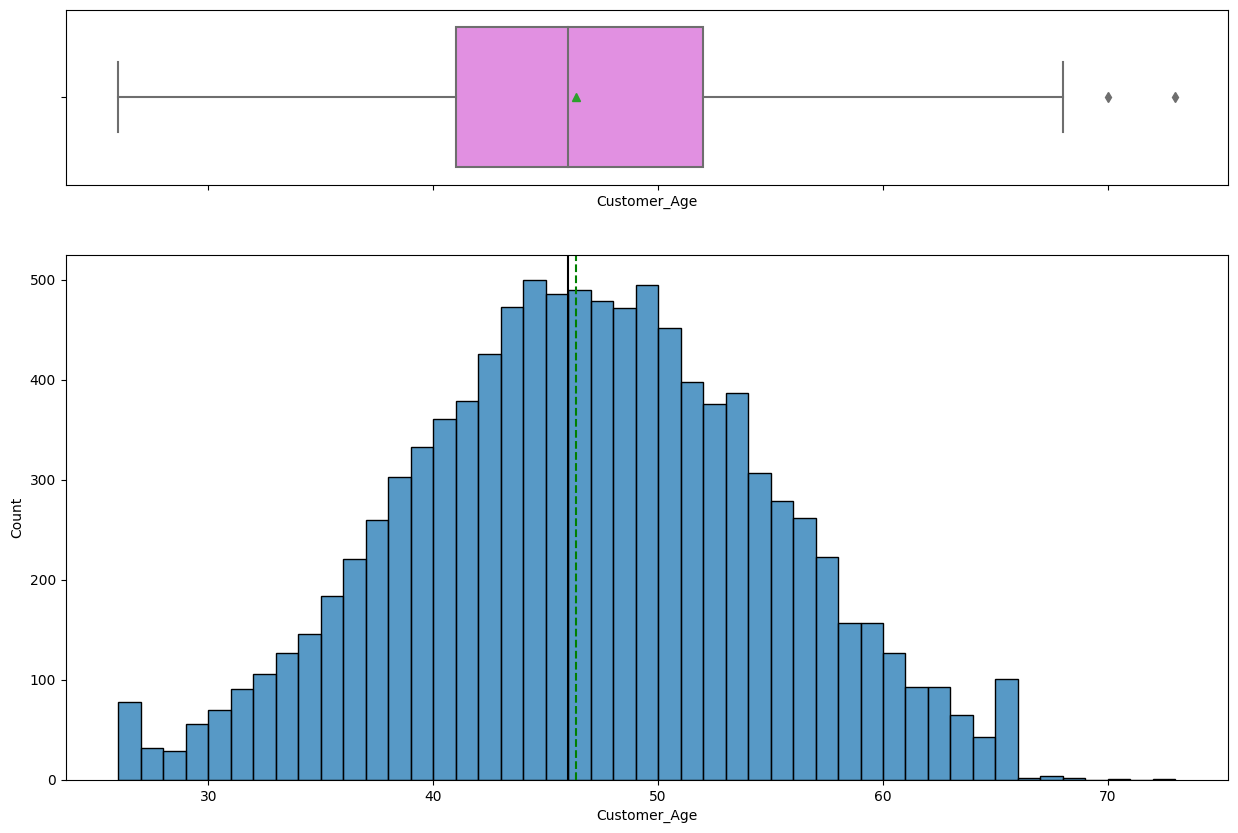

In [24]:
# Observations on Customer_age
histogram_boxplot(bc_df, "Customer_Age")

In [25]:
print("Age mean  :", floor(bc_df['Customer_Age'].mean()))
print("Age median:", floor(bc_df['Customer_Age'].median()))
print("Age mode  :", floor(bc_df.loc[:,'Customer_Age'].mode()[0]))
print("Age max   :", bc_df['Customer_Age'].max())
print("Age min   :", bc_df['Customer_Age'].min())

Age mean  : 46
Age median: 46
Age mode  : 44
Age max   : 73
Age min   : 26


The distribution of Customer_Age is right-skewed.
The boxplot shows that there are outliers at the right end.

We will not treat these outliers as they represent a real market trend (some customers are older and some are younger).

From the boxplot we can see that the IQR (interquartile range) is somewhere between 42 and 52.

Although our goal is not to provide insight on acquiring new customers but to keep customers, we still have the same question asked earlier. Why are there no cc customers older than 73 and younger than 26?

### **Gender**
Gender of the account holder

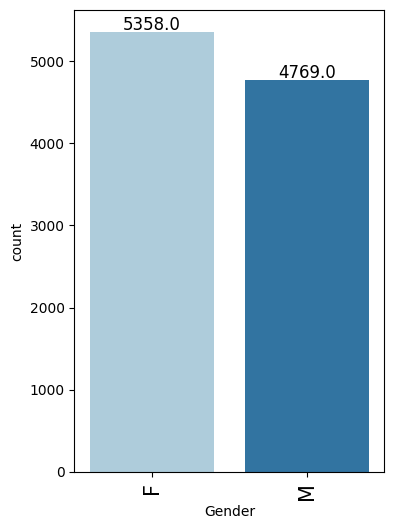

In [26]:
# observations on Gender
labeled_barplot(bc_df, "Gender")

Roughly 53% of customers are Female, and 47% are Male. While this may sound like cliche, they say women love to shop (I think men do too).

### **Dependent_count**
Number of dependents

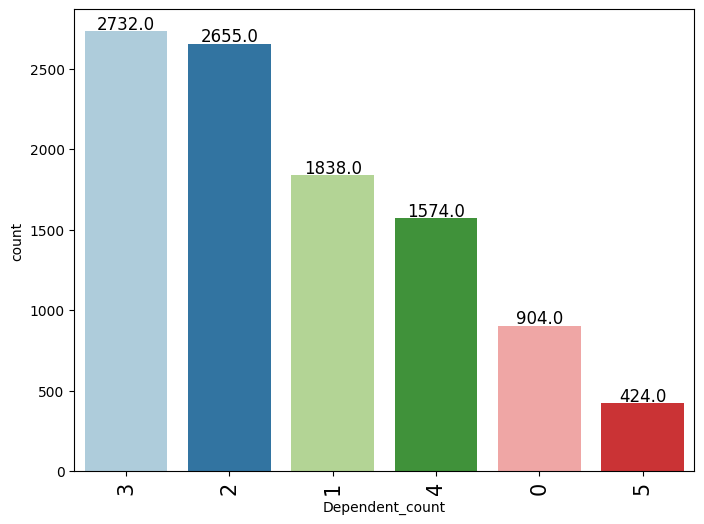

In [27]:
#Observations on Dependent_count
labeled_barplot(bc_df, "Dependent_count")

Most cc customers have 3 and 2 dependents. This is a normal trend.

Also notice that cc customers with 5 dependants are the smallest group.

### **Education_Level**
Educational Qualification of the account holder - Graduate, High School, Unknown, Uneducated, College(refers to a college student), Post-Graduate, Doctorate.

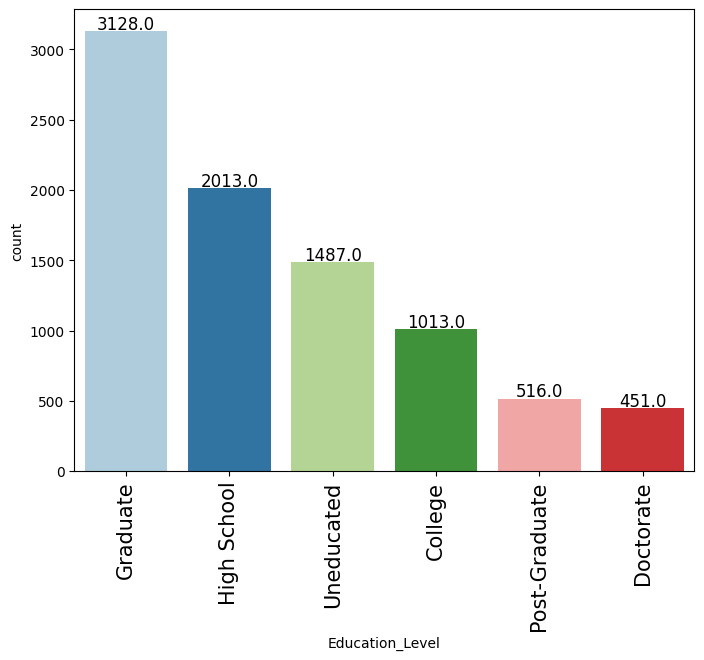

In [28]:
# observations on Education_Level
labeled_barplot(bc_df, "Education_Level")

Surprisingly, most account holders claim to have a graduate degree (31%).  This is a surprise because a minority of the population have graduate degrees.  Notice that this observation is valid for College, Post-Graduate, and Doctorate students. So, what does "Graduate" mean in this context? Does Graduate mean a Graduate Degree as in a Masters Degree? And if so, what does "Post-Graduate" mean?

Note: We don't know where this dataset takes place. With all the previous data we have seen, we are almost certain this dataset doesn't belong to the US. Does it occur in India?

Also keep in mind that we have null values in Education Level, accounting to 15% of all entries.

### **Marital_Status**
Marital Status of the account holder

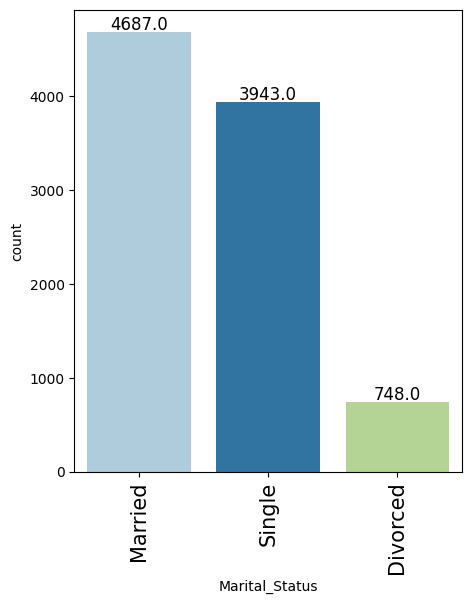

In [29]:
# observations on Gender
labeled_barplot(bc_df, "Marital_Status")

47% of account holders are married, while roughly 40% are single.
7.5% are divorced.

Keep in mind that we have missing values in Marital_Status accounting to 7.4% of all entries.

### **Income_Category**
Annual Income Category of the account holder


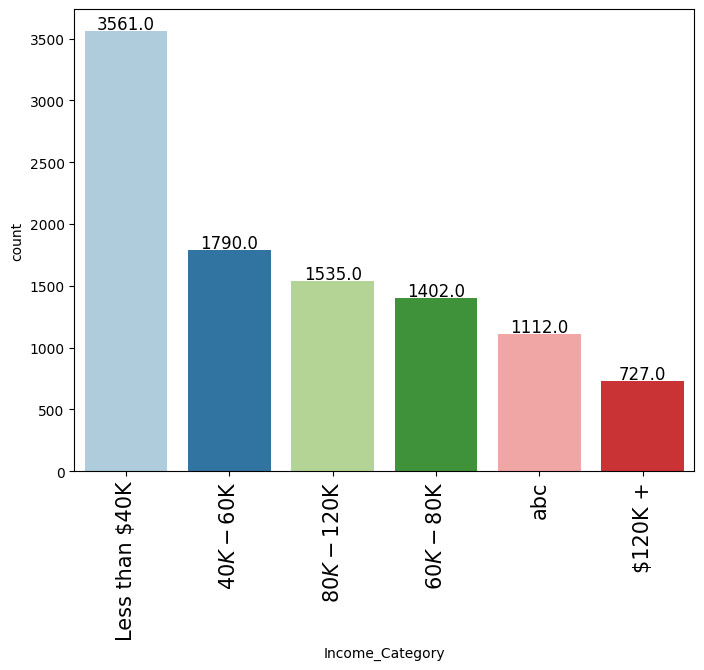

In [30]:
# observations on Income_Category
labeled_barplot(bc_df, "Income_Category")

The largest bin is comprised by customers making less than 40K, then the customers making 40k-60K.

A peculiarity is that the group 80k-120K is larger than the 60K-80K, and the 'abc' group is between 60k-80k and 120k+.

So how would the 'abc' group be actually distributed? Should it be distributed by weights, giving larger percentages to smaller salary amount bins and smaller percentages to larger salary amount bins?

We will focus on that a bit later.

### **Card_Category**
Type of Card

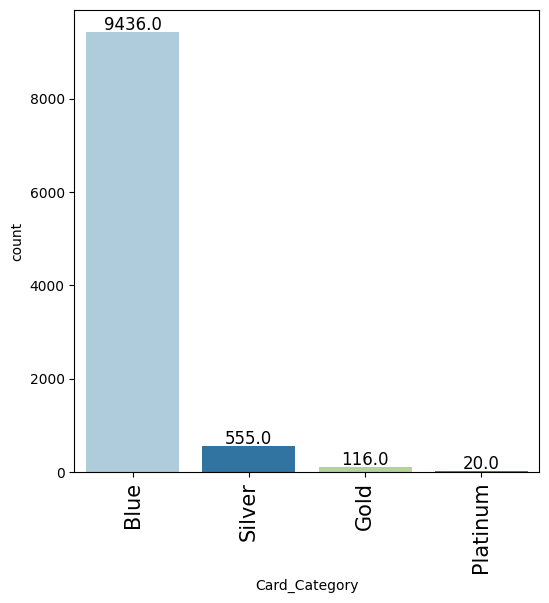

In [31]:
#Observations on Card_Category
labeled_barplot(bc_df, "Card_Category")

As expected, most customers have the lowest level card, Blue and only a few have the exclusive Platinum Card.

Notice that Blue<Silver<Gold<Platinum so this can be hotencoded


### **Months_on_book**
Period of relationship with the bank

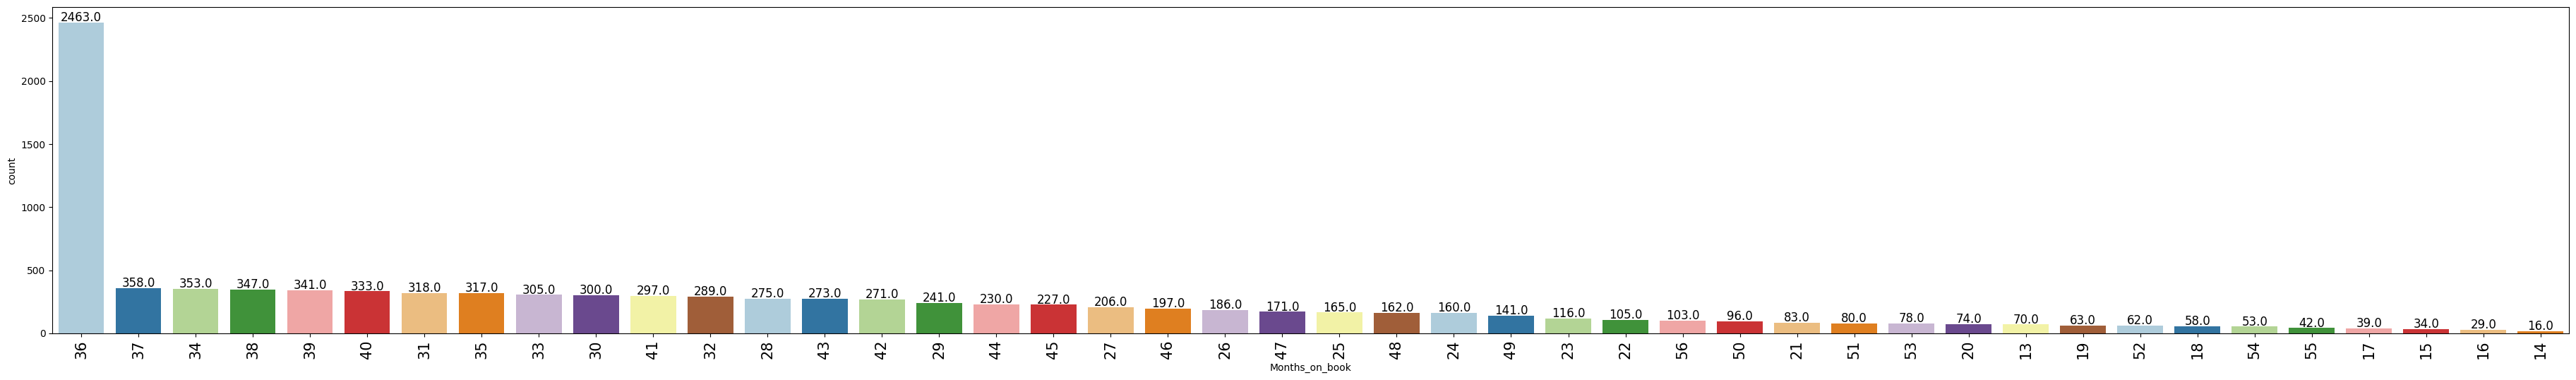

In [32]:
# observations on Months_on_Book
labeled_barplot(bc_df, "Months_on_book")

In [33]:
print("Months_on_book mean  :", floor(bc_df['Months_on_book'].mean()))
print("Months_on_book median:", floor(bc_df['Months_on_book'].median()))
print("Months_on_book mode  :", floor(bc_df.loc[:,'Months_on_book'].mode()[0]))
print("Months_on_book max   :", bc_df['Months_on_book'].max())
print("Months_on_book min   :", bc_df['Months_on_book'].min())

Months_on_book mean  : 35
Months_on_book median: 36
Months_on_book mode  : 36
Months_on_book max   : 56
Months_on_book min   : 13


Most customers 25% have 3 years relationship with Thera.  The average is 35 months, the maximum is 56 months, while the minimum is 13 months.

So cc customers have at least a one year relationship with Thera.

### **Total_Relationship_Count**
Total no. of products held by the customer



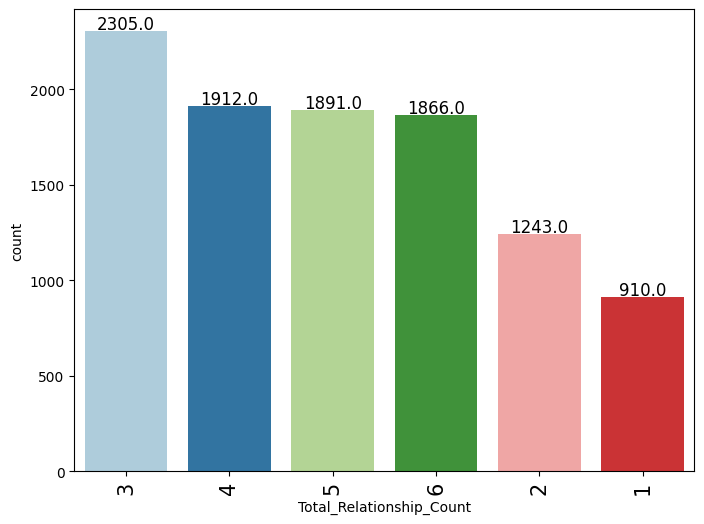

In [34]:
#Observations on Total_Relationship_Count
labeled_barplot(bc_df, "Total_Relationship_Count")

Notice that almost all customers have one additional product to the credit card. Most have 3 to 6 products including the credit card.

### **Months_Inactive_12_mon**
No. of months inactive in the last 12 months

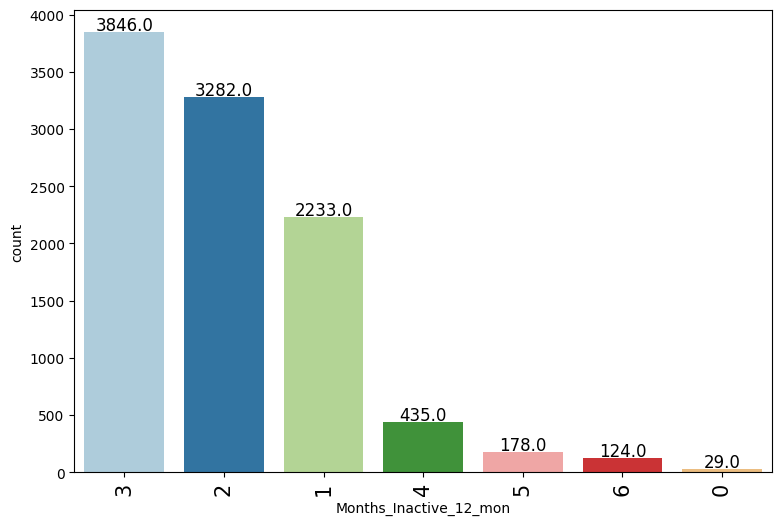

In [35]:
#Observations on Months_Inactive_12_mon
labeled_barplot(bc_df, "Months_Inactive_12_mon")

The majority of cc customers are 3 to 1 months inactive using their credit cards during the last 12 months.

cc customers that are inactive for 4 to 6 months amount to less than 10%.

Only a few customers are 0 months inactive.

### **Contacts_Count_12_mon**
No. of Contacts between the customer and bank in the last 12 months

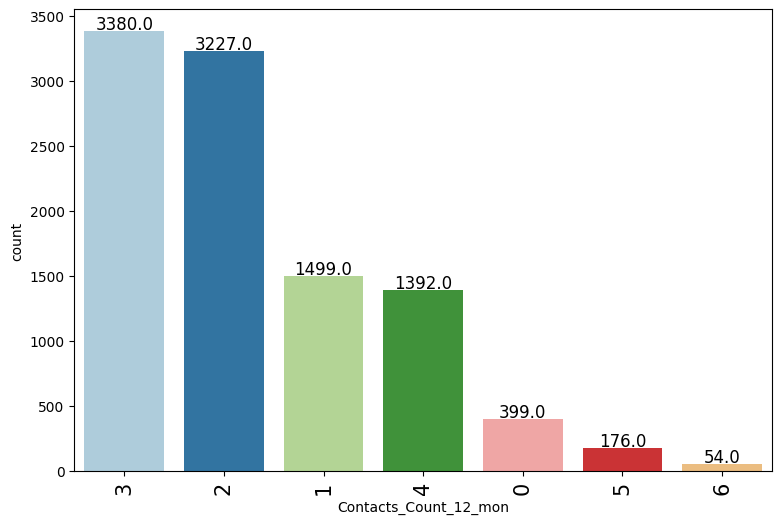

In [36]:
#Observations on Contacts_Count_12_mon
labeled_barplot(bc_df, "Contacts_Count_12_mon")

Most customers have between 2 to 3 contacts with the Thera in the last 12 months. Only 0.05% have 6 contacts, and only 0.4% have no contact at all.

###**Credit_Limit**
Credit Limit on the Credit Card

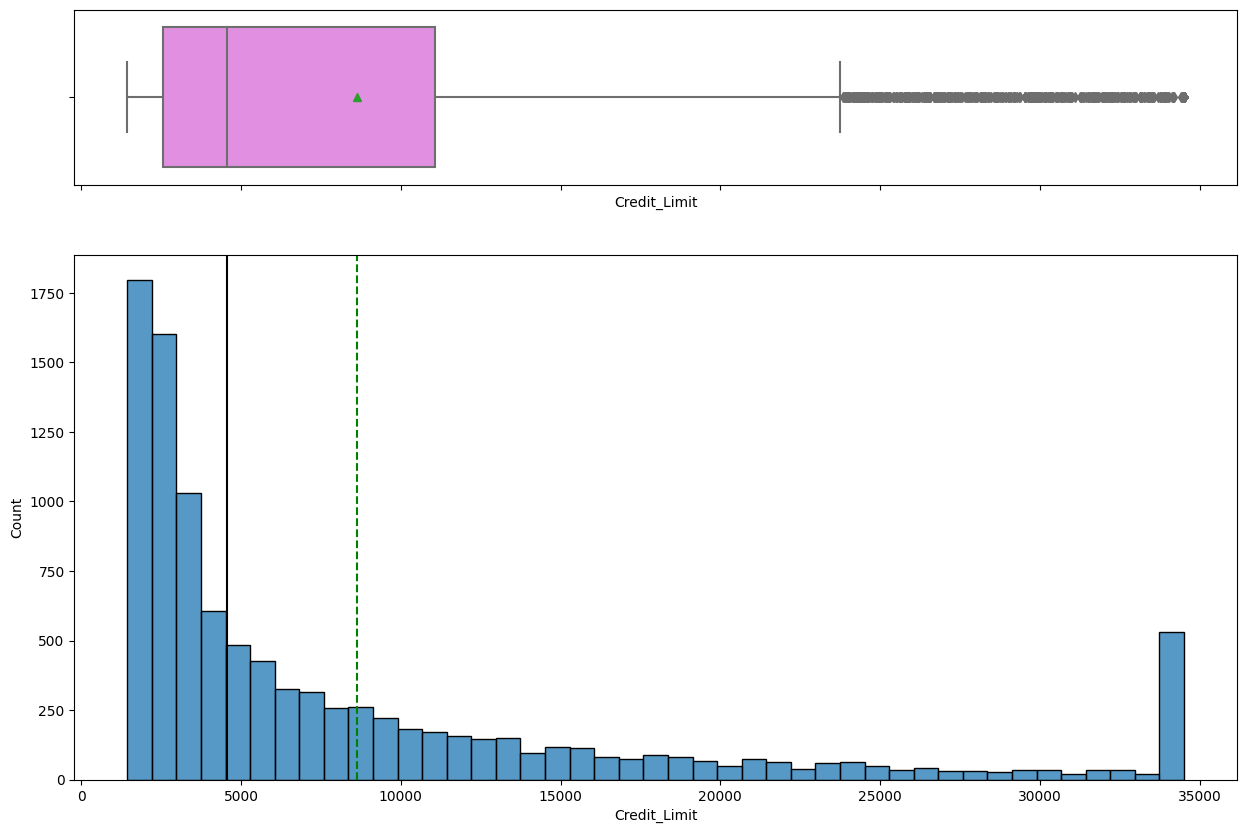

In [37]:
# Observations on Credit_Limit
histogram_boxplot(bc_df, "Credit_Limit")

In [38]:
print("Credit_Limit mean  :", floor(bc_df['Credit_Limit'].mean()))
print("Credit_Limit median:", floor(bc_df['Credit_Limit'].median()))
print("Credit_Limit max   :", floor(bc_df['Credit_Limit'].max()))
print("Credit_Limit min   :", floor(bc_df['Credit_Limit'].min()))

Credit_Limit mean  : 8631
Credit_Limit median: 4549
Credit_Limit max   : 34516
Credit_Limit min   : 1438


The credit limit is skewed to the right. This is normal because lower credit limits are more common than higher credit limits.

Also there are outliers but these are most likely also good because there are always customers with a high credit limit.

The average credit limit is \$8,600, the maximum is \$34,516 and the minimum is \$1,438.

### **Total_Revolving_Bal**
The balance that carries over from one month to the next is the revolving balance.

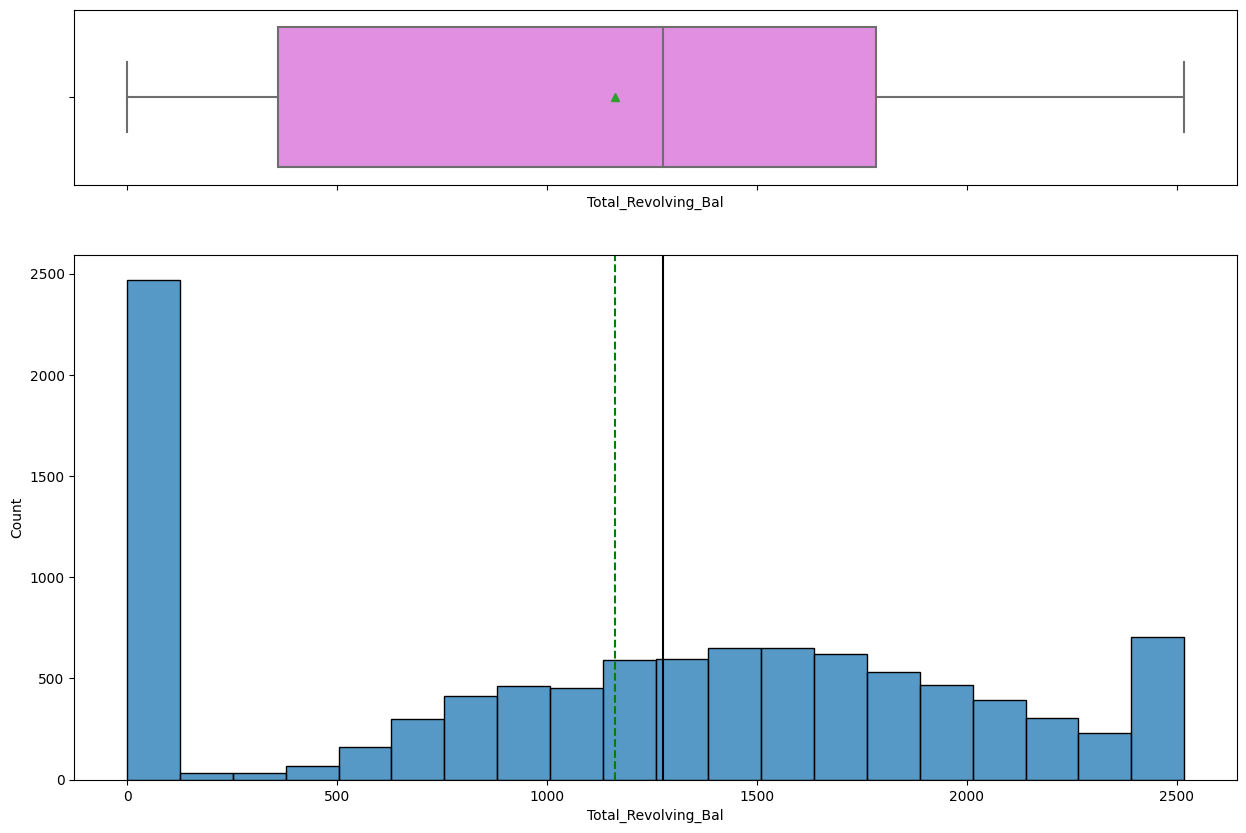

In [39]:
# Observations on Total_Revolving_Bal
histogram_boxplot(bc_df, "Total_Revolving_Bal")

In [40]:
print("Total_Revolving_Bal mean  :", floor(bc_df['Total_Revolving_Bal'].mean()))
print("Total_Revolving_Bal median:", floor(bc_df['Total_Revolving_Bal'].median()))
print("Total_Revolving_Bal max   :", floor(bc_df['Total_Revolving_Bal'].max()))
print("Total_Revolving_Bal min   :", floor(bc_df['Total_Revolving_Bal'].min()))

Total_Revolving_Bal mean  : 1162
Total_Revolving_Bal median: 1276
Total_Revolving_Bal max   : 2517
Total_Revolving_Bal min   : 0


The Total Revolving Balance is skewed to the left with a large number of customers having 0 revolving balance. This is may also be due to the fact that there is a very large number of customers that do not use their cards too often.

The maximum Total Revolving Balance is \$2,517 and the average is \$1,162.

### **Avg_Open_To_Buy**
Open to Buy refers to the amount left on the credit card to use (Average of last 12 months)

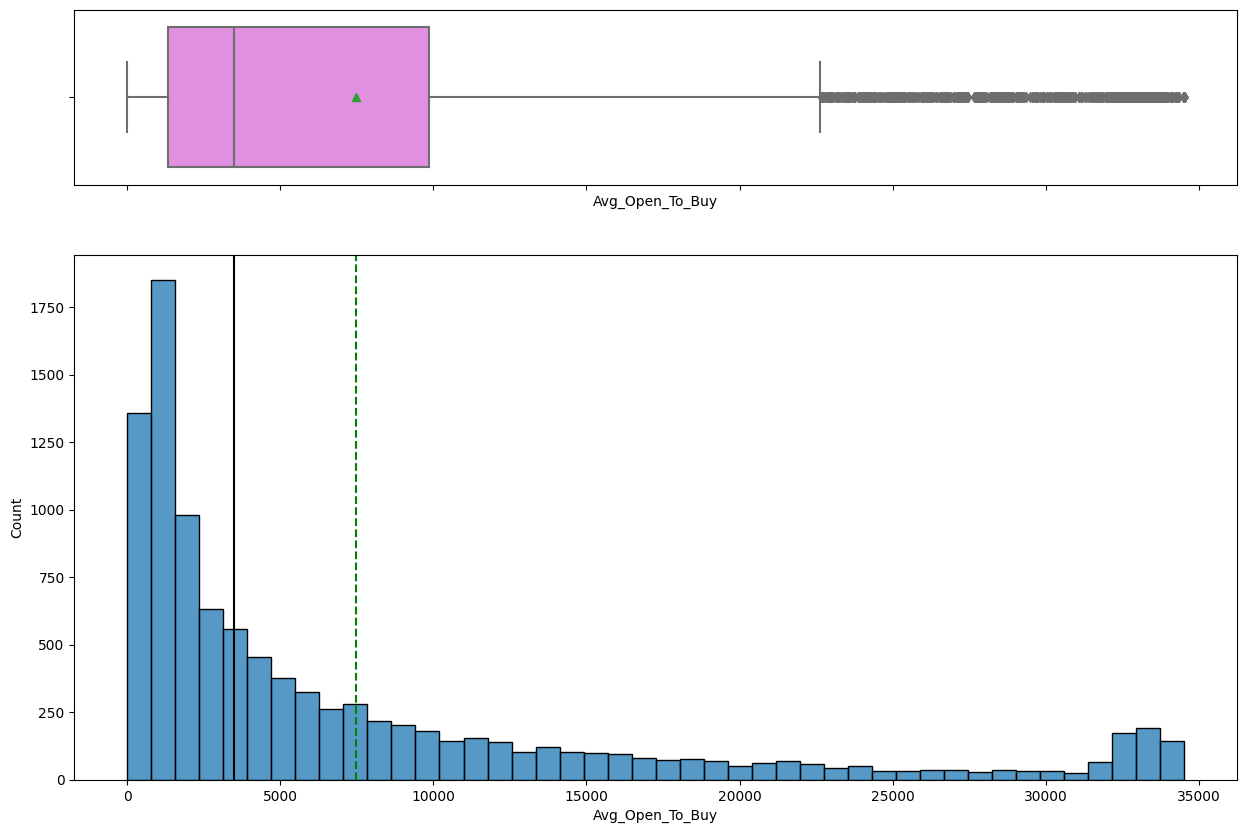

In [41]:
# Observations on Avg_Open_To_Buy
histogram_boxplot(bc_df, "Avg_Open_To_Buy")

In [42]:
print("Avg_Open_To_Buy mean  :", floor(bc_df['Avg_Open_To_Buy'].mean()))
print("Avg_Open_To_Buy median:", floor(bc_df['Avg_Open_To_Buy'].median()))
print("Avg_Open_To_Buy max   :", floor(bc_df['Avg_Open_To_Buy'].max()))
print("Avg_Open_To_Buy min   :", floor(bc_df['Avg_Open_To_Buy'].min()))

Avg_Open_To_Buy mean  : 7469
Avg_Open_To_Buy median: 3474
Avg_Open_To_Buy max   : 34516
Avg_Open_To_Buy min   : 3


This distribution has many outliers, and this is normal as there will be many card holders with large credit that either don't use the card enough or the credit is very large that small uses still leave a large credit available.

On the other hand, it is common that there will be a majority of customers with partial or little credit left.

The minimum Average Open to Buy is 3, which means that the credit card is maxed up. The maximum is \$34,516, and the average is \$7,469.

###**Total_Trans_Amt**
Total Transaction Amount (Last 12 months)

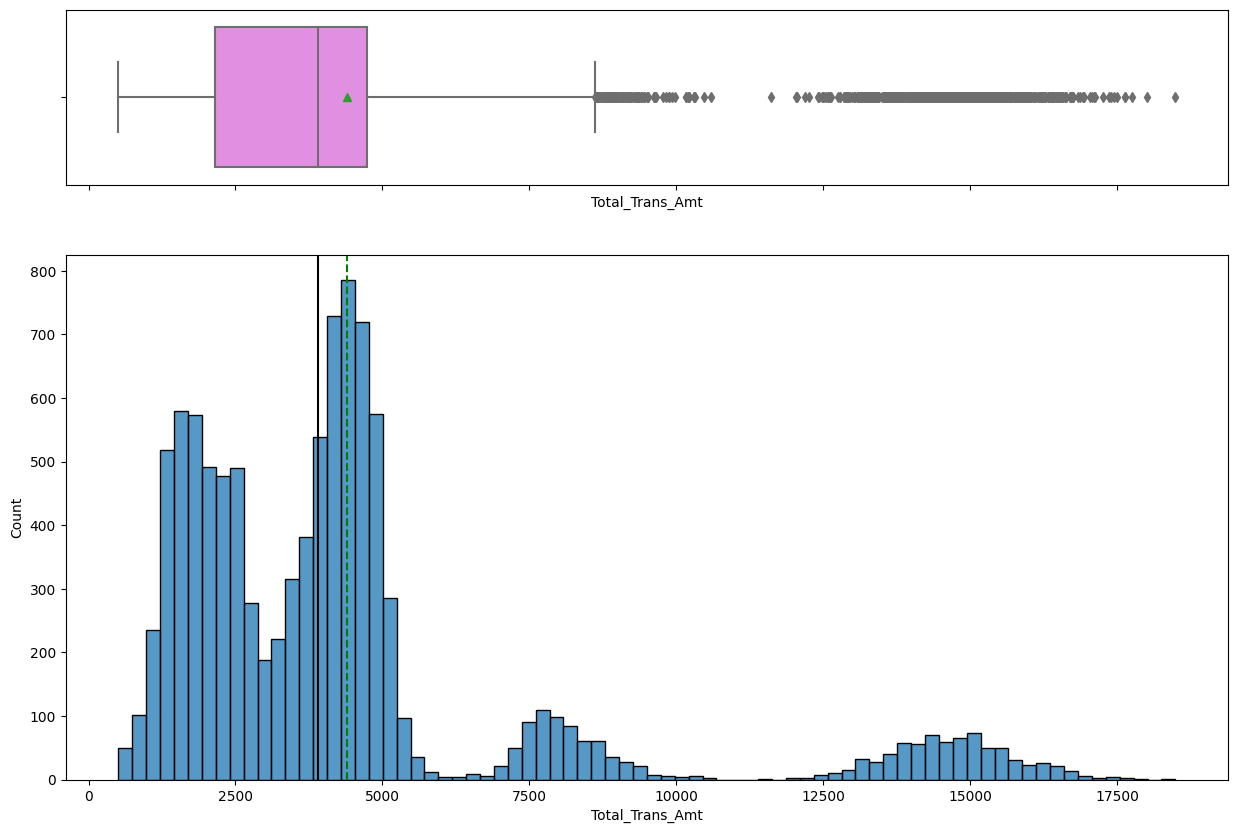

In [43]:
# Observations on Total_Trans_Amt
histogram_boxplot(bc_df, "Total_Trans_Amt")

In [44]:
print("Total_Trans_Amt mean  :", floor(bc_df['Total_Trans_Amt'].mean()))
print("Total_Trans_Amt median:", floor(bc_df['Total_Trans_Amt'].median()))
print("Total_Trans_Amt max   :", floor(bc_df['Total_Trans_Amt'].max()))
print("Total_Trans_Amt min   :", floor(bc_df['Total_Trans_Amt'].min()))

Total_Trans_Amt mean  : 4404
Total_Trans_Amt median: 3899
Total_Trans_Amt max   : 18484
Total_Trans_Amt min   : 510


This distribution is related to the amount of credit a card holder has.

The maximum Transaction amount is \$18,464 and as can be observed, only a few transactions are between \$12,500 to \
$18,000, and \$6,000 to \$11,000.

Most transactions are between \$510 to \$5,000, with \$3,899 being the median.

###**Total_Trans_Ct**
Total Transaction Count (Last 12 months)

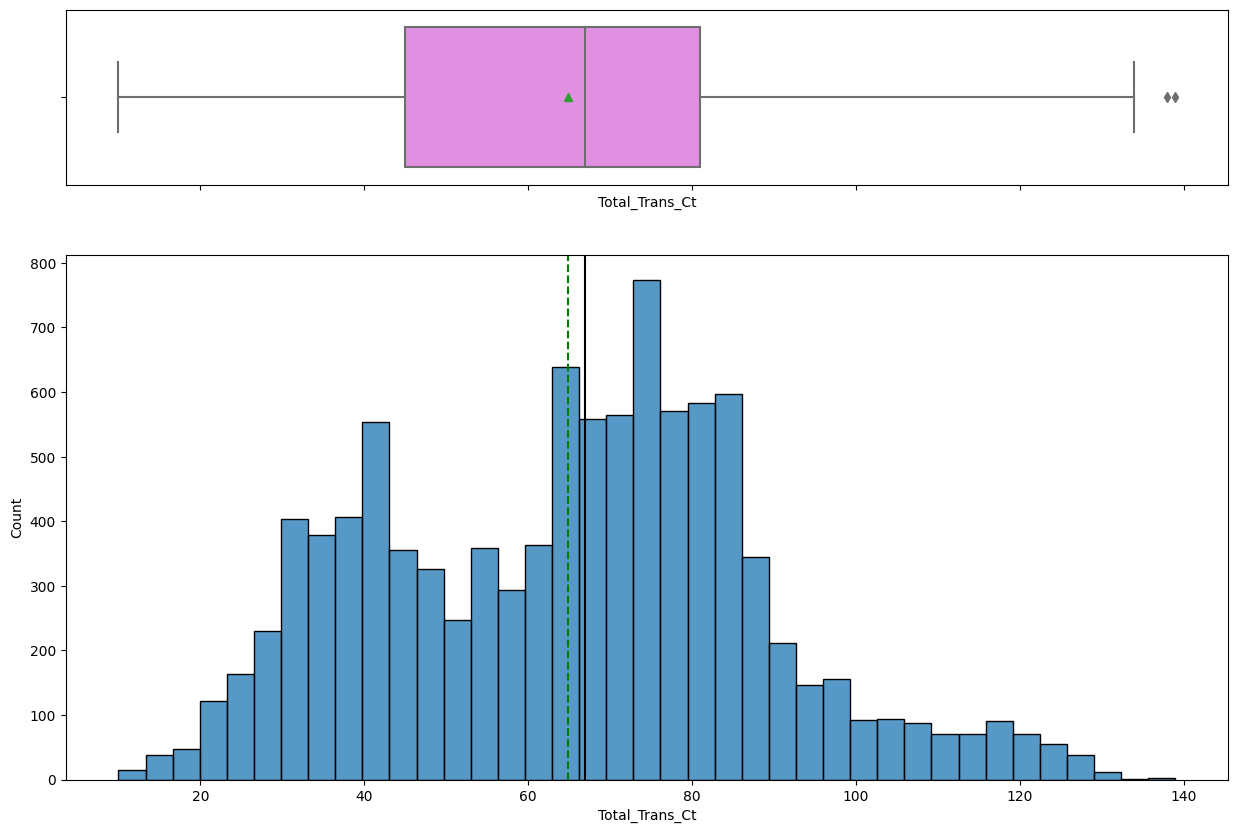

In [45]:
# Observations on Total_Trans_Ct
histogram_boxplot(bc_df, "Total_Trans_Ct")

In [46]:
print("Total_Trans_Ct mean  :", floor(bc_df['Total_Trans_Ct'].mean()))
print("Total_Trans_Ct median:", floor(bc_df['Total_Trans_Ct'].median()))
print("Total_Trans_Ct max   :", floor(bc_df['Total_Trans_Ct'].max()))
print("Total_Trans_Ct min   :", floor(bc_df['Total_Trans_Ct'].min()))

Total_Trans_Ct mean  : 64
Total_Trans_Ct median: 67
Total_Trans_Ct max   : 139
Total_Trans_Ct min   : 10


This distribution is skewed to the right, and shows that there are many customers with more than 100 transactions in the last 12 months.

Notice that the average number of Total transactions in the last 12 months is 64, or roughly 5 transactions per month and the minimum is 10 or less than one transaction per month.

###**Total_Ct_Chng_Q4_Q1**
Ratio of the total transaction count in 4th quarter and the total transaction count in 1st quarter**

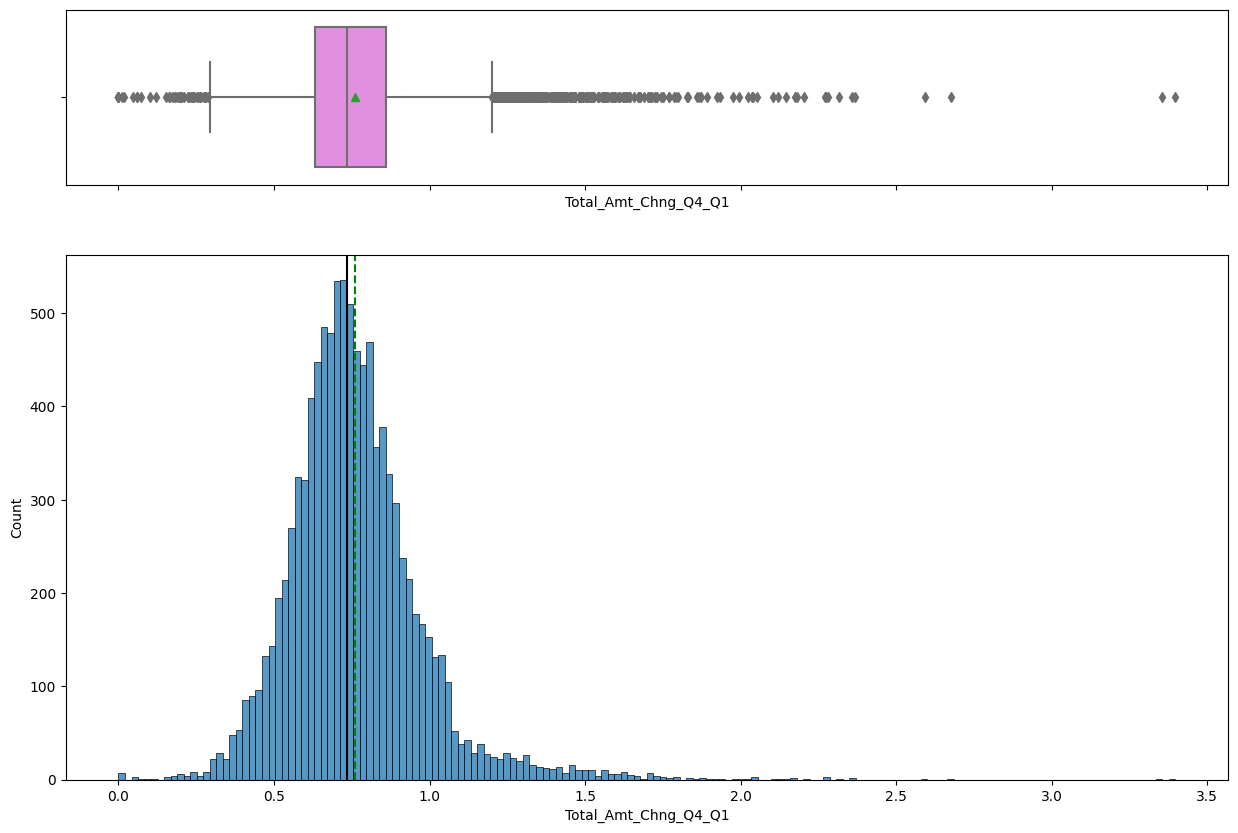

In [47]:
# Observations on Total_Amt_Chng_Q4_Q1
histogram_boxplot(bc_df, "Total_Amt_Chng_Q4_Q1")

This distribution is skewed to the right and shows  that more than 95% of the card holders, their transactions transactions in Q4 were less than Q1. Would that mean that in Q4 the amount of the transactions were larger?

There are many outliers but these are valid because this consumer behavior is possible.

Internal Note: If the dataset would be from the US, I would expect Total_Ct_Chng_Q4_Q1 to be from 1 to max because Christmas is a high expense season in Q4.

###**Total_Amt_Chng_Q4_Q1**
Ratio of the total transaction amount in 4th quarter and the total transaction amount in 1st quarter

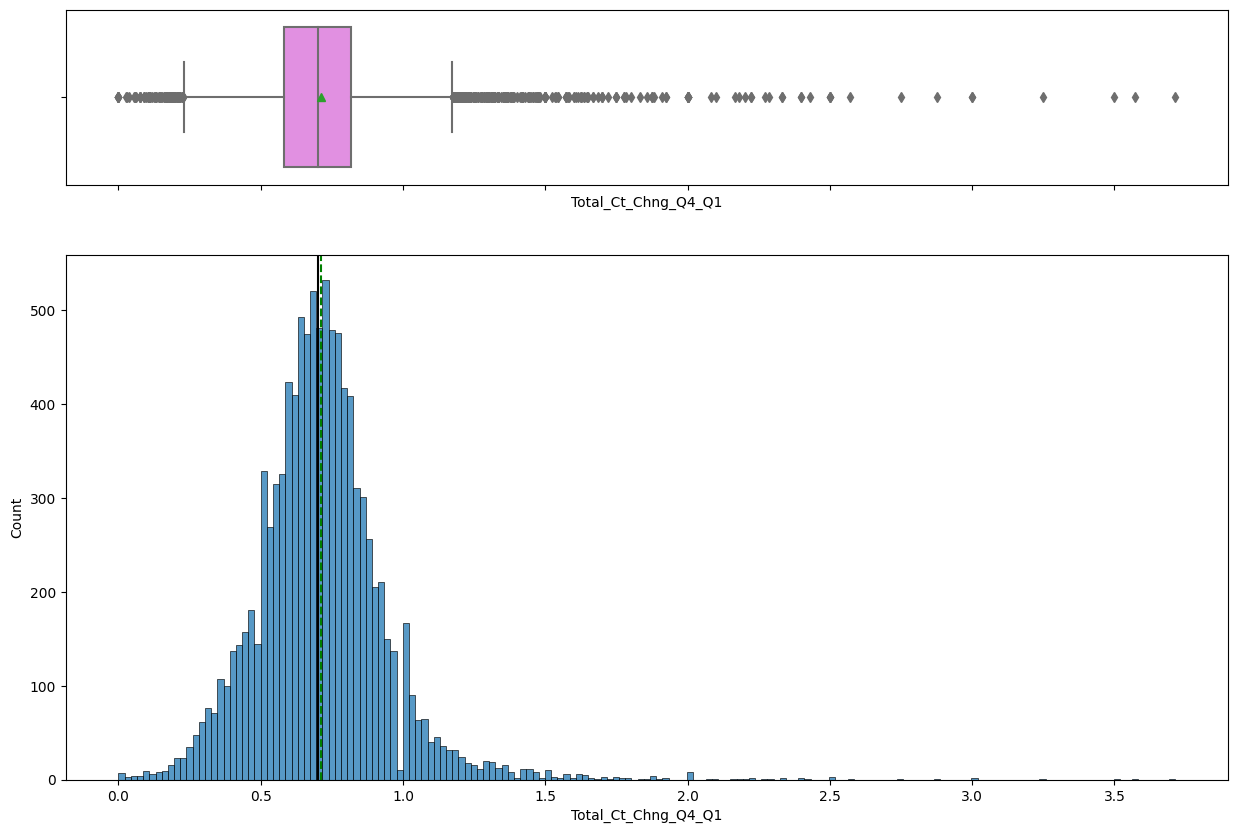

In [48]:
# Observations on Total_Ct_Chng_Q4_Q1
histogram_boxplot(bc_df, "Total_Ct_Chng_Q4_Q1")

Looking now at the total amounts of transactions Q4 - Q1, we notice that 95% of card holders actually spent less money in Q4 than Q1.


###**Avg_Utilization_Ratio**
Represents how much of the available credit the customer spent

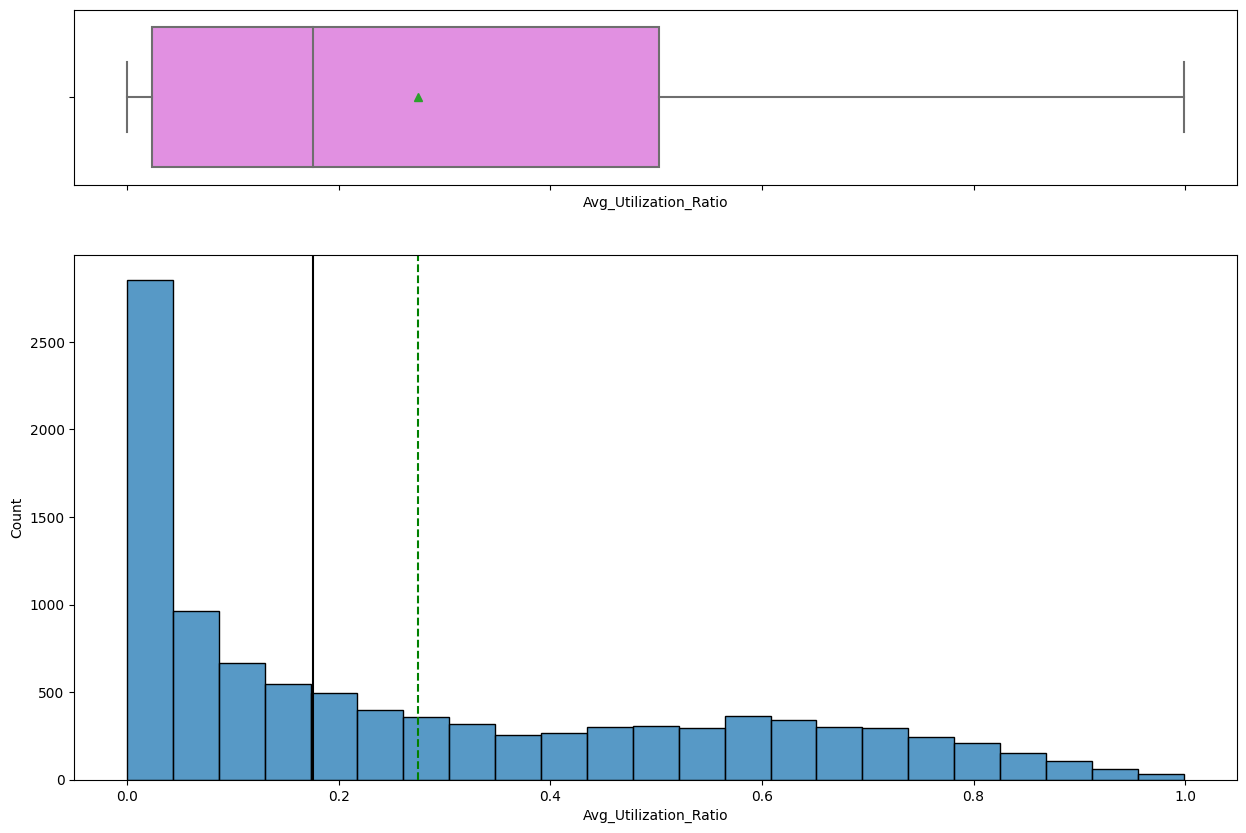

In [49]:
# Observations on Avg_Utilization_Ratio
histogram_boxplot(bc_df, "Avg_Utilization_Ratio")

Look at the large amount of card holders that have an avg utilization ration of 0!

###**Attrition_Flag**
Internal event (customer activity) variable - if the account is closed then "Attrited Customer" else "Existing Customer"**


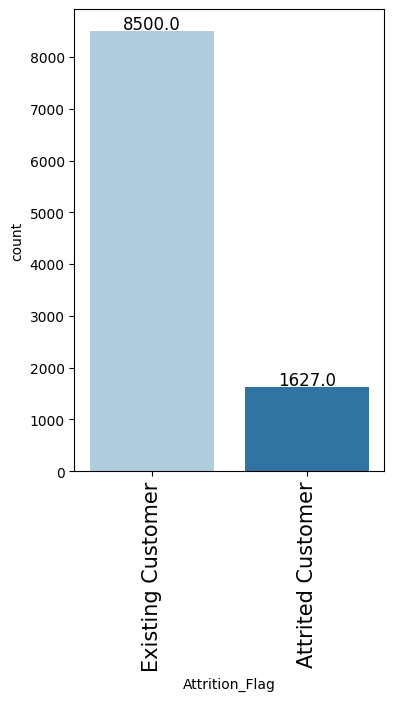

In [50]:
#Observations on Attrition_Flag
labeled_barplot(bc_df, "Attrition_Flag")

This is the target. Notice that the data is imbalanced as 84% are existing customers and 16% are churned customers.


## **Bivariate Analysis**

In [51]:
sns.pairplot(bc_df, hue="Attrition_Flag")

Output hidden; open in https://colab.research.google.com to view.

Total_Revolving_Balance, Avg_Utlization_Ratio, Total_Trans_Ct are features of interest. If we observe their corresponding plots, we notice that Attrited_Customers and Existing_Customers follow different trends.

So we will pay special attention to these later.

###**Attrition_Flag vs Others**

<Axes: xlabel='Attrition_Flag', ylabel='Total_Amt_Chng_Q4_Q1'>

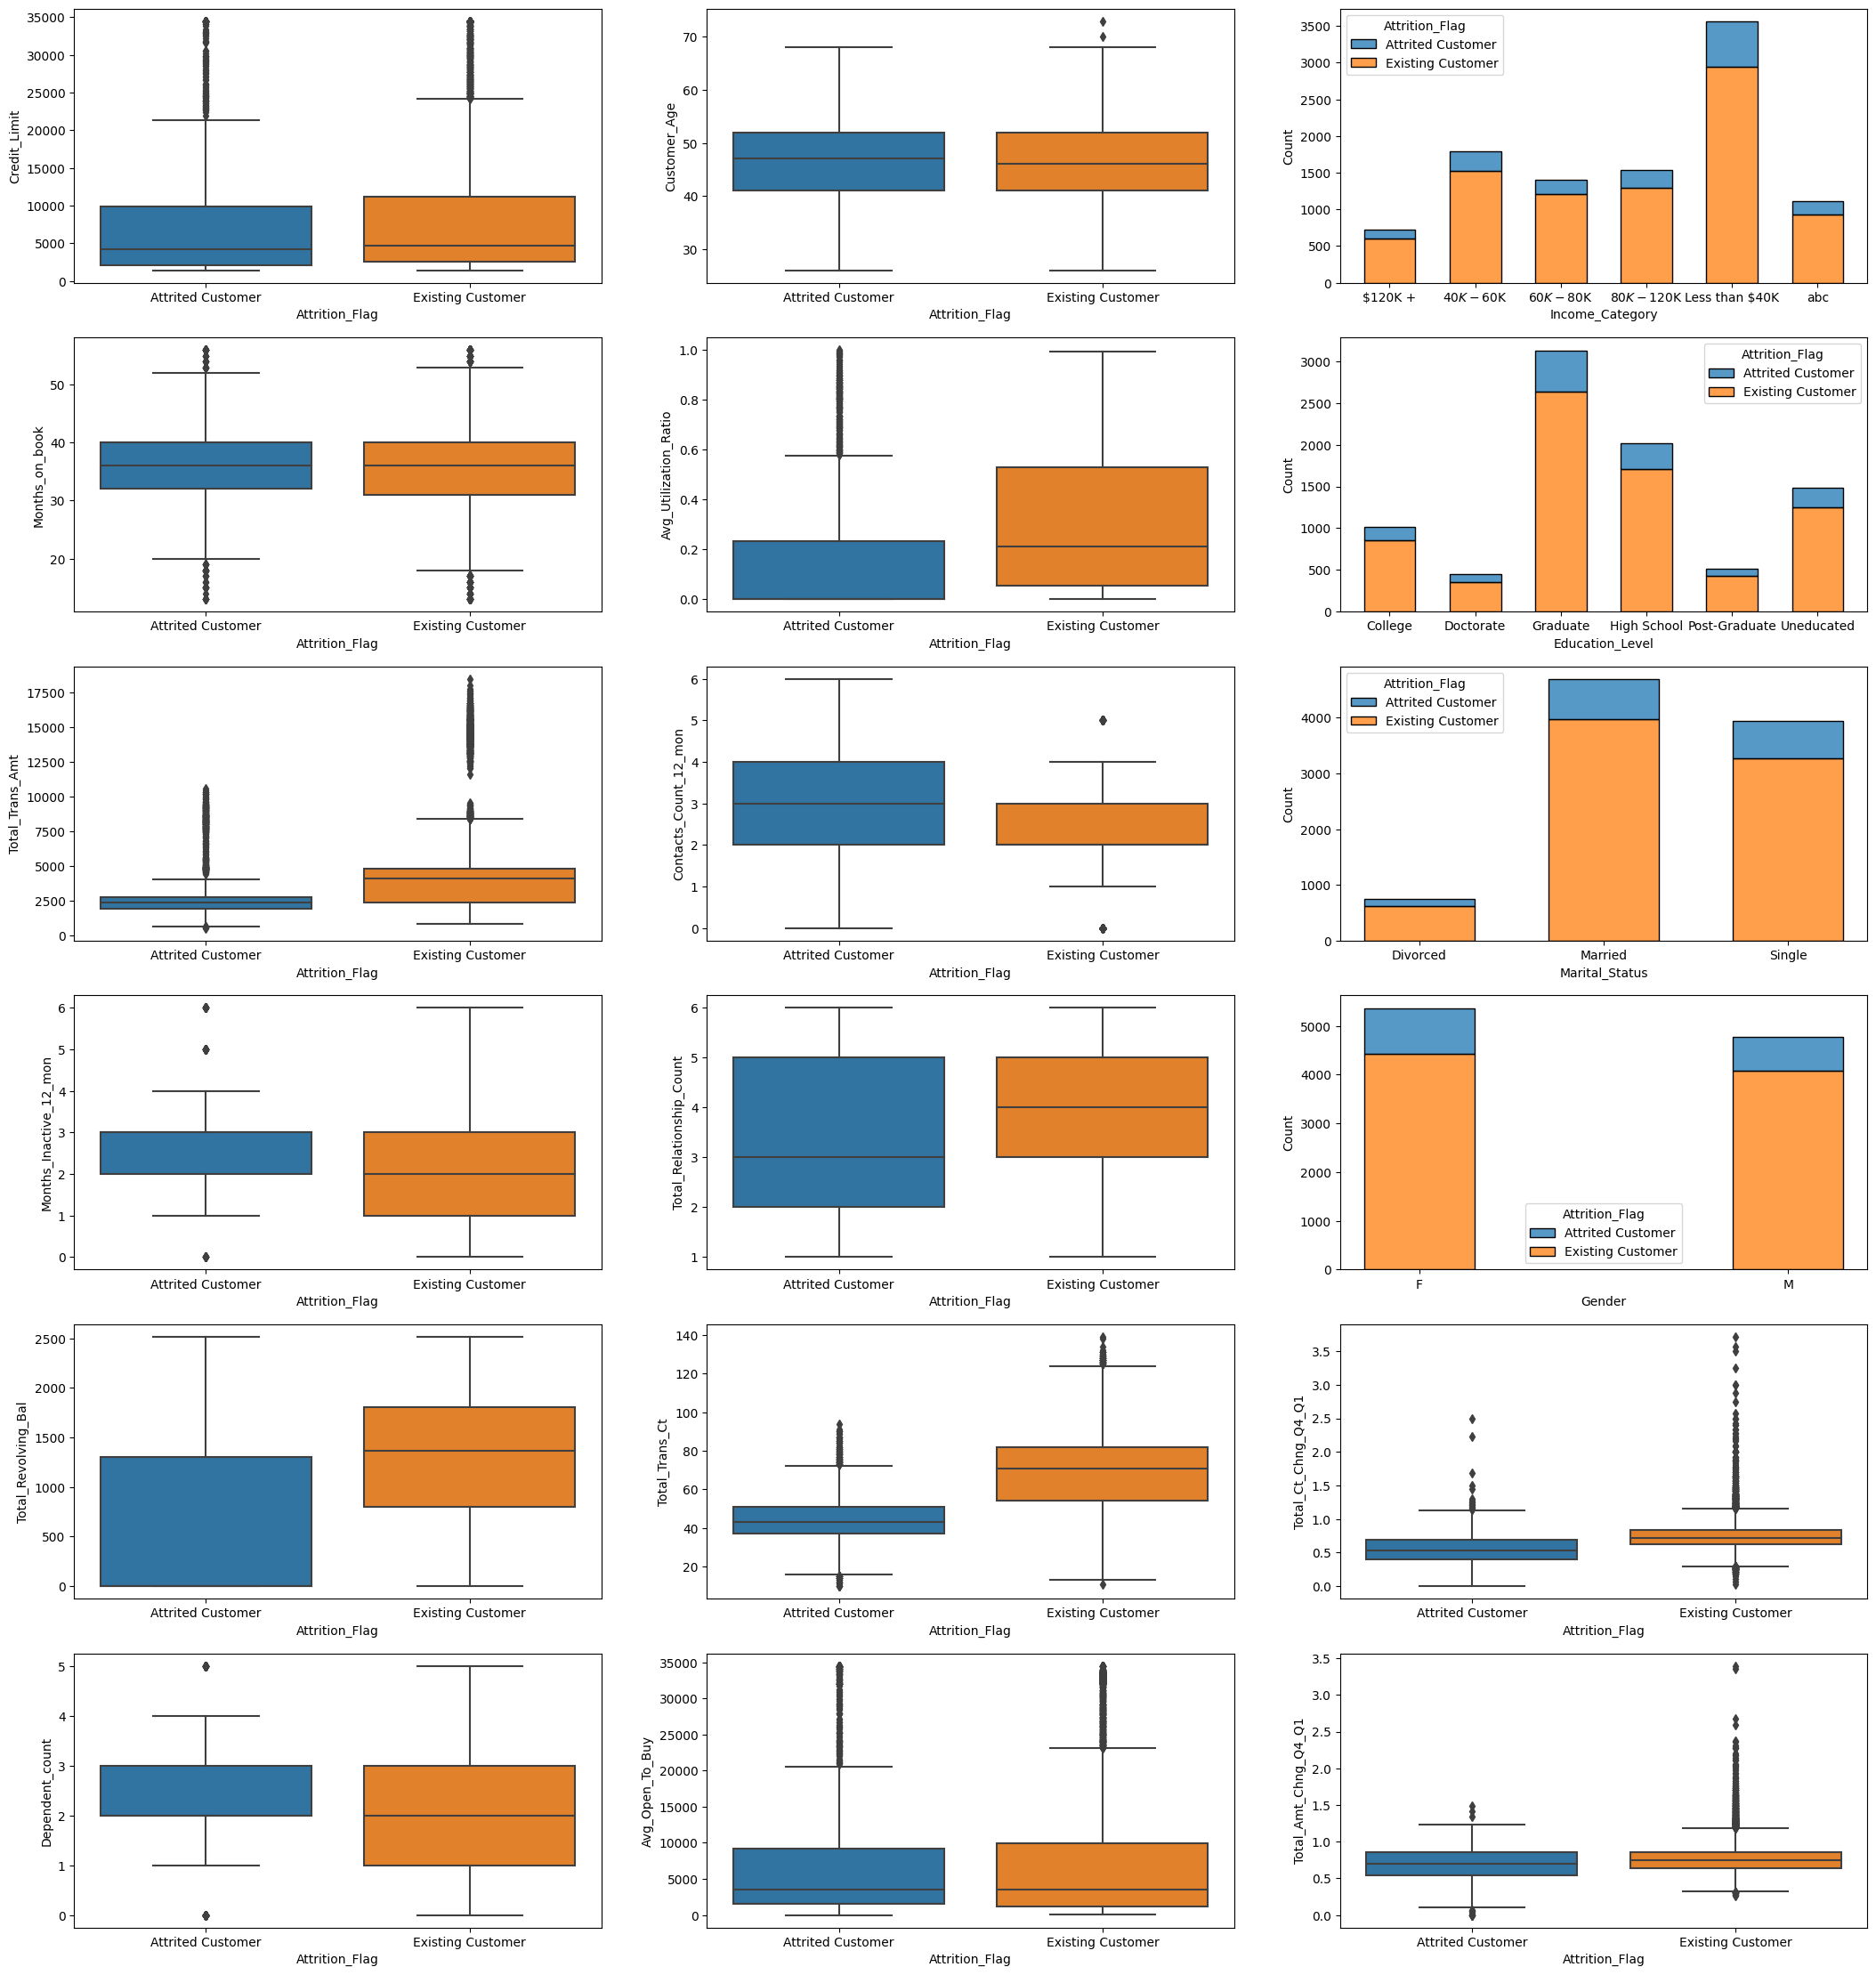

In [52]:
#sns.set(rc={"figure.figsize": (10, 7)})
fig, axes = plt.subplots(6, 3, figsize=(26,28))

sns.boxplot(x="Attrition_Flag", y = "Credit_Limit", data=bc_df, orient="vertical", ax=axes[0,0])
sns.boxplot(x="Attrition_Flag", y = "Customer_Age", data=bc_df, orient="vertical", ax=axes[0,1])
sns.histplot(data=bc_df, x="Income_Category", hue="Attrition_Flag", multiple="stack", shrink=.6, ax=axes[0,2])

sns.boxplot(x="Attrition_Flag", y = "Months_on_book", data=bc_df, orient="vertical", ax=axes[1,0])
sns.boxplot(x="Attrition_Flag", y = "Avg_Utilization_Ratio", data=bc_df, orient="vertical", ax=axes[1,1])
sns.histplot(data=bc_df, x="Education_Level", hue="Attrition_Flag", multiple="stack", shrink=.6, ax=axes[1,2])

sns.boxplot(x="Attrition_Flag", y = "Total_Trans_Amt", data=bc_df, orient="vertical", ax=axes[2,0])
sns.boxplot(x="Attrition_Flag", y = "Contacts_Count_12_mon", data=bc_df, orient="vertical", ax=axes[2,1])
sns.histplot(data=bc_df, x="Marital_Status", hue="Attrition_Flag", multiple="stack", shrink=.6, ax=axes[2,2])

sns.boxplot(x="Attrition_Flag", y = "Months_Inactive_12_mon", data=bc_df, orient="vertical", ax=axes[3,0])
sns.boxplot(x="Attrition_Flag", y = "Total_Relationship_Count", data=bc_df, orient="vertical", ax=axes[3,1])
sns.histplot(data=bc_df, x="Gender", hue="Attrition_Flag", multiple="stack", shrink=.3, ax=axes[3,2])

sns.boxplot(x="Attrition_Flag", y = "Total_Revolving_Bal", data=bc_df, orient="vertical", ax=axes[4,0])
sns.boxplot(x="Attrition_Flag", y = "Total_Trans_Ct", data=bc_df, orient="vertical", ax=axes[4,1])
sns.boxplot(x="Attrition_Flag", y = "Total_Ct_Chng_Q4_Q1", data=bc_df, orient="vertical", ax=axes[4,2])

sns.boxplot(x="Attrition_Flag", y = "Dependent_count", data=bc_df, orient="vertical", ax=axes[5,0])
sns.boxplot(x="Attrition_Flag", y = "Avg_Open_To_Buy", data=bc_df, orient="vertical", ax=axes[5,1])
sns.boxplot(x="Attrition_Flag", y = "Total_Amt_Chng_Q4_Q1", data=bc_df, orient="vertical", ax=axes[5,2])


- The Credit limit of Attrited customers is slightly smaller. Also notice that there are more outliers in the attrited customers group. It seems that a high credit limit will not avoid attrition.
- Age doesn't seem to play a key factor in the attrition.
- Although it is proportional to its income group, the largest attrition occurs in customers declaring earnings lower than \$40K.
- Months_on_book, the months the customer has had a relationship with the bank doesn't seem to be a key factor, however, notice that there are many outliers in the attrited group corresponding to customers with a relationship of 20 months or less.
- Average Utilization ratio is a key factor, Customers that haev a lower cc use ratio tend to attrite more. Customer w/ an utilization rate of 20% or lower churned.
- The largest group of attrited customers were in the Graduate group but this is also the largest group of customers.
- Customers with Total Transaction amounts of 2700 or less tend to churn.
- The number of contacts in a year is higher for attrited customers. In other words, these customers contacted the bank. This may indicate customer insatisfaction or complaints.
- Customers that had less transactions Q4 than Q1 tend to churn more.
- Marital status doesn't seem to be a factor.
- Gender Females attrite more than men.
- Number of dependants doesn't seem to be factor.
- Average Available credit was slightly lower for attrited custoemrs.
- Customers that spent more in Q1 than Q4 churned more.

###**Income_Category vs Others**

<Axes: xlabel='Income_Category', ylabel='Total_Amt_Chng_Q4_Q1'>

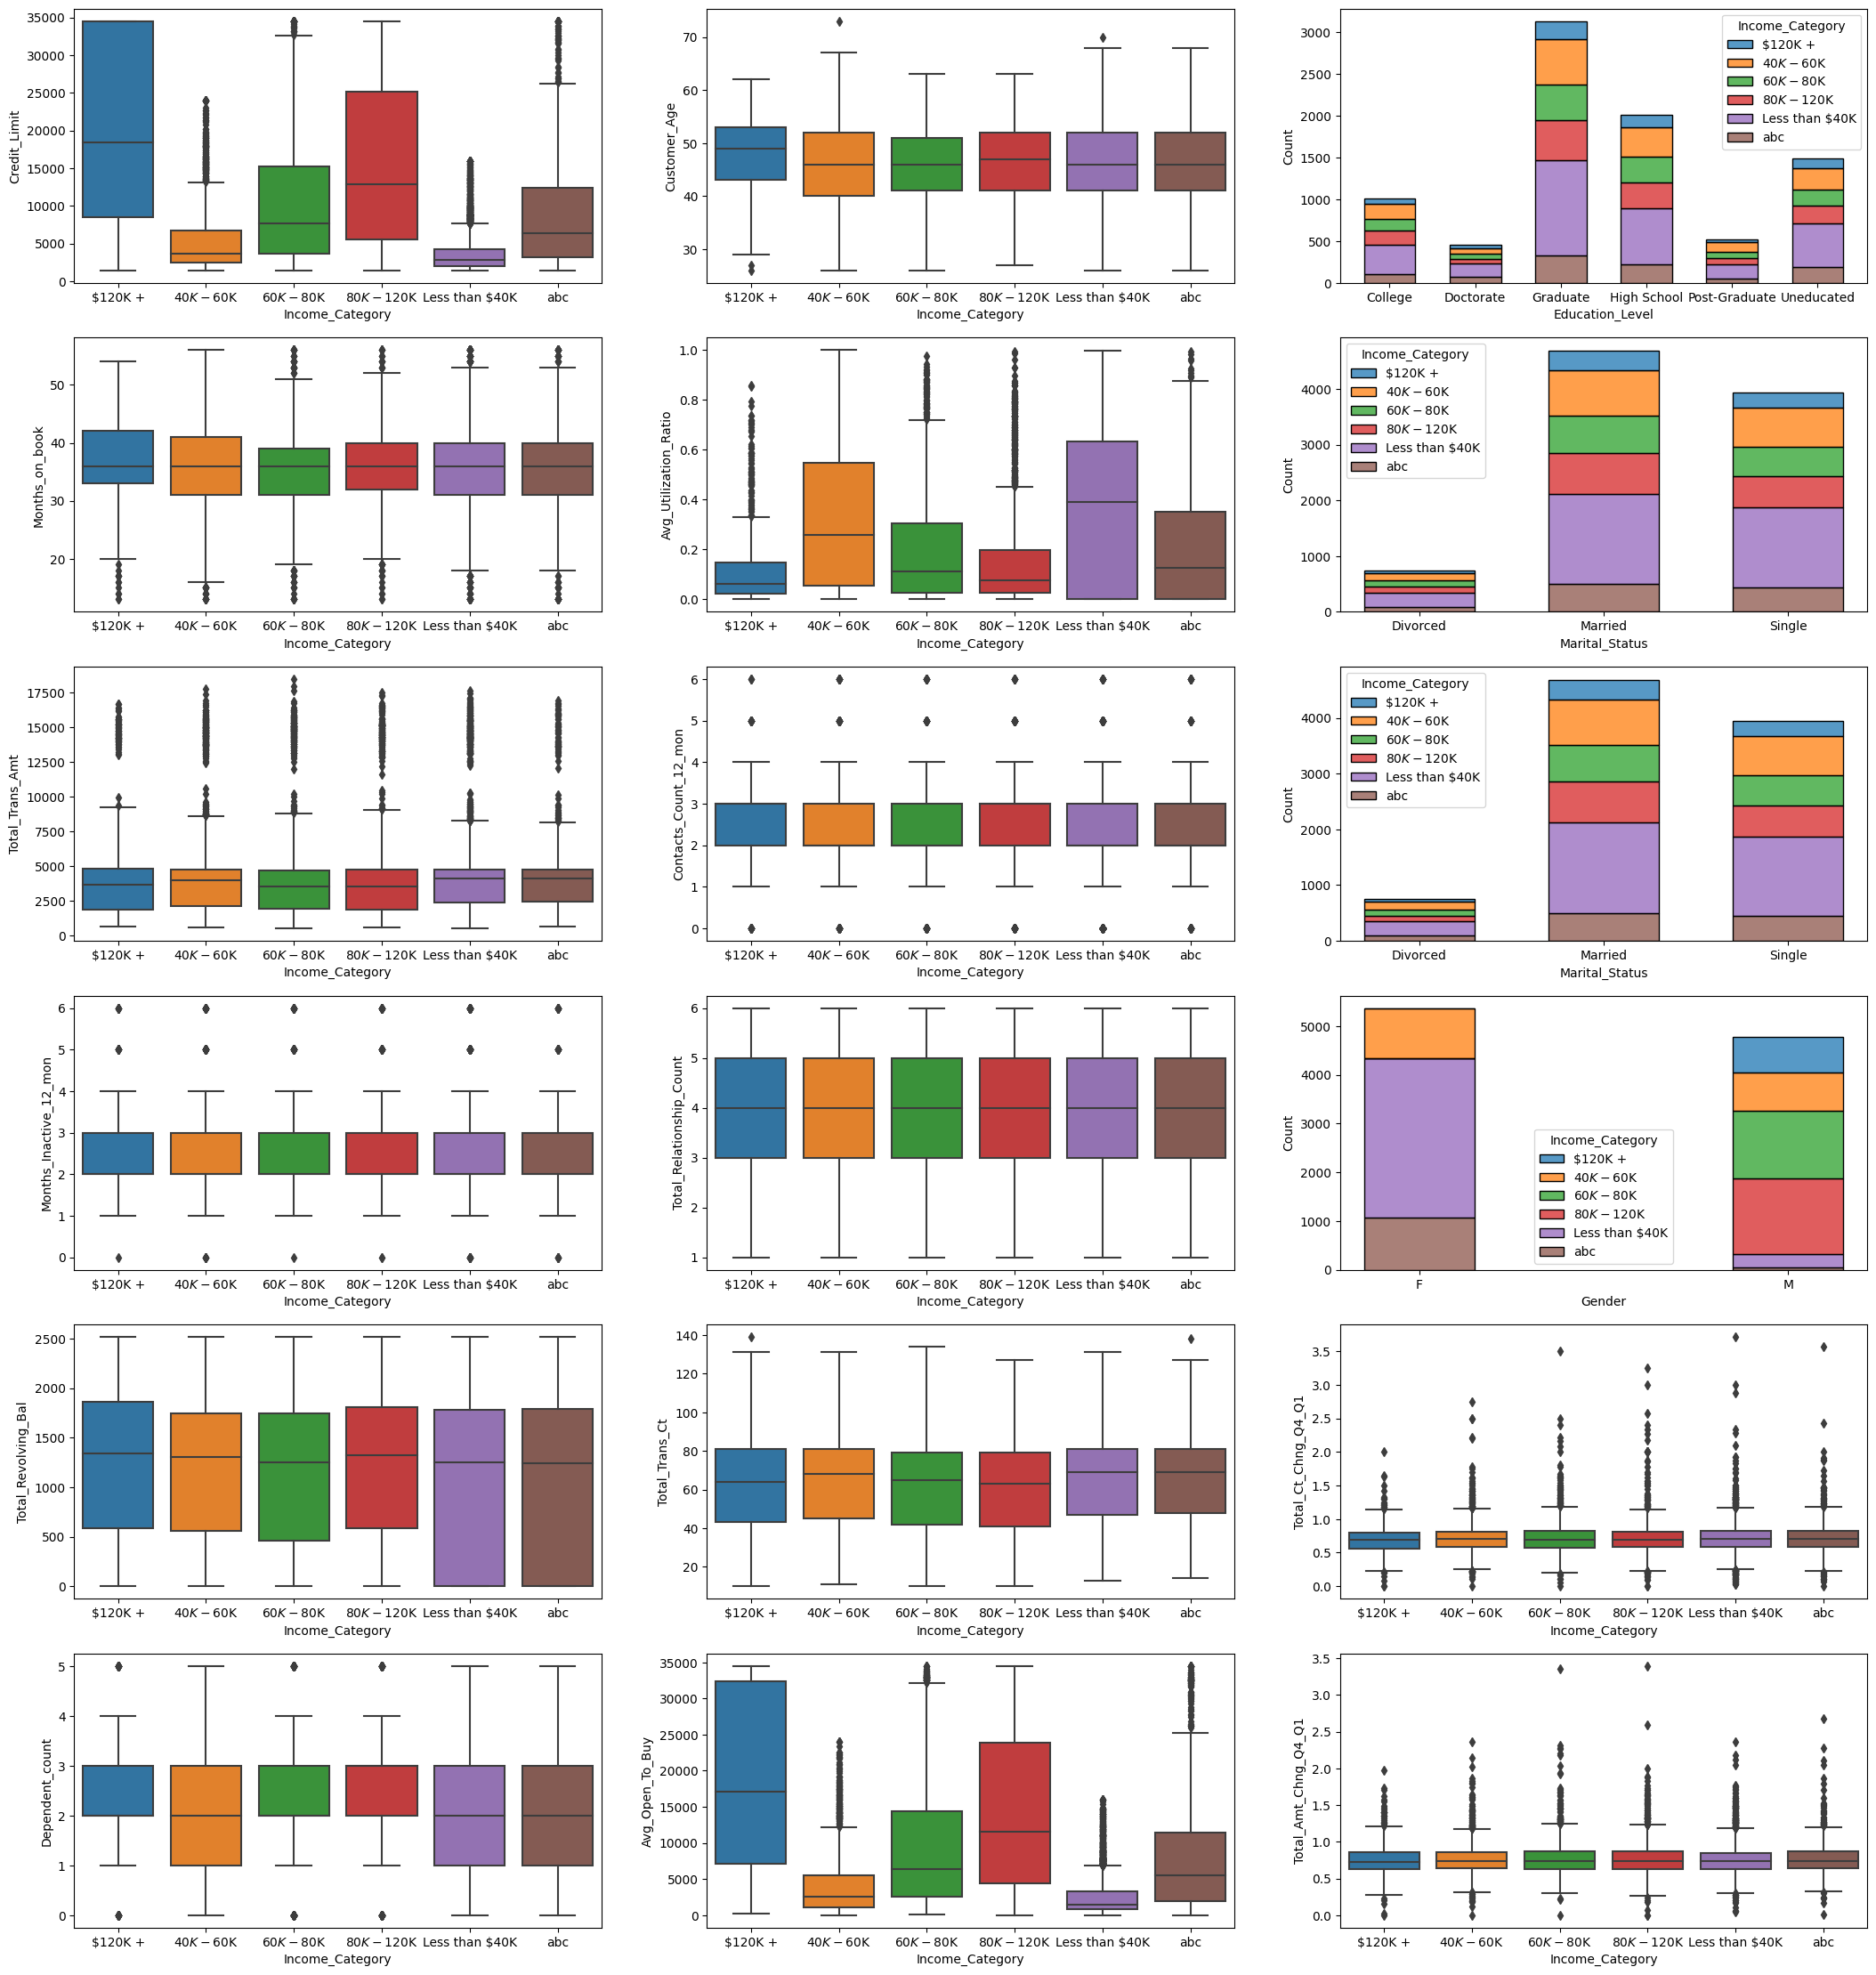

In [53]:
#sns.set(rc={"figure.figsize": (10, 7)})
fig, axes = plt.subplots(6, 3, figsize=(26,28))

sns.boxplot(x="Income_Category", y = "Credit_Limit", data=bc_df, orient="vertical", ax=axes[0,0])
sns.boxplot(x="Income_Category", y = "Customer_Age", data=bc_df, orient="vertical", ax=axes[0,1])
sns.histplot(data=bc_df, x="Education_Level", hue="Income_Category", multiple="stack", shrink=.6, ax=axes[0,2])

sns.boxplot(x="Income_Category", y = "Months_on_book", data=bc_df, orient="vertical", ax=axes[1,0])
sns.boxplot(x="Income_Category", y = "Avg_Utilization_Ratio", data=bc_df, orient="vertical", ax=axes[1,1])
sns.histplot(data=bc_df, x="Marital_Status", hue="Income_Category", multiple="stack", shrink=.6, ax=axes[1,2])

sns.boxplot(x="Income_Category", y = "Total_Trans_Amt", data=bc_df, orient="vertical", ax=axes[2,0])
sns.boxplot(x="Income_Category", y = "Contacts_Count_12_mon", data=bc_df, orient="vertical", ax=axes[2,1])
sns.histplot(data=bc_df, x="Marital_Status", hue="Income_Category", multiple="stack", shrink=.6, ax=axes[2,2])

sns.boxplot(x="Income_Category", y = "Months_Inactive_12_mon", data=bc_df, orient="vertical", ax=axes[3,0])
sns.boxplot(x="Income_Category", y = "Total_Relationship_Count", data=bc_df, orient="vertical", ax=axes[3,1])
sns.histplot(data=bc_df, x="Gender", hue="Income_Category", multiple="stack", shrink=.3, ax=axes[3,2])

sns.boxplot(x="Income_Category", y = "Total_Revolving_Bal", data=bc_df, orient="vertical", ax=axes[4,0])
sns.boxplot(x="Income_Category", y = "Total_Trans_Ct", data=bc_df, orient="vertical", ax=axes[4,1])
sns.boxplot(x="Income_Category", y = "Total_Ct_Chng_Q4_Q1", data=bc_df, orient="vertical", ax=axes[4,2])

sns.boxplot(x="Income_Category", y = "Dependent_count", data=bc_df, orient="vertical", ax=axes[5,0])
sns.boxplot(x="Income_Category", y = "Avg_Open_To_Buy", data=bc_df, orient="vertical", ax=axes[5,1])
sns.boxplot(x="Income_Category", y = "Total_Amt_Chng_Q4_Q1", data=bc_df, orient="vertical", ax=axes[5,2])

- Costumers with larger income had more credit limit.
- Income didn't have an impact on Months_on_book.
- Women comprise the bulk of the lowest income bracket <\$40K.
- Customers with larger income had more available credit.
- We must take care of the 'abc' income bin.

### **Gender vs Attrition**

Attrition_Flag  Attrited Customer  Existing Customer    All
Gender                                                     
All                          1627               8500  10127
F                             930               4428   5358
M                             697               4072   4769
------------------------------------------------------------------------------------------------------------------------


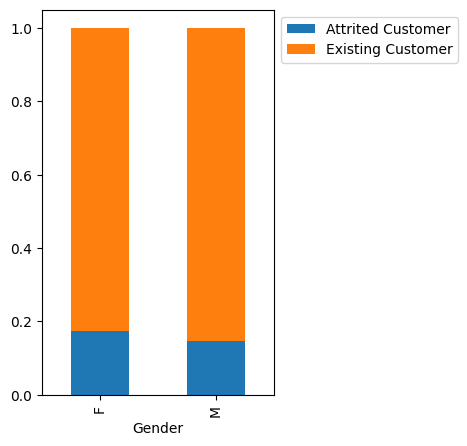

In [54]:
stacked_barplot(bc_df, "Gender", "Attrition_Flag")

- Women represent roughly 53% of customers and represent 9.3% churn (17% of women churn) vs 47% of men representing 7% churn (14.6% of men churn)

### **Education Level vs Attrition**

Attrition_Flag   Attrited Customer  Existing Customer   All
Education_Level                                            
All                           1371               7237  8608
Graduate                       487               2641  3128
High School                    306               1707  2013
Uneducated                     237               1250  1487
College                        154                859  1013
Doctorate                       95                356   451
Post-Graduate                   92                424   516
------------------------------------------------------------------------------------------------------------------------


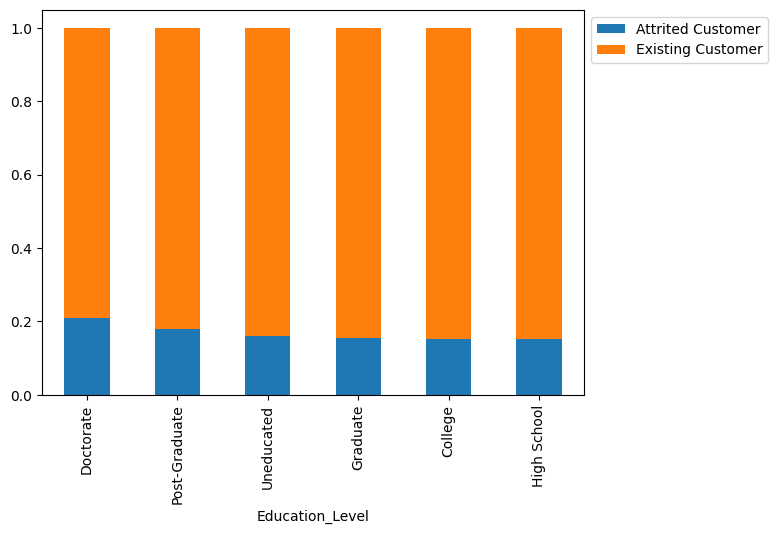

In [55]:
stacked_barplot(bc_df, "Education_Level", "Attrition_Flag")

- The Doctorate bin attrites by 21% however, they represent only 4.6% of the customers.
- Post-graduate bin attrites by 18% but they represent only 5.2% of all customers.
- All other groups attrite by about 15% within their corresponding bins.

### **Marital Status vs Attrition**

Attrition_Flag  Attrited Customer  Existing Customer   All
Marital_Status                                            
All                          1498               7880  9378
Married                       709               3978  4687
Single                        668               3275  3943
Divorced                      121                627   748
------------------------------------------------------------------------------------------------------------------------


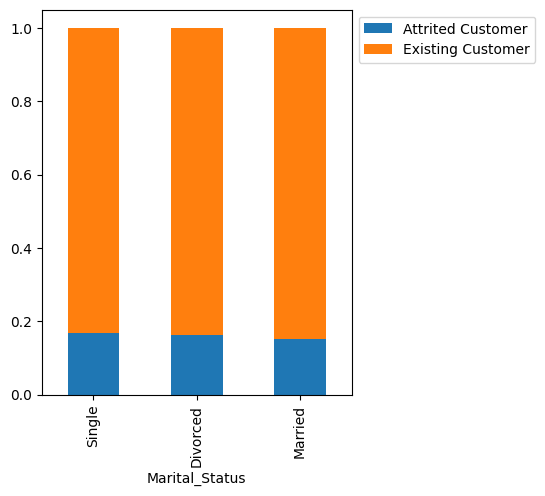

In [56]:
stacked_barplot(bc_df, "Marital_Status", "Attrition_Flag")

- 20% of Divorced customers attrite, although they only represent 7.6% of all customers.
- Single customers attrite by 17%, and Married customers attrited by 15%.

### **Income Category and Attrition**

Attrition_Flag   Attrited Customer  Existing Customer    All
Income_Category                                             
All                           1627               8500  10127
Less than $40K                 612               2949   3561
$40K - $60K                    271               1519   1790
$80K - $120K                   242               1293   1535
$60K - $80K                    189               1213   1402
abc                            187                925   1112
$120K +                        126                601    727
------------------------------------------------------------------------------------------------------------------------


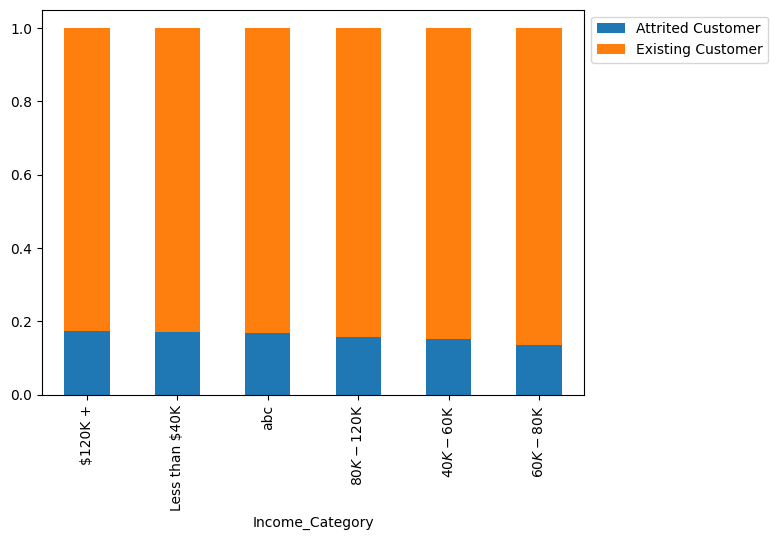

In [57]:
stacked_barplot(bc_df, "Income_Category", "Attrition_Flag")

Notice that the existing bins represent all the Income range, from 0 to more than 120K.

<Axes: xlabel='Income_Category', ylabel='count'>

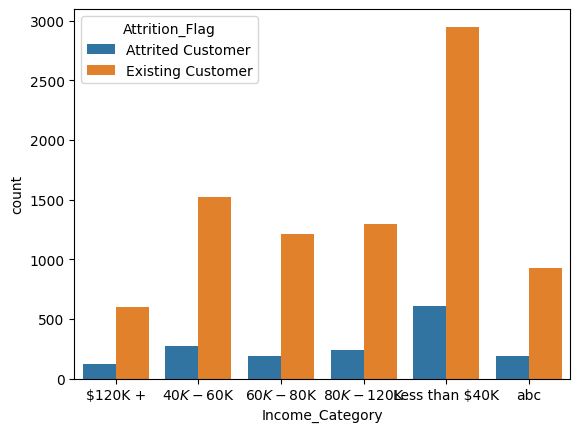

In [58]:
sns.countplot(data=bc_df, x="Income_Category", hue="Attrition_Flag")

How do we handle "abc"?

- Income_Category ==  'abc' represents 11% of all data.
- Lets analyze Income_Category in more detail and see if "abc" is a different Income_Category bin, if it is part of an existing Income_Category bin, or if its a null entry.
- Customers that attrite the most are in the <\$40K bin, representing 6.2% of all customers. Within their own group, 17% attrite.
- Group abc represents 2% of attrition but 21% of customers within the group attrite.
- This relationship must be revisited after 'abc' is handled.

### **Income and Education Level**

Education_Level  College  Doctorate  Graduate  High School  Post-Graduate  \
Income_Category                                                             
All                 1013        451      3128         2013            516   
Less than $40K       345        158      1139          671            170   
$40K - $60K          183         70       553          355            111   
abc                  108         70       332          225             47   
$60K - $80K          132         59       422          307             77   
$80K - $120K         175         57       478          308             81   
$120K +               70         37       204          147             30   

Education_Level  Uneducated   All  
Income_Category                    
All                    1487  8608  
Less than $40K          522  3005  
$40K - $60K             249  1521  
abc                     185   967  
$60K - $80K             195  1192  
$80K - $120K            217  1316  
$120K +           

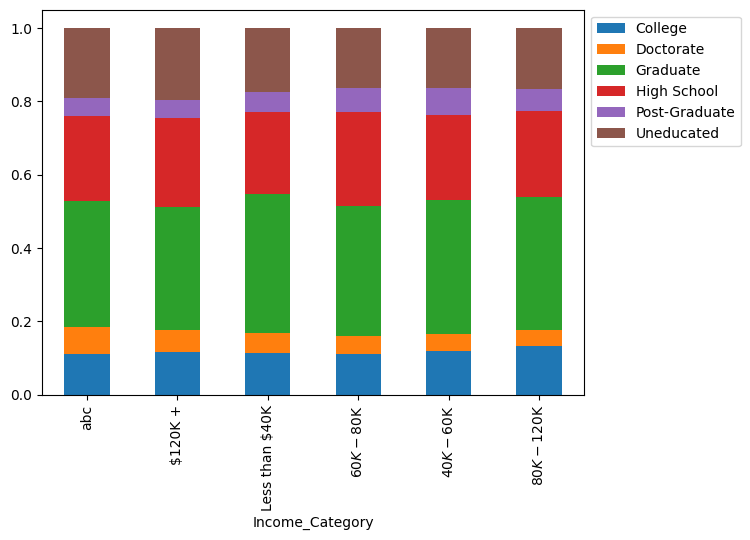

In [59]:
stacked_barplot(bc_df, "Income_Category", "Education_Level")

Looking at the stacked bars, we determine that Graduate level is lower than High School but higher than Uneducated. So graduate must refer to graduates from junior high or similar.

Uneducated < Graduate < High School < College < Post-Graduate < Doctorate

We analyzed education_level earlier.

In [60]:
bc_df[bc_df["Income_Category"] == "abc"]["Education_Level"].value_counts()

Graduate         332
High School      225
Uneducated       185
College          108
Doctorate         70
Post-Graduate     47
Name: Education_Level, dtype: int64

In [61]:
bc_df.Income_Category.value_counts()

Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
abc               1112
$120K +            727
Name: Income_Category, dtype: int64

### **Income Category vs Others**

<Axes: xlabel='Marital_Status', ylabel='count'>

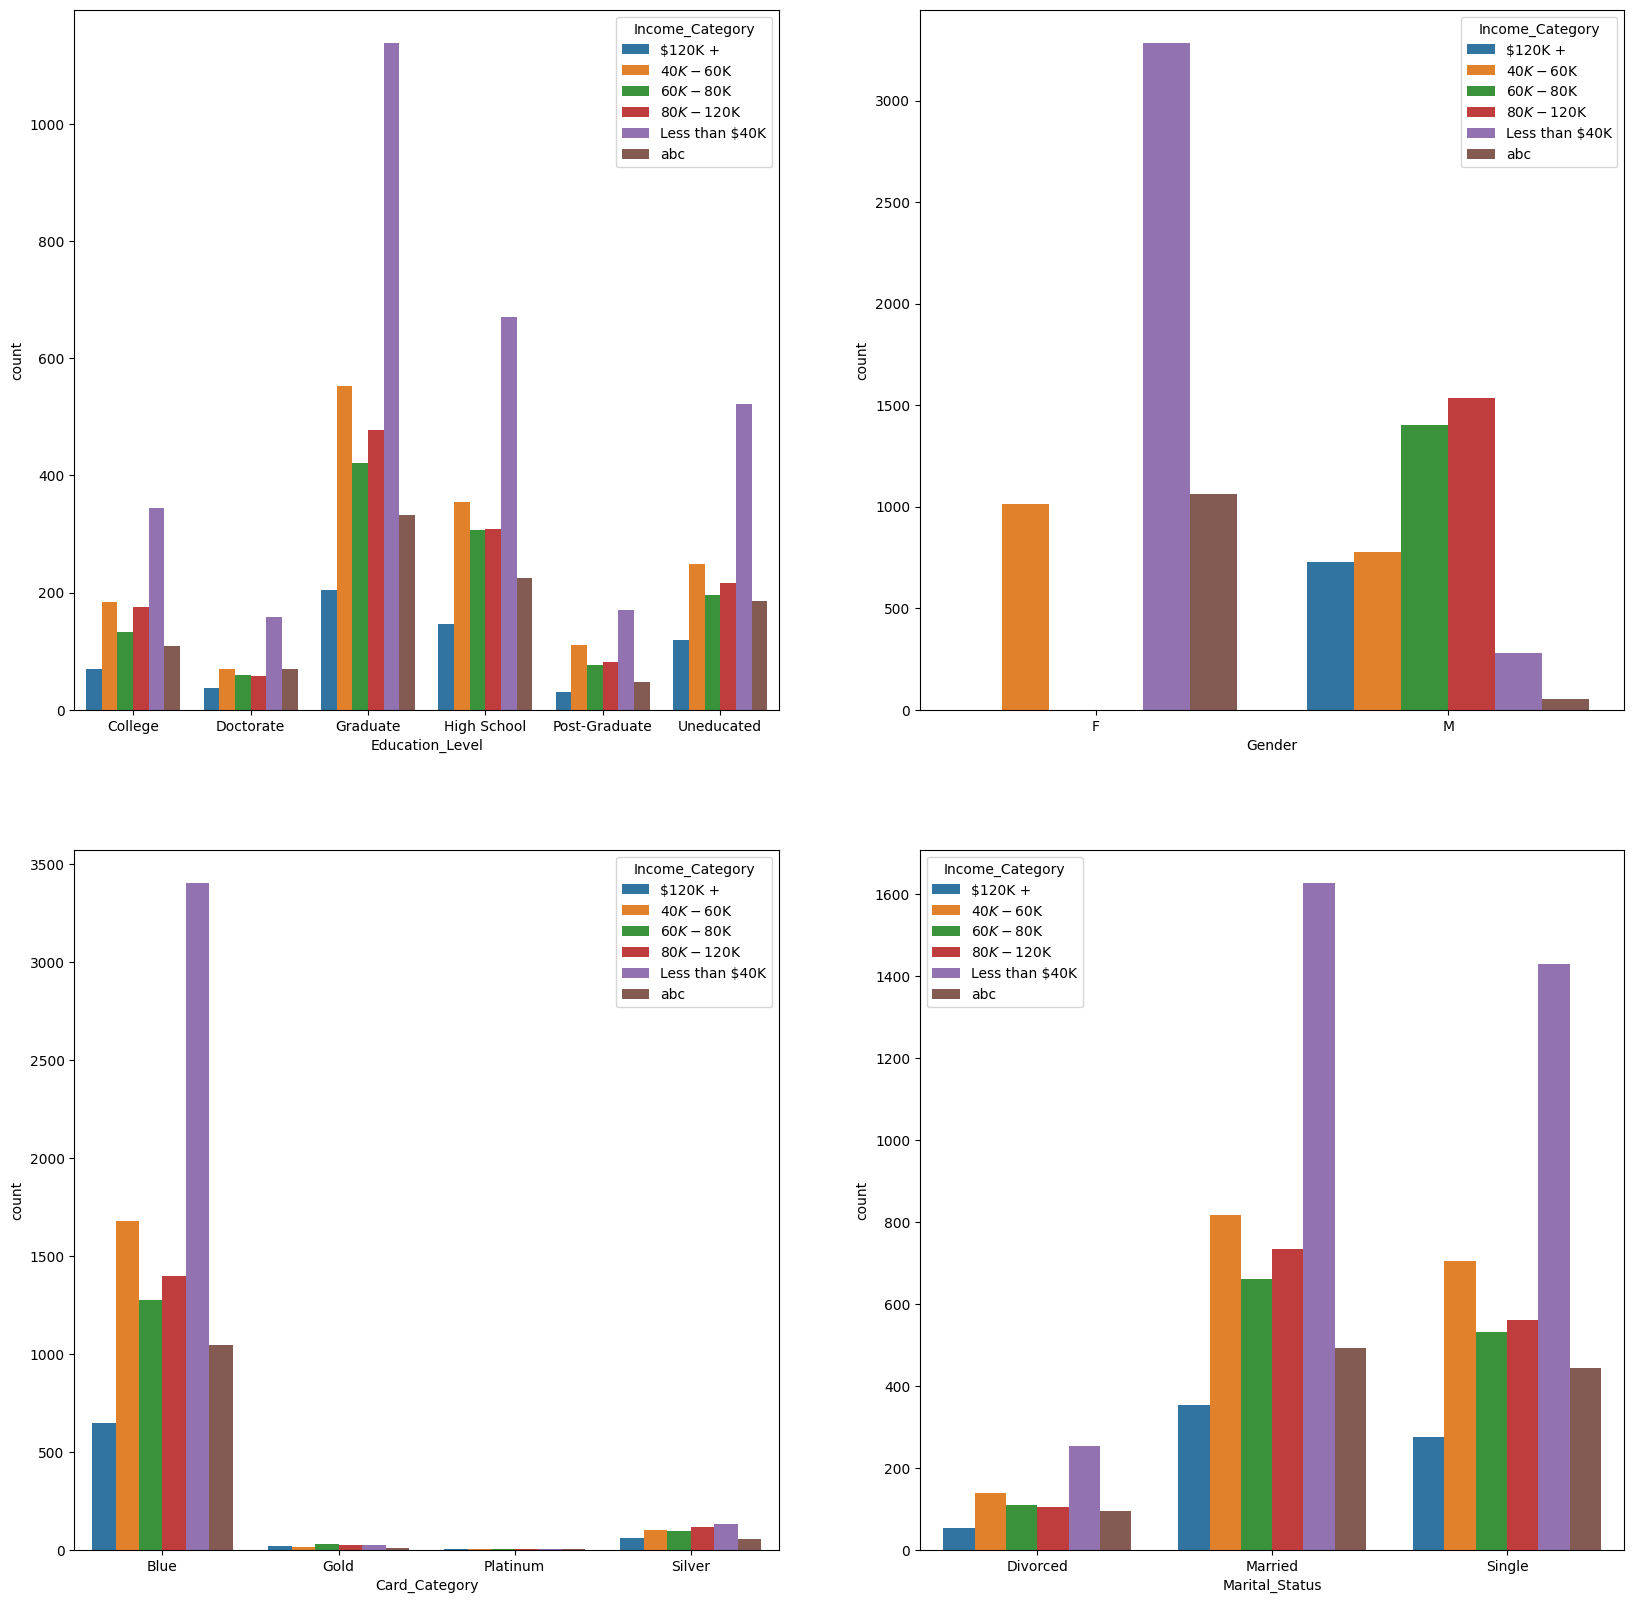

In [62]:
#set seaborn plotting aesthetics as default
#sns.set()

#define plotting region (3 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(20,20))

#create boxplot in each subplot
sns.countplot(data=bc_df, hue='Income_Category', x='Education_Level', ax=axes[0,0])
sns.countplot(data=bc_df, hue='Income_Category', x='Gender', ax=axes[0,1])
sns.countplot(data=bc_df, hue='Income_Category', x='Card_Category', ax=axes[1,0])
sns.countplot(data=bc_df, hue='Income_Category', x='Marital_Status', ax=axes[1,1])

Attrited customers seem to be similar among all Income Categories.

Education_Level  College  Doctorate  Graduate  High School  Post-Graduate  \
Income_Category                                                             
All                 1013        451      3128         2013            516   
Less than $40K       345        158      1139          671            170   
$40K - $60K          183         70       553          355            111   
abc                  108         70       332          225             47   
$60K - $80K          132         59       422          307             77   
$80K - $120K         175         57       478          308             81   
$120K +               70         37       204          147             30   

Education_Level  Uneducated   All  
Income_Category                    
All                    1487  8608  
Less than $40K          522  3005  
$40K - $60K             249  1521  
abc                     185   967  
$60K - $80K             195  1192  
$80K - $120K            217  1316  
$120K +           

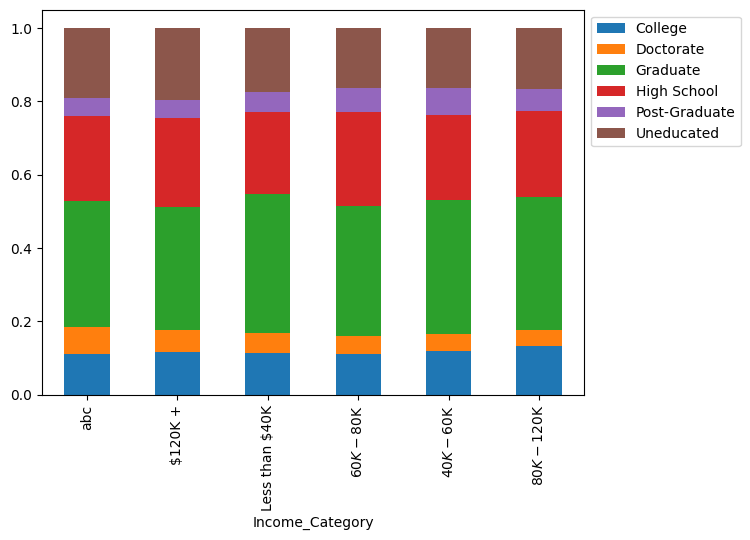

In [63]:
#income_category and education
stacked_barplot(bc_df, "Income_Category", "Education_Level")

## **Initial Data Findings**

- The top priority is to handle the "Income_Level" == 'abc'.
- We will keep all outliers because they most likely represent real data. The most relevant outliers are age and credit limit.
- We wonder where this dataset takes place. Understanding where the data was collected is very useful so the proper data pre-processing and recommendations may be done. However, the data description does not provide such information. Never the less, the data does not belong to the US for several reasons like the minimum age of customers which doesn't match up with the US reality.

## **Model evaluation criterion**



**<h3>The Target</h3>**

The target is now "Existing Customer": 1 for Yes, 0 for No. No, means "Attrited Customer".  We want to predict "Attrited Customer", so we want to actually find out accounts that are classified as 0.

So:
FP : Predicts 'Existing Customer' but actually is 'Attrited Customer'
FN : Predicts 'Attrited Customer' but actually is 'Existing Customer'
TP : Predicts 'Existing Customer' correctly
TN : Predicts 'Attrited Customer' correctly


**<h3>What is the most expensive?</h3>**

The most expensive are customers that we predict as "Existing Customers" but they are actually "Attrited Customer'.

If an "Existing Customer" is predicted as 1, then we will not invest resources in that customer. However not doing so will result in an "Attrited Customer" and thus the bank will have revenue loss.

**<h3>What should we reduce?</h3>**

We want to reduce the number of 'Attrited Customers'. We want to predict 'Attrited Customers' correctly so we can take action so they keep the credit card, thus maximizing the bank's revenue.

**We want to minimize False Positives or Maximize True Negatives.**

To minimize FP, we want to maximize **Precision**. We also will consider Accuracy to improve the predictions of TP and TN. We can also consider maximazing the F1 score, as this will increase the probability of predicting 'Existing Customer' (1) and 'Attrited Customer' (0) correctly.

# **Data Preparation**

### **Splitting datasets, Data imputation, Hot encoding, and avoiding Data Leakage.**

In [64]:
#lets separate the Target
X = bc_df.drop(["Attrition_Flag"], axis=1)
y = bc_df["Attrition_Flag"]

In [65]:
# Splitting data into training, validation and test sets:
# first we split data into 2 parts, say temporary and test

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

# then we split the temporary set into train and validation

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=1, stratify=y_temp
)
print(X_train.shape, X_val.shape, X_test.shape)

(6075, 19) (2026, 19) (2026, 19)


To minimize data leakage, we are normalizing the data aafter the data was split.

In [66]:
# Let's impute the missing values
imp_mode = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
cols_to_impute = ["Education_Level", "Marital_Status"]

# fit and transform the imputer on train data
X_train[cols_to_impute] = imp_mode.fit_transform(X_train[cols_to_impute])

# Transform on validation and test data
X_val[cols_to_impute] = imp_mode.transform(X_val[cols_to_impute])

# fit and transform the imputer on test data
X_test[cols_to_impute] = imp_mode.transform(X_test[cols_to_impute])

In [67]:
# Creating dummy variables for categorical variables
X_train = pd.get_dummies(data=X_train, drop_first=True)
X_val = pd.get_dummies(data=X_val, drop_first=True)
X_test = pd.get_dummies(data=X_test, drop_first=True)

In [68]:
# Create dummy variables for the target
y_train = pd.get_dummies(data=y_train, drop_first=True)
y_val = pd.get_dummies(data=y_val, drop_first=True)
y_test = pd.get_dummies(data=y_test, drop_first=True)

The Attrition_Flag is now "Existing Customer", being 1 for current customers, and 0 for churn customers.

In [69]:
# Checking class balance for whole data, train set, validation set, and test set

print("Target value ratio in y")
print(y.value_counts())
print("*" * 80)
print("Target value ratio in y_train")
print(y_train.value_counts())
print("*" * 80)
print("Target value ratio in y_val")
print(y_val.value_counts())
print("*" * 80)
print("Target value ratio in y_test")
print(y_test.value_counts())
print("*" * 80)

Target value ratio in y
Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64
********************************************************************************
Target value ratio in y_train
Existing Customer
1                    5099
0                     976
dtype: int64
********************************************************************************
Target value ratio in y_val
Existing Customer
1                    1700
0                     326
dtype: int64
********************************************************************************
Target value ratio in y_test
Existing Customer
1                    1701
0                     325
dtype: int64
********************************************************************************


### **Oversampling the train Data**

In [70]:
# Fit SMOTE on train data(Synthetic Minority Oversampling Technique)
sm = SMOTE(sampling_strategy=0.4, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

In [71]:
print("Before oversampling")
y_train.value_counts()

Before oversampling


Existing Customer
1                    5099
0                     976
dtype: int64

In [72]:
print("Atfer oversampling")
y_train_over.value_counts()

Atfer oversampling


Existing Customer
1                    5099
0                    2039
dtype: int64

In [73]:
print("After OverSampling, the shape of train_X: {}".format(X_train_over.shape))
print("After OverSampling, the shape of train_y: {} \n".format(y_train_over.shape))

After OverSampling, the shape of train_X: (7138, 30)
After OverSampling, the shape of train_y: (7138, 1) 



### **Undersampling the Train Data using Random Undersampler**

In [74]:
# fit random under sampler on the train data
rus = RandomUnderSampler(random_state=1, sampling_strategy = 1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [75]:
print("Before undersampling")
y_train.value_counts()

Before undersampling


Existing Customer
1                    5099
0                     976
dtype: int64

In [76]:
print("After undersampling")
y_train_un.value_counts()

After undersampling


Existing Customer
0                    976
1                    976
dtype: int64

In [77]:
print("After Under Sampling, the shape of train_X: {}".format(X_train_un.shape))
print("After Under Sampling, the shape of train_y: {} \n".format(y_train_un.shape))

After Under Sampling, the shape of train_X: (1952, 30)
After Under Sampling, the shape of train_y: (1952, 1) 



# **Classification Models**

## **General Performance Evaluation**

In [78]:
models = []  # Empty list to store all the models

# Appending models into the list

models.append(("Logistic Regression", LogisticRegression(random_state=1)))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models
score = []
# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Performance:" "\n")
for name, model in models:
    scoring = "precision"
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scoring, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean() * 100))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = precision_score(y_val, model.predict(X_val))
    score.append(scores)
    print("{}: {}".format(name, scores))



Cross-Validation Performance:

Logistic Regression: 90.17490630894474
dtree: 95.89995163015551
Bagging: 96.99390931603207
Random forest: 96.00084503677743
GBM: 96.88848732159421
Adaboost: 96.80752339299595
Xgboost: 97.48565989724435

Validation Performance:

Logistic Regression: 0.8934426229508197
dtree: 0.9562171628721541
Bagging: 0.9651770168311086
Random forest: 0.9516770892552586
GBM: 0.9660529344073648
Adaboost: 0.9647602541883304
Xgboost: 0.974477958236659


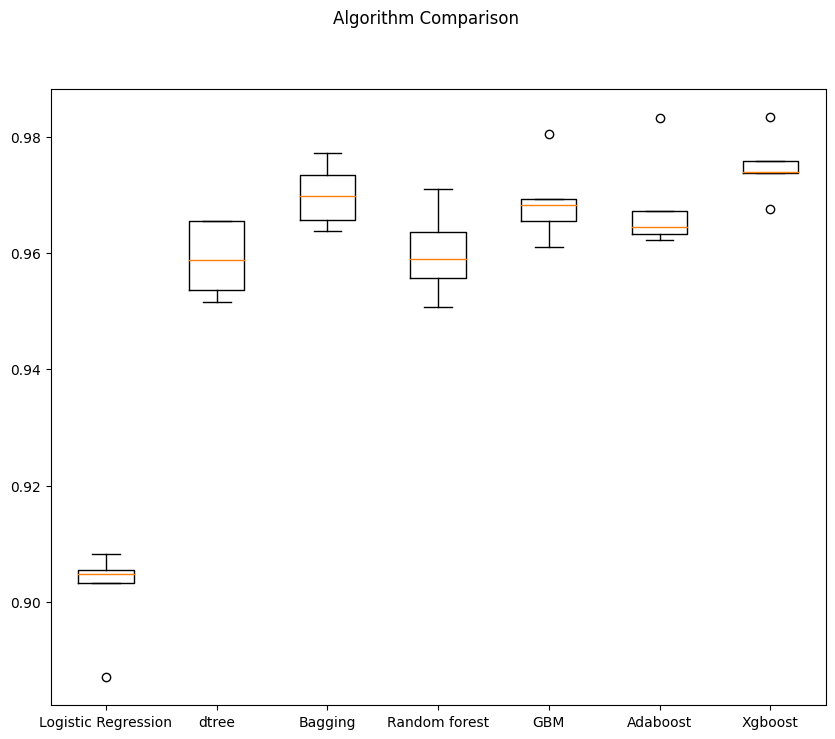

In [79]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10,8))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results)
ax.set_xticklabels(names)

plt.show()

- XGboost, Adaboost, GBM, and Bagging yoeld the best performance.

- Logistic Regression performs the worse (0.9-0.91), and Decision Tree and Random Forest are good (0.95-0.96) but worse than the 4 algorithms mentioned above.

- Next we will build the models and later try hyperparameter tuning.

## **Logistic Regression**

Notice that Logistic Regression has the lowest cross-validation Precision of all the considered models.

### **Logistic Regression Classifier with Standard Train Data**

In [80]:
# The newton-cg solver is faster for high-dimensional data
lg = LogisticRegression(solver="newton-cg", random_state=1)
lg_estimator = lg.fit(X_train, y_train)

**Performance on Training Set**

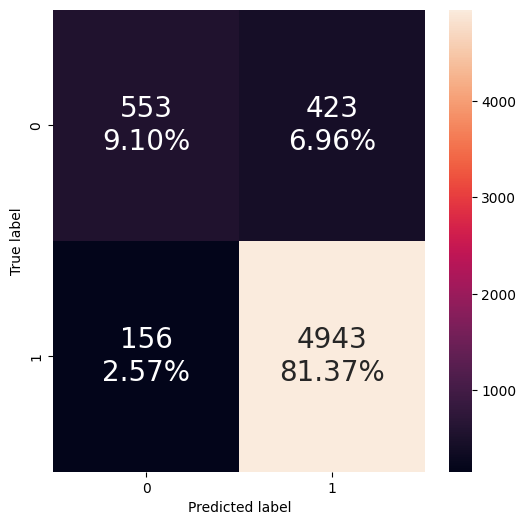

In [81]:
# creating confusion matrix
confusion_matrix_sklearn(lg_estimator, X_train, y_train)


In [82]:
lg_estimator_model_train_perf = model_performance_classification_sklearn(
    lg_estimator, X_train, y_train
)

print("Training performance:")
lg_estimator_model_train_perf

Training performance:


Accuracy    Recall  Precision        F1
0  0.904691  0.969406    0.92117  0.944673

Performance on Testing Set

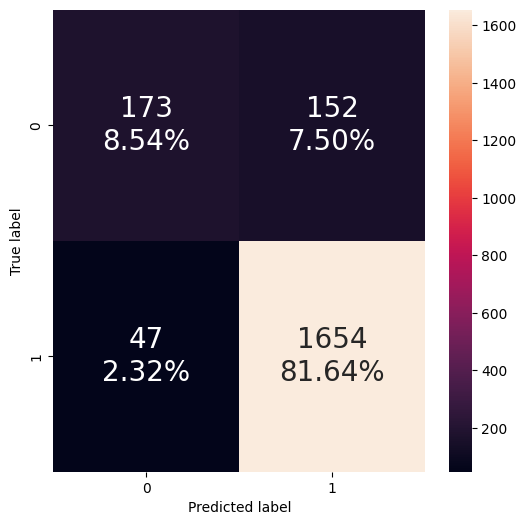

In [83]:
confusion_matrix_sklearn(lg_estimator, X_test, y_test)

In [84]:
lg_estimator_model_test_perf = model_performance_classification_sklearn(
    lg_estimator, X_test, y_test
)

print("Test set performance:")
lg_estimator_model_test_perf

Test set performance:


Accuracy    Recall  Precision        F1
0  0.901777  0.972369   0.915836  0.943256

**Check Performance on Validation Set**

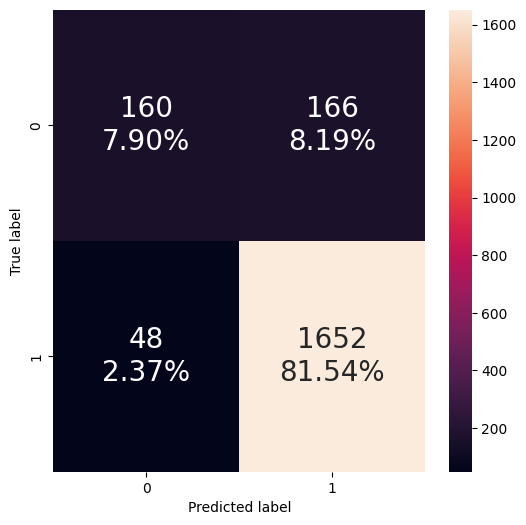

In [85]:
# creating confusion matrix
confusion_matrix_sklearn(lg_estimator, X_val, y_val)

In [86]:
lg_estimator_model_val_perf = model_performance_classification_sklearn(
    lg_estimator, X_val, y_val
)

print("Val set performance:")
lg_estimator_model_val_perf

Val set performance:


Accuracy    Recall  Precision       F1
0  0.894373  0.971765   0.908691  0.93917

**Logistic Regression Performance Summary Normal Train Data**

In [87]:
#merge dataframes containing scores
lg_results_temp = lg_estimator_model_train_perf.merge(lg_estimator_model_test_perf, how =  'outer')
lg_results = lg_results_temp.merge(lg_estimator_model_val_perf, how='outer')
index= pd.Index(['train','test','val'])
lg_results=lg_results.set_index(index)
lg_results

Accuracy    Recall  Precision        F1
train  0.904691  0.969406   0.921170  0.944673
test   0.901777  0.972369   0.915836  0.943256
val    0.894373  0.971765   0.908691  0.939170

The Precision of the Training set is 0.923091, for the Testing set is 0.917732 and 0.909642 for validation.  

### **Logistic Regression with Oversampled Train Data**

In [88]:
# The newton-cg solver is faster for high-dimensional data
lg_over = LogisticRegression(solver="newton-cg", random_state=1)
lg_estimator_over = lg_over.fit(X_train_over, y_train_over)

**Check Performance on Training Set**

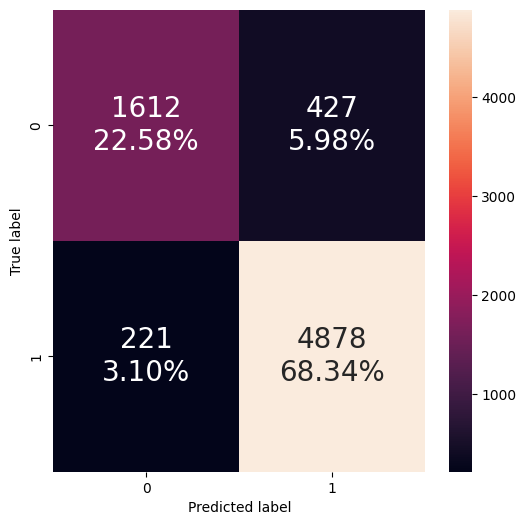

In [89]:
# creating confusion matrix
confusion_matrix_sklearn(lg_estimator_over, X_train_over, y_train_over)

In [90]:
lg_estimator_model_train_perf_over = model_performance_classification_sklearn(
    lg_estimator_over, X_train_over, y_train_over
)

print("Training performance:")
lg_estimator_model_train_perf_over

Training performance:


Accuracy    Recall  Precision        F1
0  0.909218  0.956658    0.91951  0.937716

**Check Performance on Test Set**

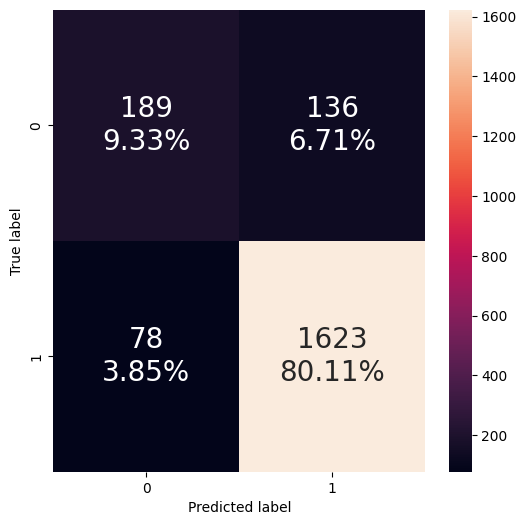

In [91]:
confusion_matrix_sklearn(lg_estimator_over, X_test, y_test)

In [92]:
lg_estimator_model_test_perf_over = model_performance_classification_sklearn(
    lg_estimator_over, X_test, y_test
)

print("Test set performance:")
lg_estimator_model_test_perf_over

Test set performance:


Accuracy    Recall  Precision       F1
0  0.894373  0.954145   0.922683  0.93815

**Check Performance on Validation Set**

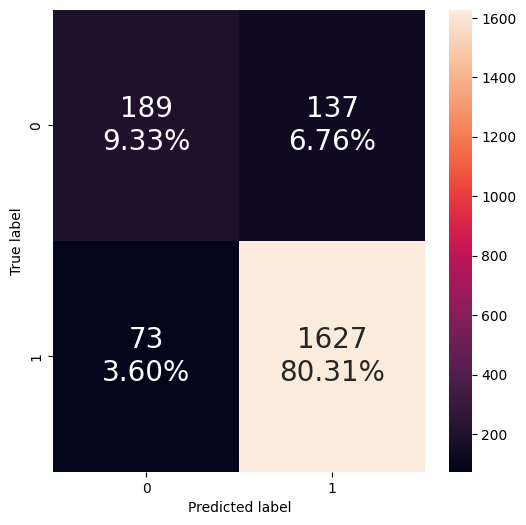

In [93]:
confusion_matrix_sklearn(lg_estimator_over, X_val, y_val)

In [94]:
lg_estimator_model_val_perf_over = model_performance_classification_sklearn(
    lg_estimator_over, X_val, y_val
)

print("Val set performance:")
lg_estimator_model_val_perf_over

Val set performance:


Accuracy    Recall  Precision        F1
0  0.896347  0.957059   0.922336  0.939376

**Logistic Regression Performance Summary Oversampled Train Data**

In [95]:
#merge dataframes containing scores
lg_results_temp_over = lg_estimator_model_train_perf_over.merge(lg_estimator_model_test_perf_over, how =  'outer')
lg_results_over = lg_results_temp_over.merge(lg_estimator_model_val_perf_over, how='outer')
index= pd.Index(['train','test','val'])
lg_results_over=lg_results_over.set_index(index)
lg_results_over

Accuracy    Recall  Precision        F1
train  0.909218  0.956658   0.919510  0.937716
test   0.894373  0.954145   0.922683  0.938150
val    0.896347  0.957059   0.922336  0.939376

Precision in validation is very similar to Precision in training set.

### **Logistic Regression with Undersampled Train Data**

In [96]:
# The newton-cg solver is faster for high-dimensional data
lg_un = LogisticRegression(solver="newton-cg", random_state=1)
lg_estimator_un = lg_un.fit(X_train_un, y_train_un)

**Check Performance on Train Set with Undersampled Train Data**

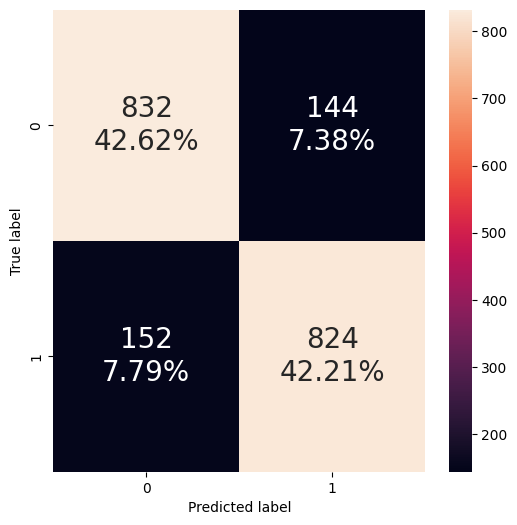

In [97]:
# creating confusion matrix
confusion_matrix_sklearn(lg_estimator_un, X_train_un, y_train_un)

In [98]:
lg_estimator_model_train_perf_un = model_performance_classification_sklearn(
    lg_estimator_un, X_train_un, y_train_un
)

print("Train set performance:")
lg_estimator_model_train_perf_un

Train set performance:


Accuracy    Recall  Precision        F1
0  0.848361  0.844262    0.85124  0.847737

**Check Performance on Test Set with Undersampled Train Data**

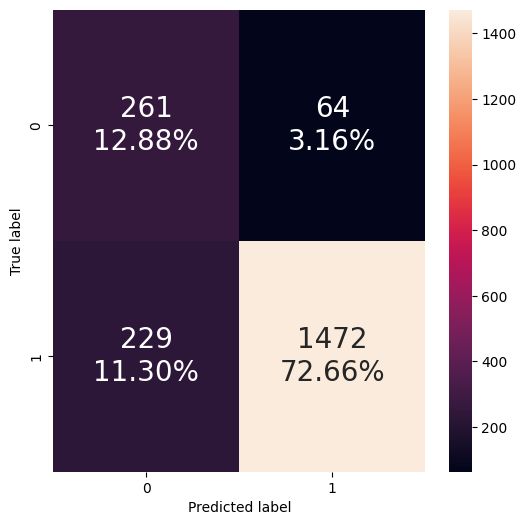

In [99]:
# creating confusion matrix
confusion_matrix_sklearn(lg_estimator_un, X_test, y_test)

In [100]:
lg_estimator_model_test_perf_un = model_performance_classification_sklearn(
    lg_estimator_un, X_test, y_test
)

print("Test set performance:")
lg_estimator_model_test_perf_un

Test set performance:


Accuracy    Recall  Precision        F1
0   0.85538  0.865373   0.958333  0.909484

**Check Performance on Validation Set with UnderSampled Train Data**

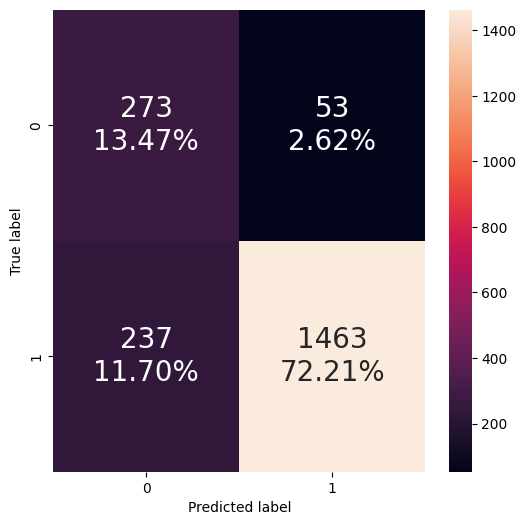

In [101]:
# creating confusion matrix
confusion_matrix_sklearn(lg_estimator_un, X_val, y_val)

In [102]:
lg_estimator_model_val_perf_un = model_performance_classification_sklearn(
    lg_estimator_un, X_val, y_val
)

print("Val set performance:")
lg_estimator_model_val_perf_un

Val set performance:


Accuracy    Recall  Precision        F1
0  0.856861  0.860588    0.96504  0.909826

**Logistic Regression Performance Summary Undersampled Train Data**

In [103]:
#merge dataframes containing scores
lg_results_temp_un = lg_estimator_model_train_perf_un.merge(lg_estimator_model_test_perf_un, how =  'outer')
lg_results_un = lg_results_temp_un.merge(lg_estimator_model_val_perf_over, how='outer')
index= pd.Index(['train','test','val'])
lg_results_un=lg_results_un.set_index(index)
lg_results_un

Accuracy    Recall  Precision        F1
train  0.848361  0.844262   0.851240  0.847737
test   0.855380  0.865373   0.958333  0.909484
val    0.896347  0.957059   0.922336  0.939376

Precision is higher for undersampled train data. However, notice that the precision is 0.851 for the train set and 0.958 for the test set, and this may indicate overfitting.  

Also notice that the validation precision is even higher at 0.965.

###**Logistic Regression Performance Summary**

In [104]:
#merge dataframes containing scores for Training
print("Training Performance")
lg_results_temp_train_all = lg_estimator_model_train_perf.merge(lg_estimator_model_train_perf_over, how =  'outer')
lg_results_train_all = lg_results_temp_train_all.merge(lg_estimator_model_train_perf_un, how='outer')
index= pd.Index(['Normal','Over','Under'])
lg_results_train_all=lg_results_train_all.set_index(index)
lg_results_train_all

Training Performance


Accuracy    Recall  Precision        F1
Normal  0.904691  0.969406    0.92117  0.944673
Over    0.909218  0.956658    0.91951  0.937716
Under   0.848361  0.844262    0.85124  0.847737

Normal Train data set maximizes Precision o nthe Training set.

In [105]:
#merge dataframes containing scores for Testing
print("Testing Performance")
lg_results_temp_test_all = lg_estimator_model_test_perf.merge(lg_estimator_model_test_perf_over, how =  'outer')
lg_results_test_all = lg_results_temp_test_all.merge(lg_estimator_model_test_perf_un, how='outer')
index= pd.Index(['Normal','Over','Under'])
lg_results_test_all=lg_results_test_all.set_index(index)
lg_results_test_all

Testing Performance


Accuracy    Recall  Precision        F1
Normal  0.901777  0.972369   0.915836  0.943256
Over    0.894373  0.954145   0.922683  0.938150
Under   0.855380  0.865373   0.958333  0.909484

Undersampled Train Data maximizes Precision on the Testing set.

In [106]:
#merge dataframes containing scores for Validation
print("Validation Performance")
lg_results_temp_val_all = lg_estimator_model_val_perf.merge(lg_estimator_model_val_perf_over, how =  'outer')
lg_results_val_all = lg_results_temp_val_all.merge(lg_estimator_model_val_perf_un, how='outer')
index= pd.Index(['Normal','Over','Under'])
lg_results_val_all=lg_results_val_all.set_index(index)
lg_results_val_all

Validation Performance


Accuracy    Recall  Precision        F1
Normal  0.894373  0.971765   0.908691  0.939170
Over    0.896347  0.957059   0.922336  0.939376
Under   0.856861  0.860588   0.965040  0.909826

Undersampled Train Data maximized Precison on the validation set.

If we would choose Logistic Regression we would select the model with Undersampled train data because it consistently maximizes Precision.

## **Decision Tree Classifier Model**

The cross-validation performance of the Decision Tree algorithm was among the lowest among all the algorithms considered.

###**Decision Tree Classifier with Normal Train Data**

In [107]:
#Fit the Decision tree model
dt = DecisionTreeClassifier(criterion='gini',random_state=1);
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

**Performance on Training Set**

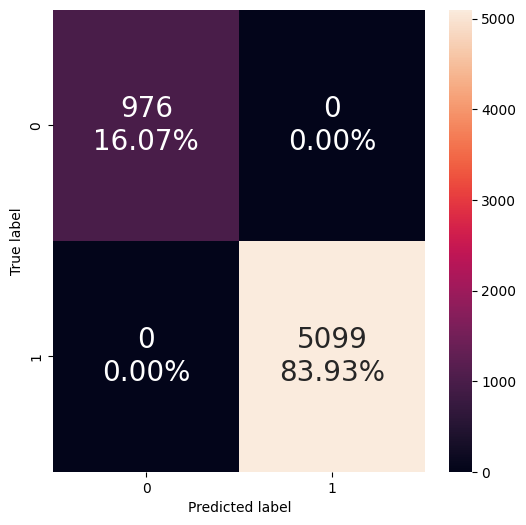

In [108]:
#Confusion matrix for training
confusion_matrix_sklearn(dt, X_train, y_train)

In [109]:
print("Training Performance")
decision_tree_perf_train = model_performance_classification_sklearn(
    dt, X_train, y_train)
decision_tree_perf_train

Training Performance


Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0

**Performance on Testing Set**

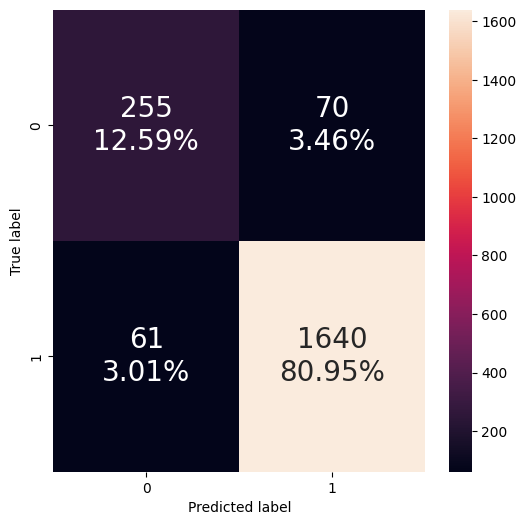

In [110]:
#Confusion matrix for testing
confusion_matrix_sklearn(dt, X_test, y_test)

In [111]:
print("Testing Performance")
decision_tree_perf_test = model_performance_classification_sklearn(
    dt, X_test, y_test)
decision_tree_perf_test

Testing Performance


Accuracy    Recall  Precision        F1
0  0.935341  0.964139   0.959064  0.961595

**Performance on Validation Set**

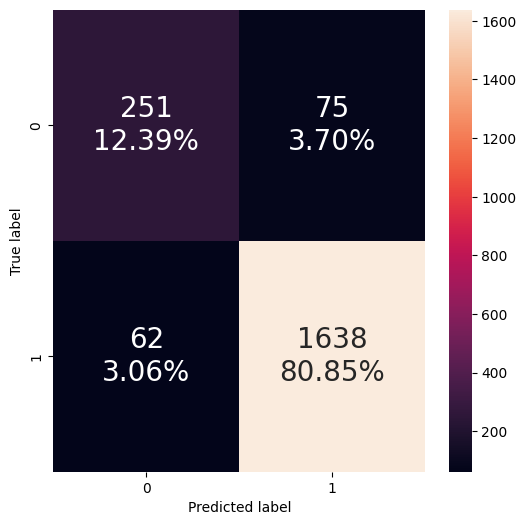

In [112]:
confusion_matrix_sklearn(dt, X_val, y_val)

In [113]:
print("Validation Performance")
decision_tree_perf_val = model_performance_classification_sklearn(
    dt, X_val, y_val)
decision_tree_perf_val

Validation Performance


Accuracy    Recall  Precision        F1
0  0.932379  0.963529   0.956217  0.959859

**Decision Tree Performance Summary with Normal Train Data**

In [114]:
#merge dataframes containing scores
print("Normal Train Data")
dt_results_temp = decision_tree_perf_train.merge(decision_tree_perf_test, how =  'outer')
dt_results = dt_results_temp.merge(decision_tree_perf_val, how='outer')
index= pd.Index(['train','test','val'])
dt_results=dt_results.set_index(index)
dt_results

Normal Train Data


Accuracy    Recall  Precision        F1
train  1.000000  1.000000   1.000000  1.000000
test   0.935341  0.964139   0.959064  0.961595
val    0.932379  0.963529   0.956217  0.959859

### **Decision Tree Classifier with Oversampled Train Data**

In [115]:
#Fit the Decision tree model
dt_over = DecisionTreeClassifier(criterion='gini',random_state=1);
dt_over.fit(X_train_over, y_train_over)

DecisionTreeClassifier(random_state=1)

**Performance of Train set**

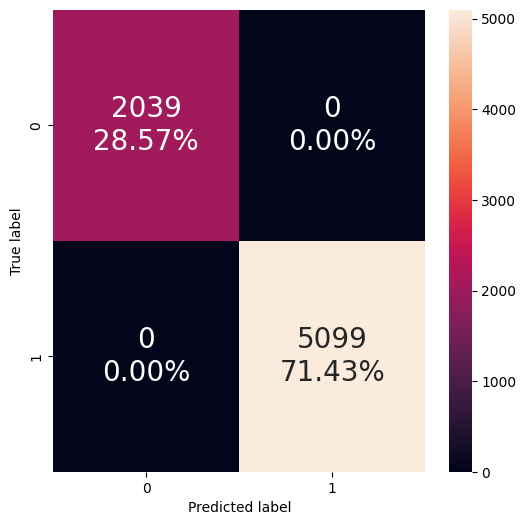

In [116]:
confusion_matrix_sklearn(dt_over, X_train_over, y_train_over)

In [117]:
print("Training Performance")
decision_tree_perf_train_over = model_performance_classification_sklearn(
    dt_over, X_train_over, y_train_over)
decision_tree_perf_train_over

Training Performance


Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0

**Performance of Test set**

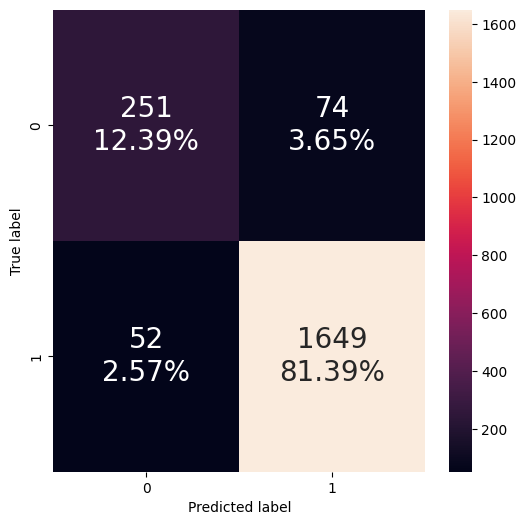

In [118]:
confusion_matrix_sklearn(dt_over, X_test, y_test)

In [119]:
print("Testing Performance")
decision_tree_perf_test_over = model_performance_classification_sklearn(
    dt_over, X_test, y_test)
decision_tree_perf_test_over


Testing Performance


Accuracy   Recall  Precision        F1
0  0.937808  0.96943   0.957052  0.963201

**Performance of Validation set**

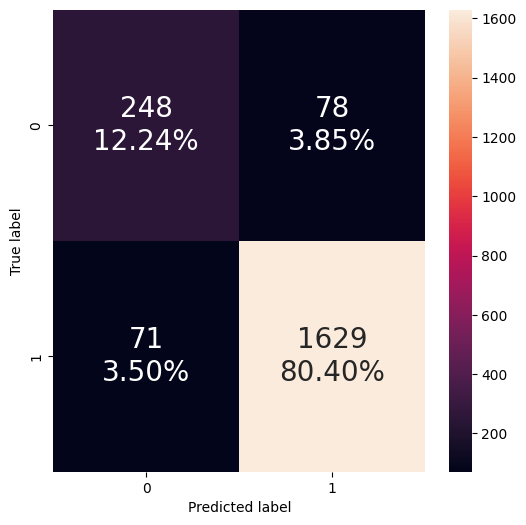

In [120]:
confusion_matrix_sklearn(dt_over, X_val, y_val)

In [121]:
print("Validation Performance")
decision_tree_perf_val_over = model_performance_classification_sklearn(
    dt_over, X_val, y_val)
decision_tree_perf_val_over

Validation Performance


Accuracy    Recall  Precision        F1
0  0.926456  0.958235   0.954306  0.956267

**Decision Tree Performance Summary with OverSampled Train Data**

In [122]:
#merge dataframes containing scores
print("Oversampled Train Data")
dt_results_temp_over = decision_tree_perf_train_over.merge(decision_tree_perf_test_over, how =  'outer')
dt_results_over = dt_results_temp_over.merge(decision_tree_perf_val_over, how='outer')
index= pd.Index(['train','test','val'])
dt_results_over=dt_results_over.set_index(index)
dt_results_over

Oversampled Train Data


Accuracy    Recall  Precision        F1
train  1.000000  1.000000   1.000000  1.000000
test   0.937808  0.969430   0.957052  0.963201
val    0.926456  0.958235   0.954306  0.956267

Percision is 0.9543, the model is overfitted.

### **Decision Tree Classifier with Undersampled Train set**

In [123]:
#Fit the Decision tree model
dt_un = DecisionTreeClassifier(criterion='gini',random_state=1);
dt_un.fit(X_train_un, y_train_un)

DecisionTreeClassifier(random_state=1)

**Performance Check Train Set**

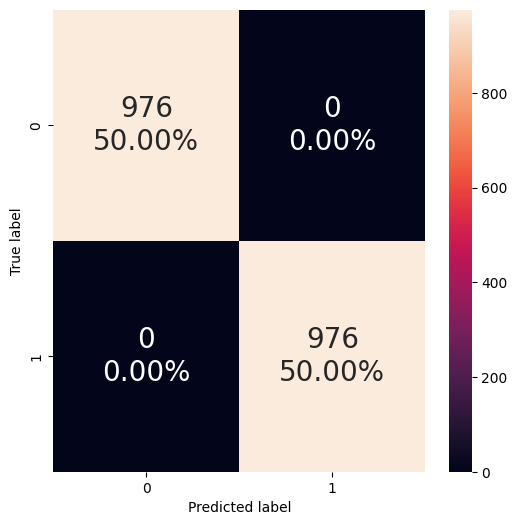

In [124]:
confusion_matrix_sklearn(dt_un, X_train_un, y_train_un)

In [125]:
print("Training Performance")
decision_tree_perf_train_un = model_performance_classification_sklearn(
    dt_un, X_train_un, y_train_un)
decision_tree_perf_train_un

Training Performance


Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0

**Performance Check Test Set**

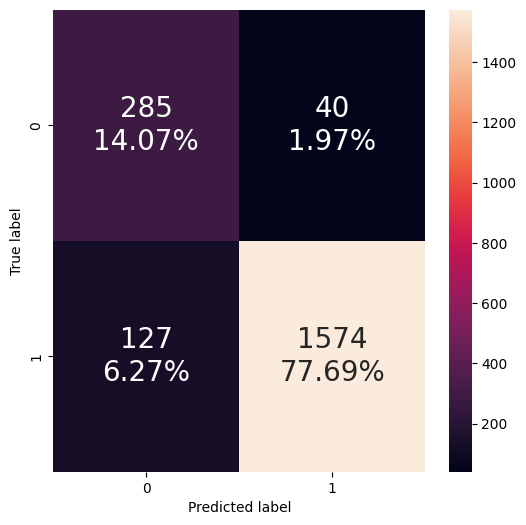

In [126]:
confusion_matrix_sklearn(dt_un, X_test, y_test)

In [127]:
print("Testing Performance")
decision_tree_perf_test_un = model_performance_classification_sklearn(
    dt_un, X_test, y_test)
decision_tree_perf_test_un

Testing Performance


Accuracy    Recall  Precision        F1
0  0.917572  0.925338   0.975217  0.949623

**Performance Check Validation Set**

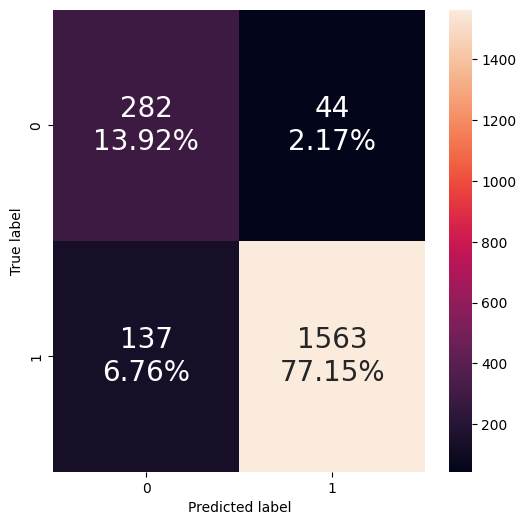

In [128]:
confusion_matrix_sklearn(dt_un, X_val, y_val)

In [129]:
print("Validation Performance")
decision_tree_perf_val_un = model_performance_classification_sklearn(
    dt_un, X_val, y_val)
decision_tree_perf_val_un

Validation Performance


Accuracy    Recall  Precision        F1
0  0.910661  0.919412    0.97262  0.945268

The Logistic Regression model performs better with undersampled data.

For Undersampled data we obtain the largest Precision value of 0.9726 for the Validation set and 0.975217 for the Test set. Surprisingly, the oversampled data performed the worst.

The model is slightly overfit.

**Decision Tree Performance Summary with UnderSampled Train Data**

In [130]:
#merge dataframes containing scores
print("Undersampled Train Data")
dt_results_temp_un = decision_tree_perf_train_un.merge(decision_tree_perf_test_un, how =  'outer')
dt_results_un = dt_results_temp_un.merge(decision_tree_perf_val_un, how='outer')
index= pd.Index(['train','test','val'])
dt_results_un = dt_results_un.set_index(index)
dt_results_un

Undersampled Train Data


Accuracy    Recall  Precision        F1
train  1.000000  1.000000   1.000000  1.000000
test   0.917572  0.925338   0.975217  0.949623
val    0.910661  0.919412   0.972620  0.945268

The Precision for the validation set is 0.97.

### **Visualizing the model**

We are going to visualize the model for the undersampled train data set because this outperformed the other options.

In [131]:
#extracting the features from X_train
feature_names = X_train.columns.to_list()
print(feature_names)

['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Gender_M', 'Education_Level_Doctorate', 'Education_Level_Graduate', 'Education_Level_High School', 'Education_Level_Post-Graduate', 'Education_Level_Uneducated', 'Marital_Status_Married', 'Marital_Status_Single', 'Income_Category_$40K - $60K', 'Income_Category_$60K - $80K', 'Income_Category_$80K - $120K', 'Income_Category_Less than $40K', 'Income_Category_abc', 'Card_Category_Gold', 'Card_Category_Platinum', 'Card_Category_Silver']


In [132]:
feature_names

['Customer_Age',
 'Dependent_count',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio',
 'Gender_M',
 'Education_Level_Doctorate',
 'Education_Level_Graduate',
 'Education_Level_High School',
 'Education_Level_Post-Graduate',
 'Education_Level_Uneducated',
 'Marital_Status_Married',
 'Marital_Status_Single',
 'Income_Category_$40K - $60K',
 'Income_Category_$60K - $80K',
 'Income_Category_$80K - $120K',
 'Income_Category_Less than $40K',
 'Income_Category_abc',
 'Card_Category_Gold',
 'Card_Category_Platinum',
 'Card_Category_Silver']

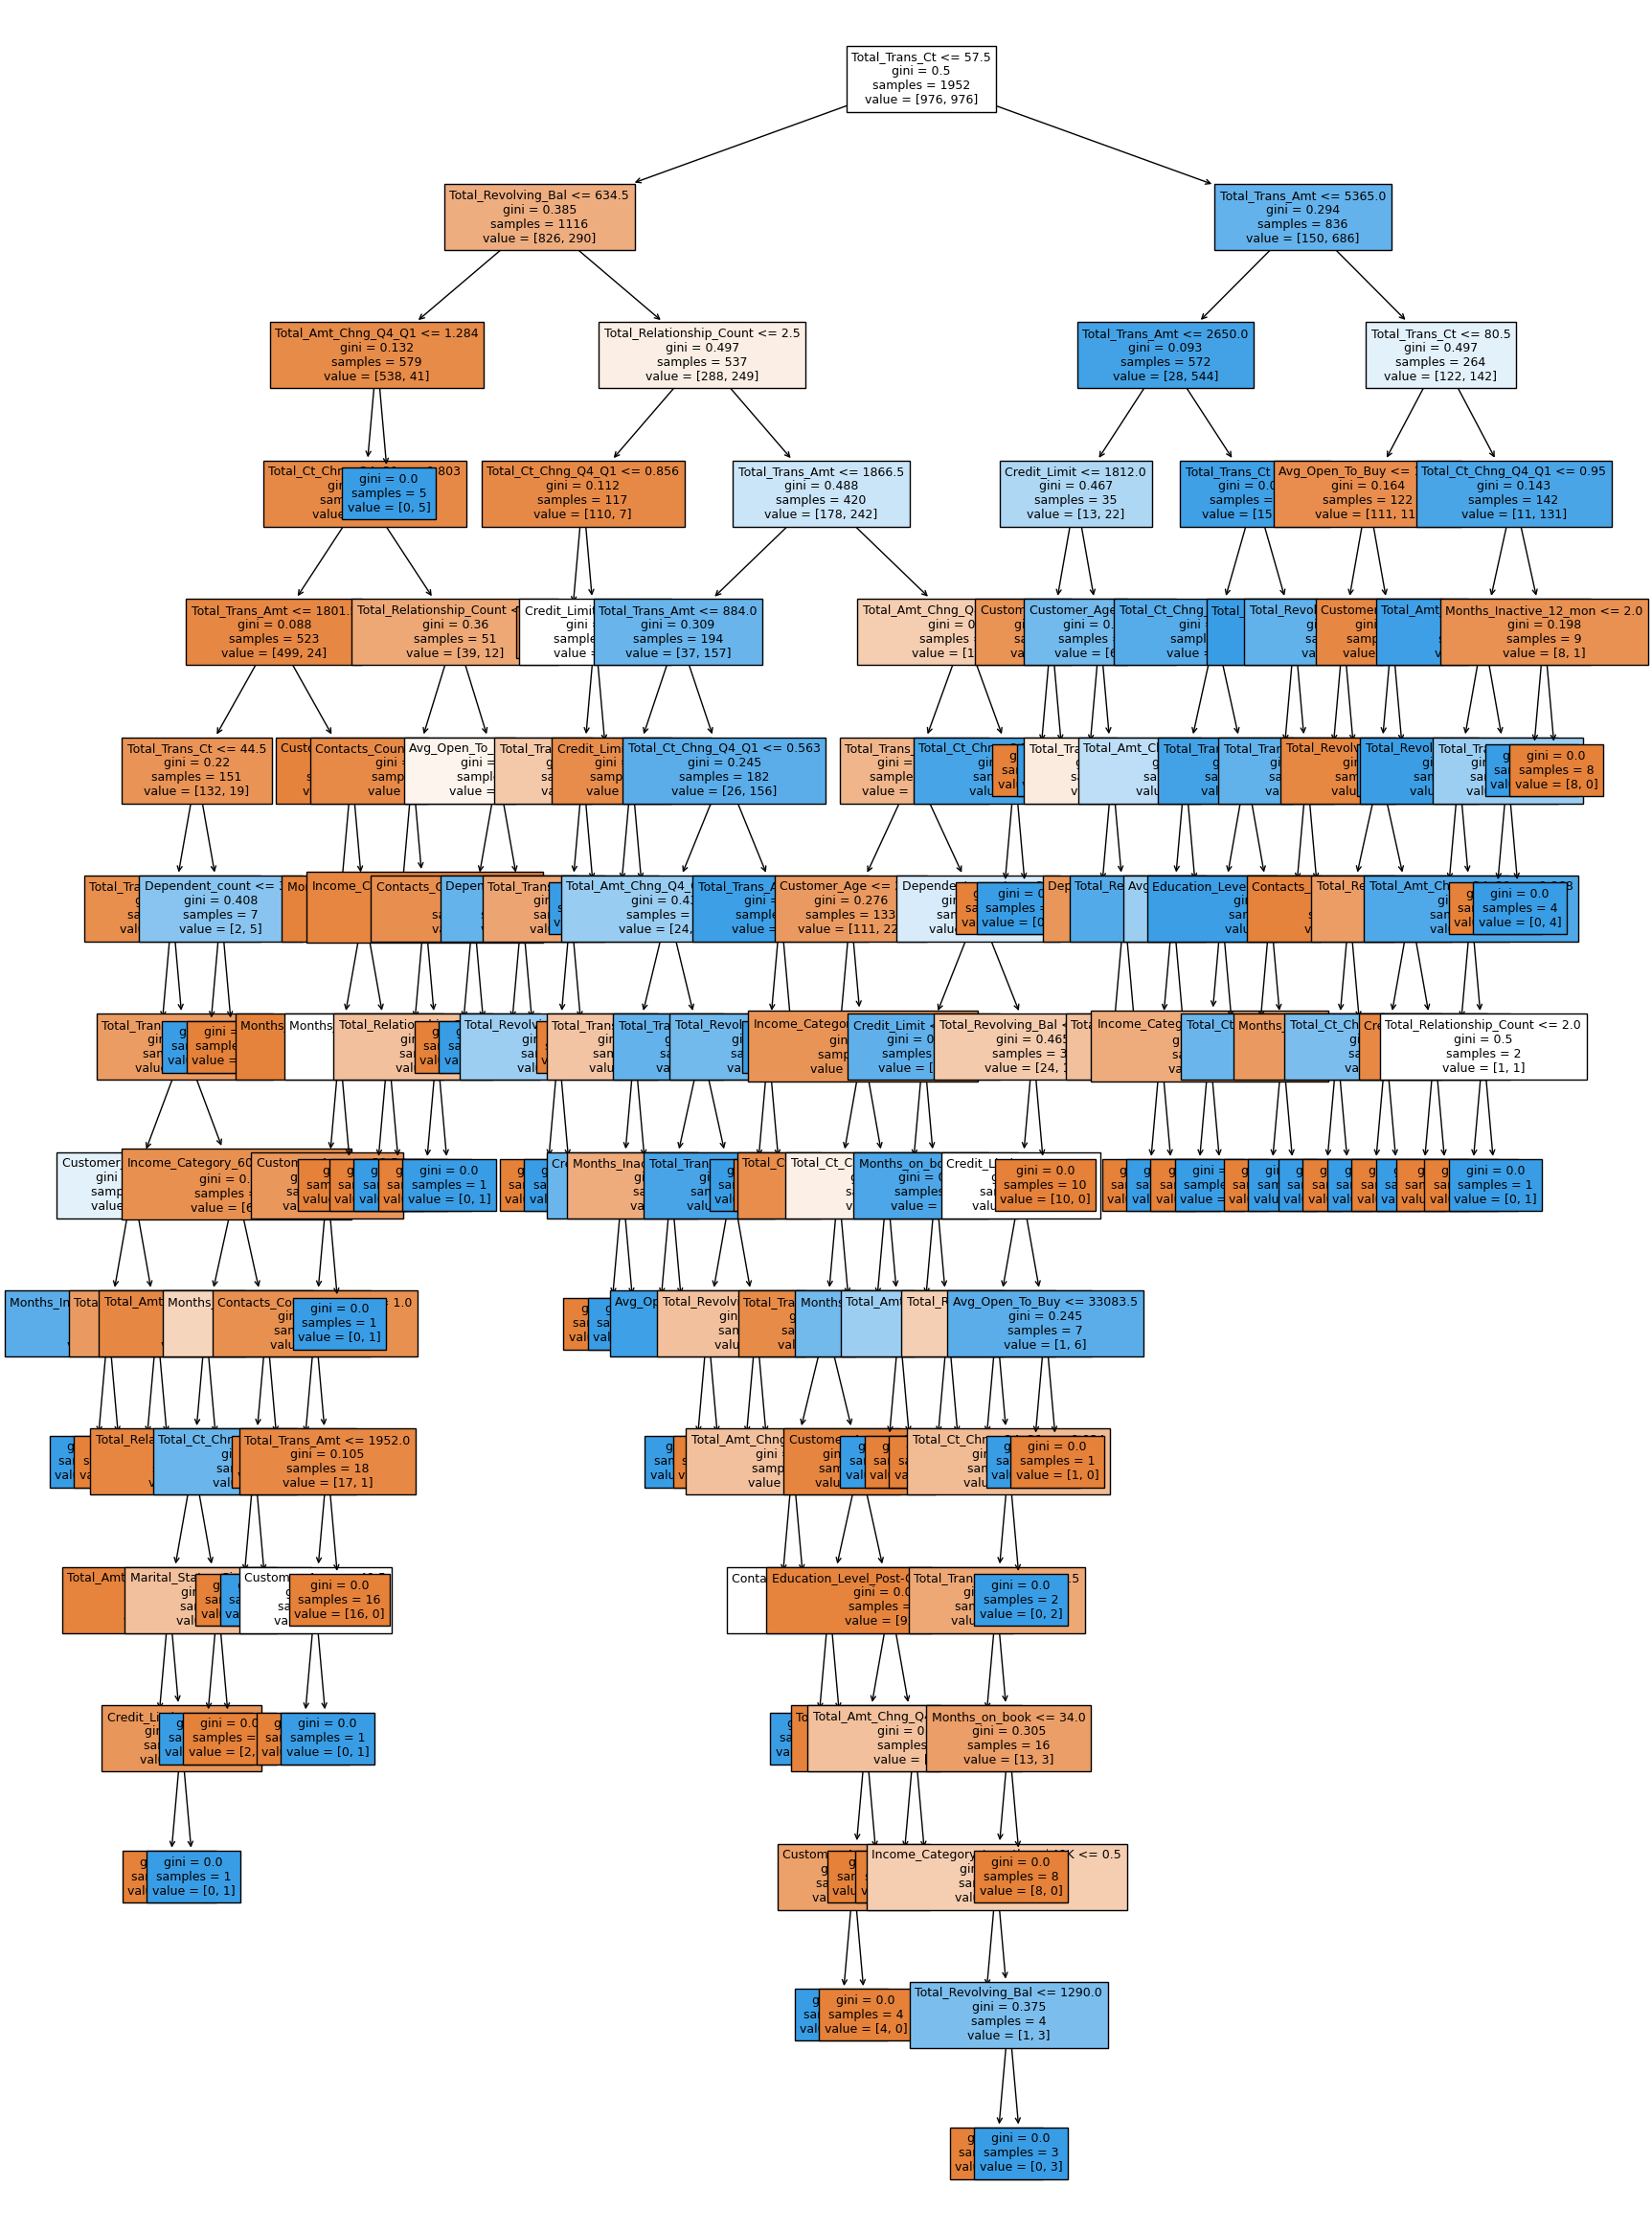

In [133]:
plt.figure(figsize=(20, 30))
out = tree.plot_tree(
    dt_un,
    feature_names=feature_names,
    filled=True,
    fontsize=9,
    node_ids=False,
    class_names=None,
)
# below code will add arrows to the decision tree split if they are missing
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor("black")
        arrow.set_linewidth(1)
plt.show()

We really can't see much from the dt visualization plot

In [134]:
# Text report showing the rules of a decision tree -
print(tree.export_text(dt_un, feature_names=feature_names, show_weights=True))

|--- Total_Trans_Ct <= 57.50
|   |--- Total_Revolving_Bal <= 634.50
|   |   |--- Total_Amt_Chng_Q4_Q1 <= 1.28
|   |   |   |--- Total_Ct_Chng_Q4_Q1 <= 0.80
|   |   |   |   |--- Total_Trans_Amt <= 1801.50
|   |   |   |   |   |--- Total_Trans_Ct <= 44.50
|   |   |   |   |   |   |--- Total_Trans_Amt <= 1112.00
|   |   |   |   |   |   |   |--- weights: [64.00, 0.00] class: 0
|   |   |   |   |   |   |--- Total_Trans_Amt >  1112.00
|   |   |   |   |   |   |   |--- Total_Trans_Amt <= 1349.00
|   |   |   |   |   |   |   |   |--- Customer_Age <= 48.50
|   |   |   |   |   |   |   |   |   |--- Months_Inactive_12_mon <= 3.50
|   |   |   |   |   |   |   |   |   |   |--- weights: [0.00, 6.00] class: 1
|   |   |   |   |   |   |   |   |   |--- Months_Inactive_12_mon >  3.50
|   |   |   |   |   |   |   |   |   |   |--- weights: [1.00, 0.00] class: 0
|   |   |   |   |   |   |   |   |--- Customer_Age >  48.50
|   |   |   |   |   |   |   |   |   |--- Total_Trans_Amt <= 1333.00
|   |   |   |   |   |   |   |

In [135]:
# importance of features in the tree building ( The importance of a feature is computed as the
# (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance )

print(
    pd.DataFrame(
        dt_un.feature_importances_, columns=["Imp"], index=X_train.columns
    ).sort_values(by="Imp", ascending=False)
)

                                     Imp
Total_Trans_Ct                  0.425561
Total_Trans_Amt                 0.169030
Total_Revolving_Bal             0.108652
Total_Amt_Chng_Q4_Q1            0.062081
Total_Relationship_Count        0.059459
Total_Ct_Chng_Q4_Q1             0.054755
Customer_Age                    0.025340
Credit_Limit                    0.021777
Months_Inactive_12_mon          0.016722
Avg_Open_To_Buy                 0.016433
Dependent_count                 0.014909
Contacts_Count_12_mon           0.006767
Income_Category_$60K - $80K     0.005984
Months_on_book                  0.003149
Avg_Utilization_Ratio           0.002561
Income_Category_Less than $40K  0.002305
Income_Category_$80K - $120K    0.002149
Marital_Status_Single           0.001366
Education_Level_Post-Graduate   0.001001
Card_Category_Platinum          0.000000
Card_Category_Gold              0.000000
Income_Category_abc             0.000000
Education_Level_Doctorate       0.000000
Income_Category_

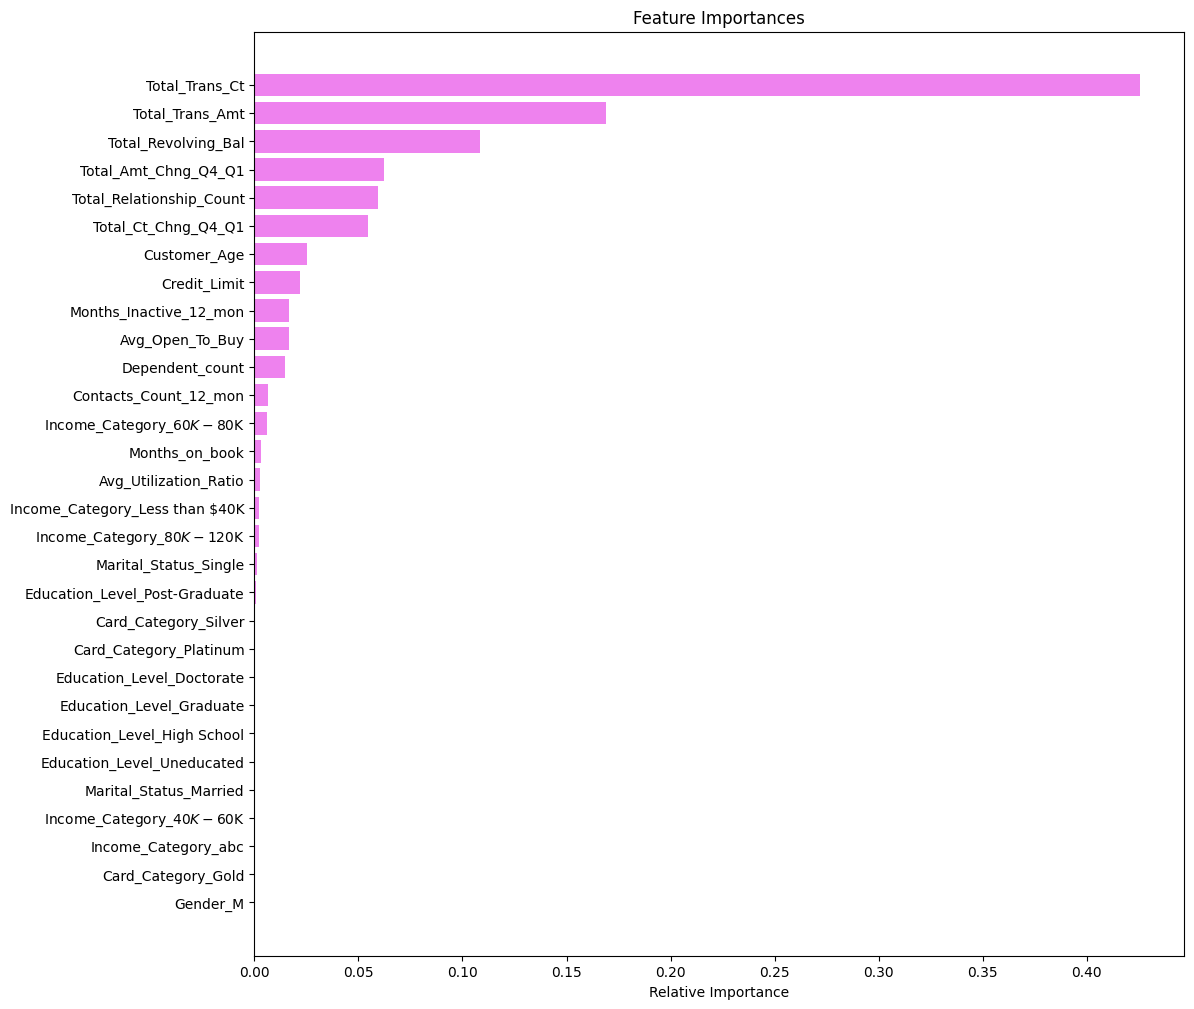

In [136]:
importances = dt_un.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

Total_Trans_Ct, Total_Revolving_Bal, Total_Trans_Amt, Total_Relationship_Count, Total_Ct_Chng_Q4_Q1, Total_Amt_Chng_Q4_Q1 are the most important features.

If we choose to do tuning of this model, we could use:
a. Reduce complexity by limiting the max_depth
b. Use GridSearch for hyperparameter tuning
b. Prune the trees
c. Use Class weights


## **Bagging Classifier**

### **Bagging Classifier with Default Train Data**

In [137]:
#base_estimator for bagging classifier is a decision tree by default
bagging_estimator=BaggingClassifier(random_state=1)
bagging_estimator.fit(X_train,y_train)

BaggingClassifier(random_state=1)

In [138]:
#Get precision, accuracy, recall and precision on train and test set
bagging_estimator_score=get_metrics_score(bagging_estimator)

Accuracy on training set :  0.9975308641975309
Accuracy on test set :  0.9531095755182626
Recall on training set :  0.9976465973720338
Recall on test set :  0.975896531452087
Precision on training set :  0.9994106090373281
Precision on test set :  0.9684947491248541


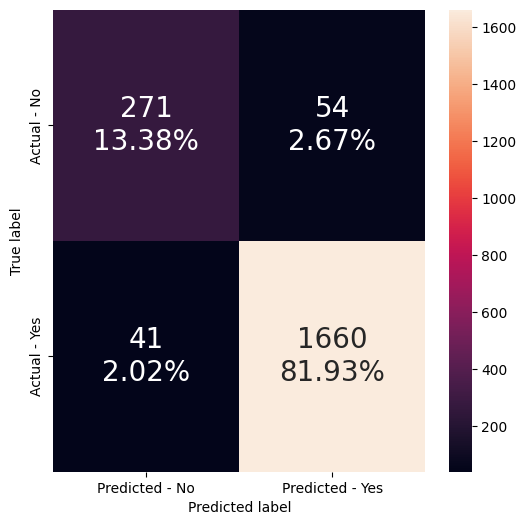

In [139]:
make_confusion_matrix(bagging_estimator,y_test)

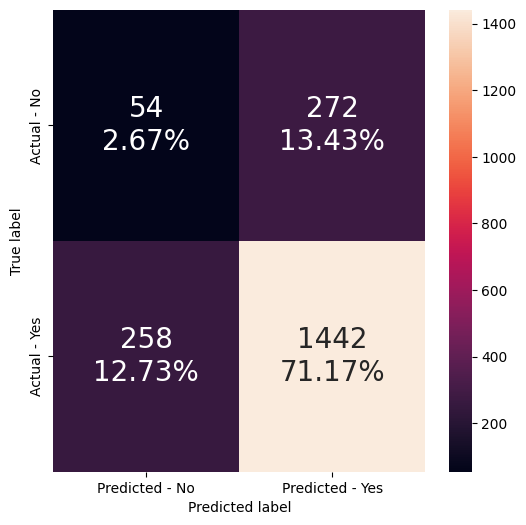

In [140]:
make_confusion_matrix(bagging_estimator,y_val)

In [141]:
# Predicting the target for train and validation set
pred_train_bagging = bagging_estimator.predict(X_train)
pred_test_bagging = bagging_estimator.predict(X_test)
pred_val_bagging = bagging_estimator.predict(X_val)

# Checking Precision score on undersampled train and validation set
ps_train_bag= precision_score(y_train, pred_train_bagging)
ps_test_bag = precision_score(y_test, pred_test_bagging)
ps_val_bag = precision_score(y_val, pred_val_bagging)

print("Train ", ps_train_bag)
print("Test  ", ps_test_bag)
print("Val   ", ps_val_bag)

Train  0.9994106090373281
Test   0.9684947491248541
Val    0.9651770168311086


Bagging is slightly overfitting.

### **Bagging Classifier Default with Oversampled Train Data**

In [142]:
bagging_estimator_over= BaggingClassifier(random_state=1)
bagging_estimator_over.fit(X_train_over,y_train_over)

BaggingClassifier(random_state=1)

In [143]:
bagging_estimator_score_over=get_metrics_score(bagging_estimator_over)

Accuracy on training set :  0.997201646090535
Accuracy on test set :  0.9531095755182626
Recall on training set :  0.9976465973720338
Recall on test set :  0.9735449735449735
Precision on training set :  0.9990180675569521
Precision on test set :  0.9706916764361079


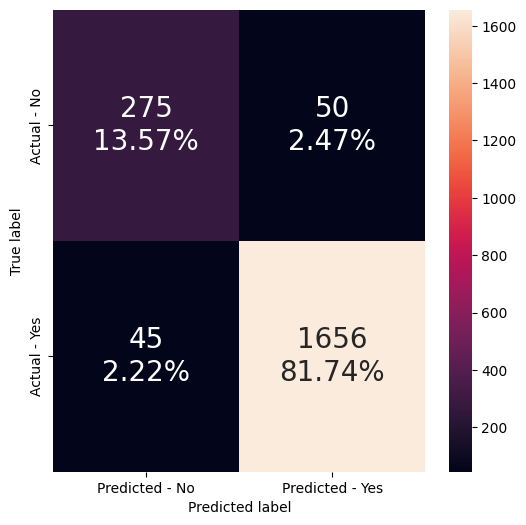

In [144]:
make_confusion_matrix(bagging_estimator_over,y_test)

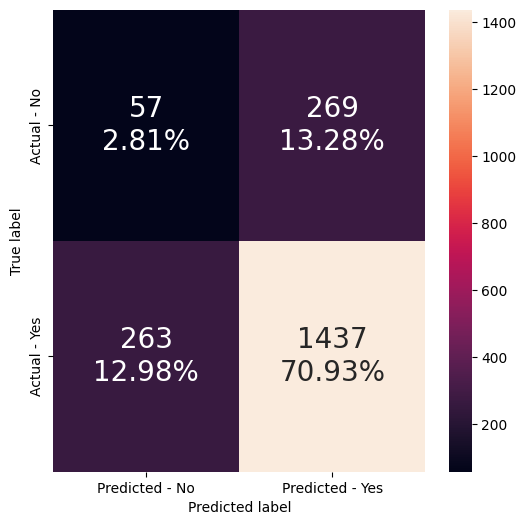

In [145]:
make_confusion_matrix(bagging_estimator_over,y_val)

In [146]:
# Predicting the target for train and validation set
pred_train_bag_over = bagging_estimator.predict(X_train_over)
pred_test_bag_over = bagging_estimator.predict(X_test)
pred_val_bag_over = bagging_estimator.predict(X_val)

# Checking Precision score on undersampled train and validation set
ps_train_bag_over= precision_score(y_train_over, pred_train_bag_over)
ps_test_bag_over = precision_score(y_test, pred_test_bag_over)
ps_val_bag_over = precision_score(y_val, pred_val_bag_over)

print("Train ", ps_train_bag_over)
print("Test  ", ps_test_bag_over)
print("Val   ", ps_val_bag_over)

Train  0.9864262167927089
Test   0.9684947491248541
Val    0.9651770168311086


### **Bagging Classifier Default with Undersampled Train Data</**

In [147]:
bagging_estimator_un= BaggingClassifier(random_state=1)
bagging_estimator_un.fit(X_train_un,y_train_un)

BaggingClassifier(random_state=1)

In [148]:
bagging_estimator_score_un=get_metrics_score(bagging_estimator_un)

Accuracy on training set :  0.9465020576131687
Accuracy on test set :  0.9126357354392892
Recall on training set :  0.9362620121592469
Recall on test set :  0.9129923574368018
Precision on training set :  1.0
Precision on test set :  0.9816687737041719


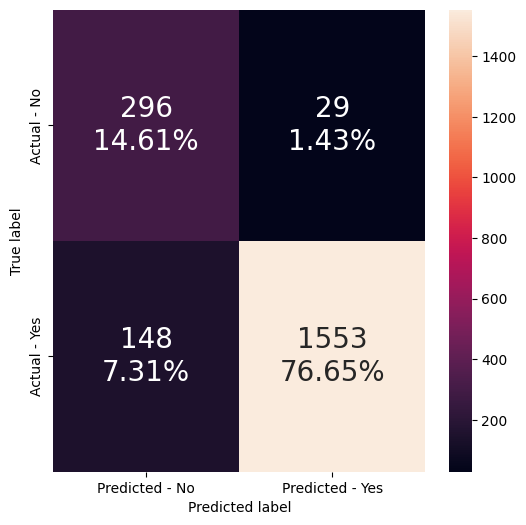

In [149]:
make_confusion_matrix(bagging_estimator_un,y_test)

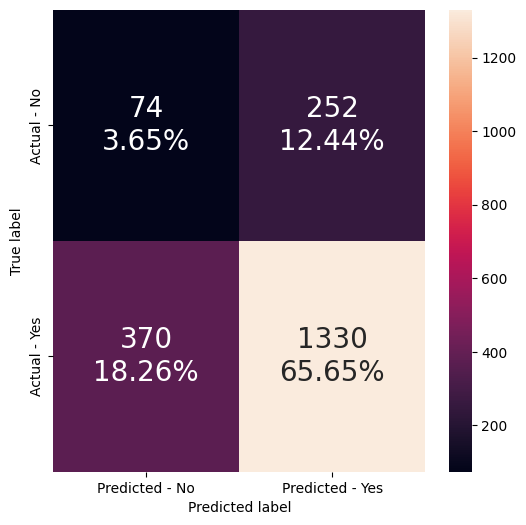

In [150]:
make_confusion_matrix(bagging_estimator_un,y_val)

In [151]:
# Predicting the target for train and validation set
pred_train_bagging_un = bagging_estimator_un.predict(X_train_un)
pred_test_bagging_un = bagging_estimator_un.predict(X_test)
pred_val_bagging_un = bagging_estimator_un.predict(X_val)

# Checking Precision score on undersampled train and validation set
ps_train_bag_un= precision_score(y_train_un, pred_train_bagging_un)
ps_test_bag_un = precision_score(y_test, pred_test_bagging_un)
ps_val_bag_un = precision_score(y_val, pred_val_bagging_un)

print("Train ", ps_train_bag_un)
print("Test  ", ps_test_bag_un)
print("Val   ", ps_val_bag_un)

Train  1.0
Test   0.9816687737041719
Val    0.9835547122074636


In [152]:
# Checking Precision score on oversampled train and validation set on Predictions
print(precision_score(y_train_un, pred_train_bagging_un))
print(precision_score(y_test, pred_test_bagging_un))
print(precision_score(y_val, pred_val_bagging_un))

1.0
0.9816687737041719
0.9835547122074636


The precision for Bagging with Undersampled Train data is 0.981 on the test set and 0.983 on the validation set, which is better than the precision with oversampled train data and standard data.

### **Bagging Classifier Performance Summary**

In [153]:
bag_results = [[ps_train_bag,ps_test_bag,ps_val_bag],
               [ps_train_bag_over,ps_test_bag_over,ps_val_bag_over],
               [ps_train_bag_un,ps_test_bag_un,ps_val_bag_un]]
bag_df = pd.DataFrame(bag_results,columns=['Train','Test','Val'],
                      index={'normal':'Row_1','Over':'Row_2','Under':'Row_3'})
bag_df

Train      Test       Val
normal  0.999411  0.968495  0.965177
Over    0.986426  0.968495  0.965177
Under   1.000000  0.981669  0.983555

The model using the undersampled Train data yields higher Precision, although the model is slightly overfitted.

## **Random Forest Classifier**

### **Random Forest with Default Train Data**

In [154]:
#Train the random forest classifier
rf_estimator=RandomForestClassifier(random_state=1)
rf_estimator.fit(X_train,y_train)

RandomForestClassifier(random_state=1)

In [155]:
#Using above defined function to get accuracy, recall and precision on train and test set
rf_estimator_score=get_metrics_score(rf_estimator)

Accuracy on training set :  1.0
Accuracy on test set :  0.9516288252714709
Recall on training set :  1.0
Recall on test set :  0.9905937683715461
Precision on training set :  1.0
Precision on test set :  0.9535936615732881


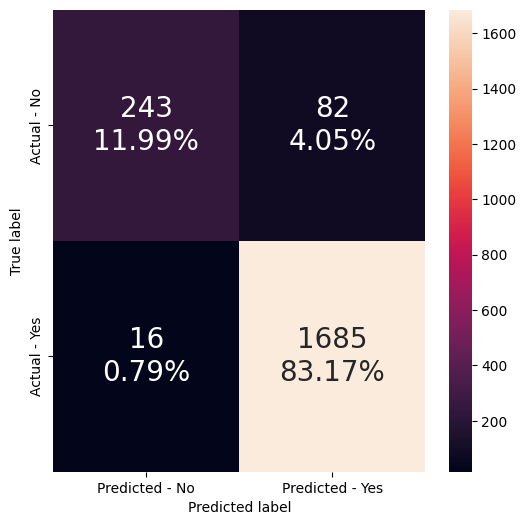

In [156]:
make_confusion_matrix(rf_estimator,y_test)

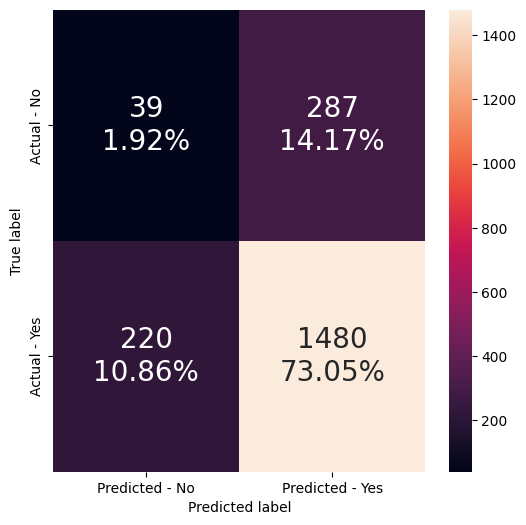

In [157]:
make_confusion_matrix(rf_estimator,y_val)

In [158]:
# Predicting the target for train and validation set
pred_train_rf = rf_estimator.predict(X_train)
pred_test_rf = rf_estimator.predict(X_test)
pred_val_rf = rf_estimator.predict(X_val)

# Checking Precision score on undersampled train and validation set
ps_train_rf= precision_score(y_train, pred_train_rf)
ps_test_rf = precision_score(y_test, pred_test_rf)
ps_val_rf = precision_score(y_val, pred_val_rf)

print("Train ", ps_train_rf)
print("Test  ", ps_test_rf)
print("Val   ", ps_val_rf)

Train  1.0
Test   0.9535936615732881
Val    0.9516770892552586


### **Random Forest with Oversampled Train Data**

In [159]:
#Train the random forest classifier
rf_estimator_over=RandomForestClassifier(random_state=1)
rf_estimator_over.fit(X_train_over,y_train_over)

RandomForestClassifier(random_state=1)

In [160]:
#Using above defined function to get accuracy, recall and precision on train and test set
rf_estimator_score_over=get_metrics_score(rf_estimator_over)

Accuracy on training set :  1.0
Accuracy on test set :  0.9531095755182626
Recall on training set :  1.0
Recall on test set :  0.9835390946502057
Precision on training set :  1.0
Precision on test set :  0.9614942528735633


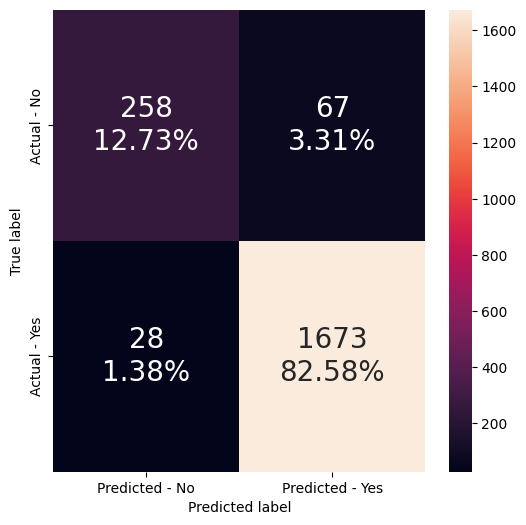

In [161]:
make_confusion_matrix(rf_estimator_over,y_test)

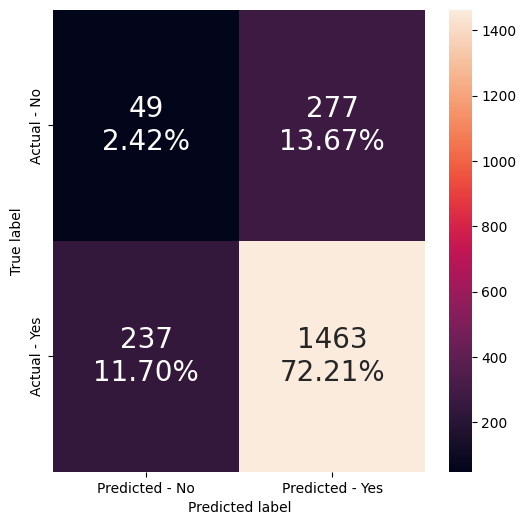

In [162]:
make_confusion_matrix(rf_estimator_over,y_val)

In [163]:
# Predicting the target for train and validation set
pred_train_rf_over = rf_estimator_over.predict(X_train_over)
pred_test_rf_over = rf_estimator_over.predict(X_test)
pred_val_rf_over = rf_estimator_over.predict(X_val)

# Checking Precision score on undersampled train and validation set
ps_train_rf_over= precision_score(y_train_over, pred_train_rf_over)
ps_test_rf_over = precision_score(y_test, pred_test_rf_over)
ps_val_rf_over = precision_score(y_val, pred_val_rf_over)

print("Train ", ps_train_rf_over)
print("Test  ", ps_test_rf_over)
print("Val   ", ps_val_rf_over)


Train  1.0
Test   0.9614942528735633
Val    0.9597006332757628


### **Random Forest Classification with UnderSampled Train Data**

In [164]:
#Train the random forest classifier
rf_estimator_un=RandomForestClassifier(random_state=1)
rf_estimator_un.fit(X_train_un,y_train_un)

RandomForestClassifier(random_state=1)

In [165]:
#Using above defined function to get accuracy, recall and precision on train and test set
rf_estimator_score_un=get_metrics_score(rf_estimator_un)

Accuracy on training set :  0.9520987654320988
Accuracy on test set :  0.9264560710760118
Recall on training set :  0.942929986271818
Recall on test set :  0.9271017048794826
Precision on training set :  1.0
Precision on test set :  0.9843945068664169


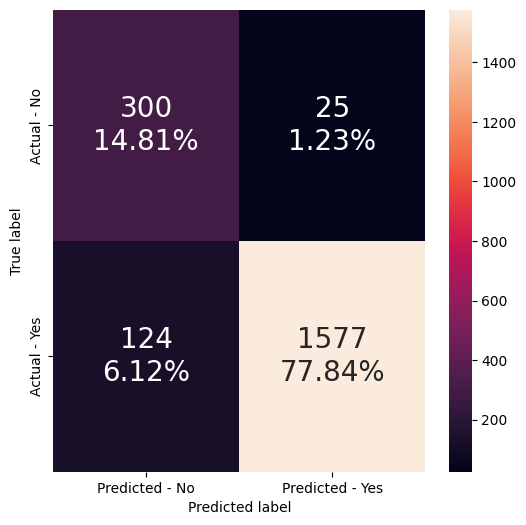

In [166]:
make_confusion_matrix(rf_estimator_un,y_test)

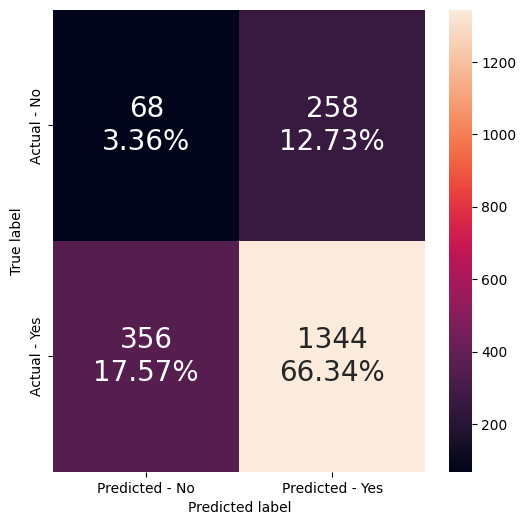

In [167]:
make_confusion_matrix(rf_estimator_un,y_val)

In [168]:
# Predicting the target for train and validation set
pred_train_rf_un = rf_estimator_un.predict(X_train_un)
pred_test_rf_un = rf_estimator_un.predict(X_test)
pred_val_rf_un = rf_estimator_un.predict(X_val)

# Checking Precision score on undersampled train and validation set
ps_train_rf_un= precision_score(y_train_un, pred_train_rf_un)
ps_test_rf_un = precision_score(y_test, pred_test_rf_un)
ps_val_rf_un = precision_score(y_val, pred_val_rf_un)

print("Train ", ps_train_rf_un)
print("Test  ", ps_test_rf_un)
print("Val   ", ps_val_rf_un)


Train  1.0
Test   0.9843945068664169
Val    0.9804878048780488


- The precision for Random Forest Classifier with undersampled train data set has a higher precision than the other cases.

### **Random Forest Classifier Performance Summary**

In [169]:
rf_results = [[ps_train_rf,ps_test_rf,ps_val_rf],[ps_train_rf_over,ps_test_rf_over,ps_val_rf_over],
               [ps_train_rf_un,ps_test_rf_un,ps_val_rf_un]]
rf_df = pd.DataFrame(rf_results,columns=['Train','Test','Val'],
                      index={'normal':'Row_1','Over':'Row_2','Under':'Row_3'})
rf_df


Train      Test       Val
normal    1.0  0.953594  0.951677
Over      1.0  0.961494  0.959701
Under     1.0  0.984395  0.980488

Undersampling yields the highest Precision.

## **Adaboost Classifier**

### **Adaboost Classifier with Default Train Data**

In [170]:
abc = AdaBoostClassifier(random_state=1)
abc.fit(X_train,y_train)

AdaBoostClassifier(random_state=1)

In [171]:
#Using above defined function to get accuracy, recall and precision on train and test set
abc_score=get_metrics_score(abc)

Accuracy on training set :  0.9613168724279836
Accuracy on test set :  0.9570582428430404
Recall on training set :  0.9825455971759168
Recall on test set :  0.9800117577895355
Precision on training set :  0.9716834755624515
Precision on test set :  0.9691860465116279


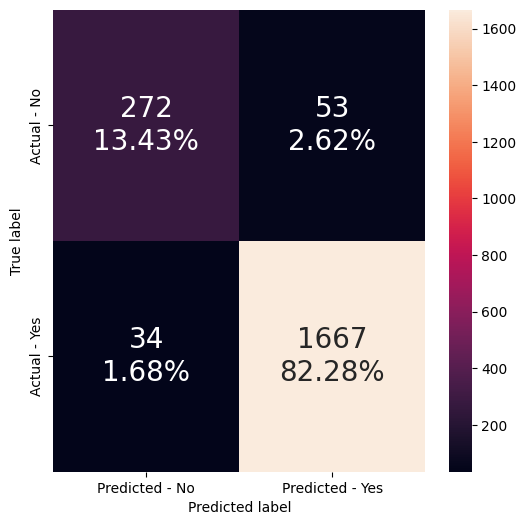

In [172]:
make_confusion_matrix(abc,y_test)

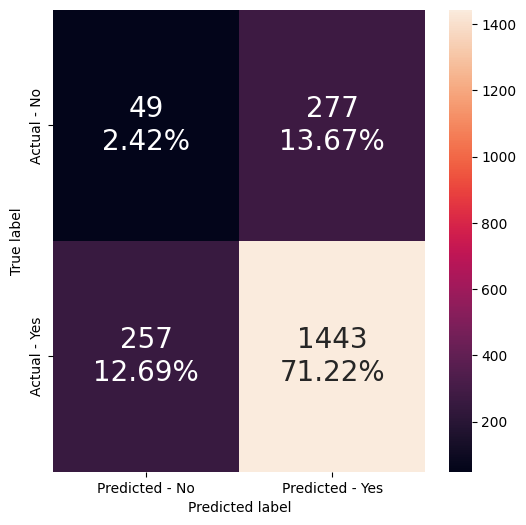

In [173]:
make_confusion_matrix(abc,y_val)

In [174]:
# Predicting the target for train and validation set
pred_train_abc = abc.predict(X_train)
pred_test_abc = abc.predict(X_test)
pred_val_abc = abc.predict(X_val)

# Checking Precision score on undersampled train and validation set
ps_train_abc= precision_score(y_train, pred_train_abc)
ps_test_abc = precision_score(y_test, pred_test_abc)
ps_val_abc = precision_score(y_val, pred_val_abc)

print("Train ", ps_train_abc)
print("Test  ", ps_test_abc)
print("Val   ", ps_val_abc)


Train  0.9716834755624515
Test   0.9691860465116279
Val    0.9647602541883304


### **Adaboost Classifier with Oversampled Train Data<**

In [175]:
abc_over = AdaBoostClassifier(random_state=1)
abc_over.fit(X_train_over,y_train_over)

AdaBoostClassifier(random_state=1)

In [176]:
#Using above defined function to get accuracy, recall and precision on train and test set
abc_score_over=get_metrics_score(abc_over)

Accuracy on training set :  0.9578600823045268
Accuracy on test set :  0.9615004935834156
Recall on training set :  0.9731319866640518
Recall on test set :  0.9747207524985303
Precision on training set :  0.9765794135012793
Precision on test set :  0.9793266391021854


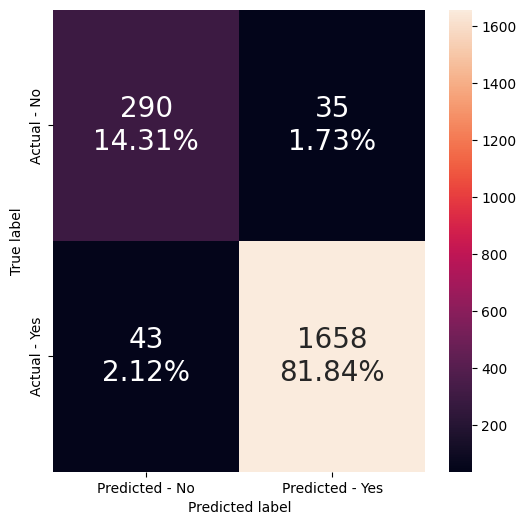

In [177]:
make_confusion_matrix(abc_over,y_test)

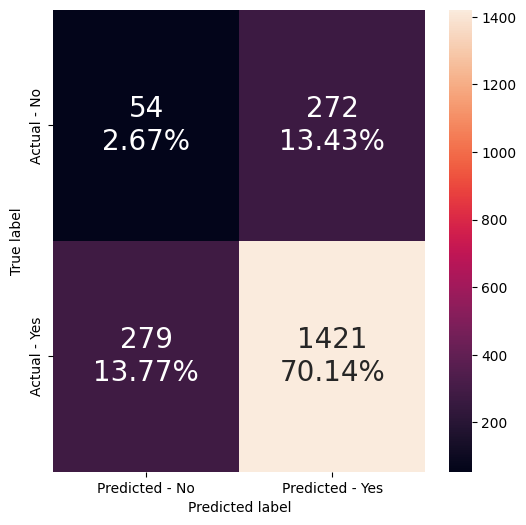

In [178]:
make_confusion_matrix(abc_over,y_val)

In [179]:
# Predicting the target for train and validation set
pred_train_abc_over = abc_over.predict(X_train_over)
pred_test_abc_over = abc_over.predict(X_test)
pred_val_abc_over = abc_over.predict(X_val)

# Checking Precision score on undersampled train and validation set
ps_train_abc_over= precision_score(y_train_over, pred_train_abc_over)
ps_test_abc_over = precision_score(y_test, pred_test_abc_over)
ps_val_abc_over = precision_score(y_val, pred_val_abc_over)

print("Train over :", ps_train_abc_over)
print("Test over  :", ps_test_abc_over)
print("Val over   :", ps_val_abc_over)


Train over : 0.9702776691435275
Test over  : 0.9793266391021854
Val over   : 0.9746312684365782


### **Adaboost Classifier with Undersampled Train Data**

In [180]:
abc_un = AdaBoostClassifier(random_state=1)
abc_un.fit(X_train_un,y_train_un)

AdaBoostClassifier(random_state=1)

In [181]:
#Using above defined function to get accuracy, recall and precision on train and test set
abc_score_un=get_metrics_score(abc_un)

Accuracy on training set :  0.9325102880658436
Accuracy on test set :  0.9333662388943732
Recall on training set :  0.9288095705040204
Recall on test set :  0.927689594356261
Precision on training set :  0.9901735312565335
Precision on test set :  0.9924528301886792


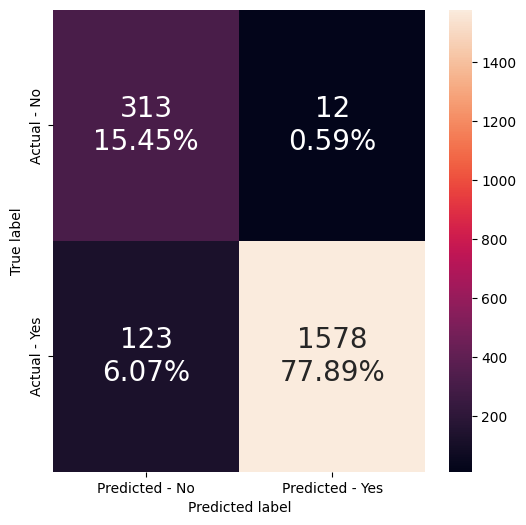

In [182]:
make_confusion_matrix(abc_un,y_test)

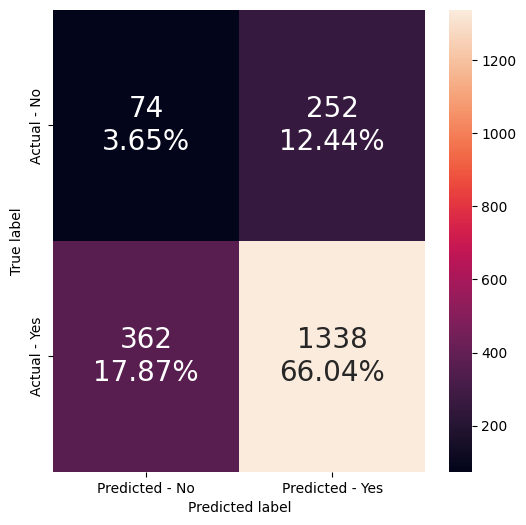

In [183]:
make_confusion_matrix(abc_un,y_val)

In [184]:
# Predicting the target for train and validation set
pred_train_abc_un = abc_un.predict(X_train_un)
pred_test_abc_un = abc_un.predict(X_test)
pred_val_abc_un = abc_un.predict(X_val)

# Checking Precision score on undersampled train and validation set
ps_train_abc_un= precision_score(y_train_un, pred_train_abc_un)
ps_test_abc_un = precision_score(y_test, pred_test_abc_un)
ps_val_abc_un = precision_score(y_val, pred_val_abc_un)

print("Train un :", ps_train_abc_un)
print("Test un  :", ps_test_abc_un)
print("Val un   :", ps_val_abc_un)

Train un : 0.9512953367875647
Test un  : 0.9924528301886792
Val un   : 0.9855436832181018


### **Adaboost Classifier Performance Summary**

In [185]:
abc_results = [[ps_train_abc,ps_test_abc,ps_val_abc],[ps_train_abc_over,ps_test_abc_over,ps_val_abc_over],[ps_train_abc_un,ps_test_abc_un,ps_val_abc_un]]
abc_df = pd.DataFrame(abc_results,columns=['Train','Test','Val'],index={'normal':'Row_1','Over':'Row_2','Under':'Row_3'})
abc_df


Train      Test       Val
normal  0.971683  0.969186  0.964760
Over    0.970278  0.979327  0.974631
Under   0.951295  0.992453  0.985544

Adaboost performs better with undersampled Train data as its Precision improves from 0.969 (default data), to 0.979 (Oversampled) to 0.992 (Undersampled) for the testing set. T

## **Gradient Boosting Classifier**

### **Gradient Boosting Classifier with Default Train data**

In [186]:
gbc = GradientBoostingClassifier(random_state=1)
gbc.fit(X_train,y_train)

GradientBoostingClassifier(random_state=1)

In [187]:
#Using above defined function to get accuracy, recall and precision on train and test set
gbc_score=get_metrics_score(gbc)

Accuracy on training set :  0.9794238683127572
Accuracy on test set :  0.9669299111549852
Recall on training set :  0.9925475583447735
Recall on test set :  0.9923574368018813
Precision on training set :  0.9831002331002331
Precision on test set :  0.9690011481056258


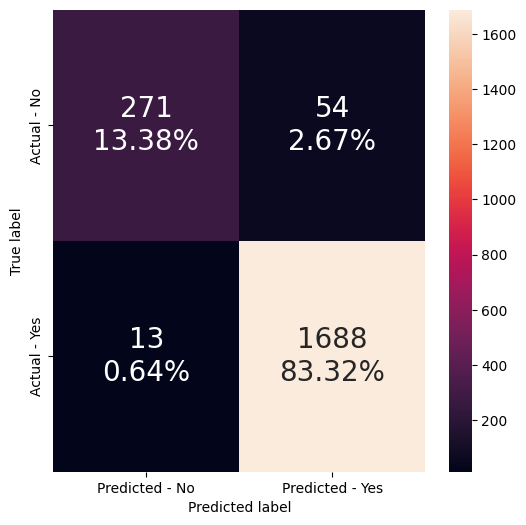

In [188]:
make_confusion_matrix(gbc,y_test)

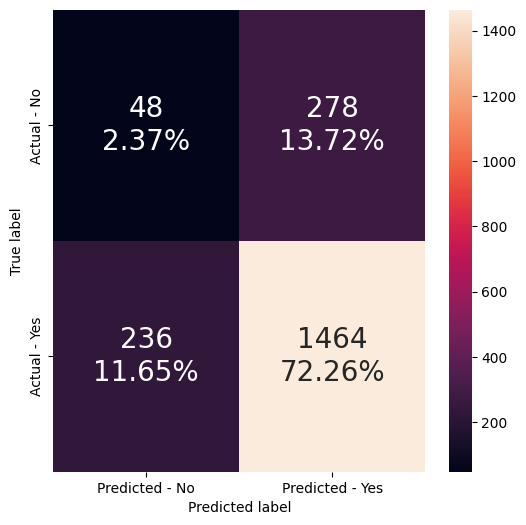

In [189]:
make_confusion_matrix(gbc,y_val)

In [190]:
# Predicting the target for train and validation set
pred_train_gbc = gbc.predict(X_train)
pred_test_gbc = gbc.predict(X_test)
pred_val_gbc = gbc.predict(X_val)

# Checking Precision score on undersampled train and validation set
ps_train_gbc= precision_score(y_train, pred_train_gbc)
ps_test_gbc = precision_score(y_test, pred_test_gbc)
ps_val_gbc = precision_score(y_val, pred_val_gbc)

print("Train ", ps_train_gbc)
print("Test  ", ps_test_gbc)
print("Val   ", ps_val_gbc)


Train  0.9831002331002331
Test   0.9690011481056258
Val    0.9660529344073648


### **Gradient Boosting Classifier with Oversampled Train data**

In [191]:
gbc_over = GradientBoostingClassifier(random_state=1)
gbc_over.fit(X_train_over,y_train_over)

GradientBoostingClassifier(random_state=1)

In [192]:
#Using above defined function to get accuracy, recall and precision on train and test set
gbc_score_over=get_metrics_score(gbc_over)

Accuracy on training set :  0.9767901234567902
Accuracy on test set :  0.9644619940769991
Recall on training set :  0.9866640517748578
Recall on test set :  0.9805996472663139
Precision on training set :  0.9856974921630094
Precision on test set :  0.9771528998242531


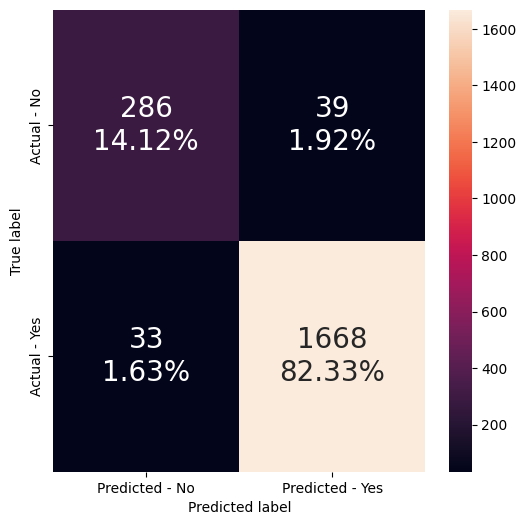

In [193]:
make_confusion_matrix(gbc_over,y_test)

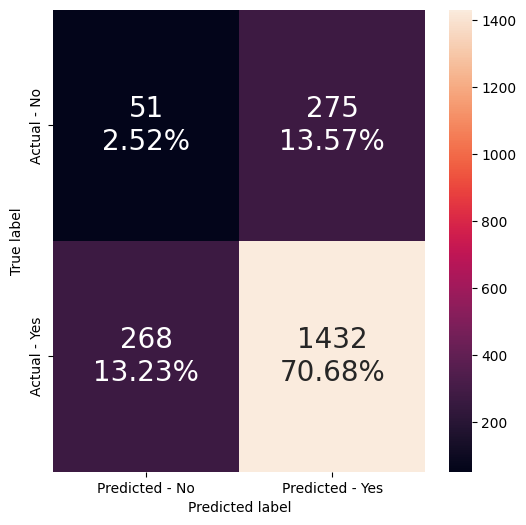

In [194]:
make_confusion_matrix(gbc_over,y_val)

In [195]:
# Predicting the target for train and validation set
pred_train_gbc_over = gbc_over.predict(X_train_over)
pred_test_gbc_over = gbc_over.predict(X_test)
pred_val_gbc_over = gbc_over.predict(X_val)

# Checking Precision score on undersampled train and validation set
ps_train_gbc_over= precision_score(y_train_over, pred_train_gbc_over)
ps_test_gbc_over = precision_score(y_test, pred_test_gbc_over)
ps_val_gbc_over = precision_score(y_val, pred_val_gbc_over)

print("Train over", ps_train_gbc_over)
print("Test over ", ps_test_gbc_over)
print("Val over  ", ps_val_gbc_over)

Train over 0.9801285797779077
Test over  0.9771528998242531
Val over   0.9726902963393376


### **Gradient Boosting Classifier with Undersampled Train Data**

In [196]:
gbc_un = GradientBoostingClassifier(random_state=1)
gbc_un.fit(X_train_un,y_train_un)

GradientBoostingClassifier(random_state=1)

In [197]:
#Using above defined function to get accuracy, recall and precision on train and test set
gbc_score_un=get_metrics_score(gbc_un)

Accuracy on training set :  0.9520987654320988
Accuracy on test set :  0.9427443237907206
Recall on training set :  0.947048440870759
Recall on test set :  0.9435626102292769
Precision on training set :  0.9956701030927835
Precision on test set :  0.9876923076923076


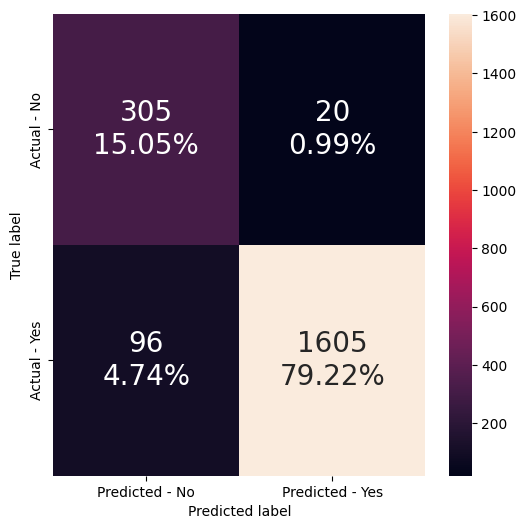

In [198]:
make_confusion_matrix(gbc_un,y_test)

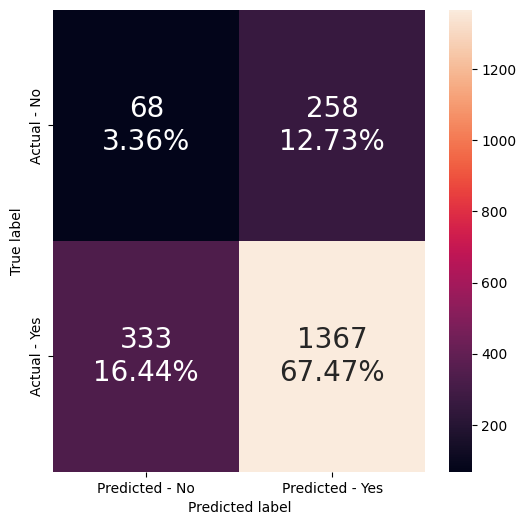

In [199]:
make_confusion_matrix(gbc_un,y_val)

In [200]:
# Predicting the target for train and validation set
pred_train_gbc_un = gbc_un.predict(X_train_un)
pred_test_gbc_un = gbc_un.predict(X_test)
pred_val_gbc_un = gbc_un.predict(X_val)

# Checking Precision score on undersampled train and validation set
ps_train_gbc_un= precision_score(y_train_un, pred_train_gbc_un)
ps_test_gbc_un = precision_score(y_test, pred_test_gbc_un)
ps_val_gbc_un = precision_score(y_val, pred_val_gbc_un)

print("GBC Train un ", ps_train_gbc_un)
print("GBC Test un  ", ps_test_gbc_un)
print("GBC Val  un   ", ps_val_gbc_un)


GBC Train un  0.9783505154639175
GBC Test un   0.9876923076923076
GBC Val  un    0.9859670530811471


### **Gradient Boosting Classifier Performance Summary**

Gradient Boosting Classifier performs better with undersampled data, yielding the largest precision value.

In [201]:
gbc_results = [[ps_train_gbc,ps_test_gbc,ps_val_gbc],[ps_train_gbc_over,ps_test_gbc_over,ps_val_gbc_over],[ps_train_gbc_un,ps_test_gbc_un,ps_val_gbc_un]]
gbc_df = pd.DataFrame(gbc_results,columns=['Train','Test','Val'],index={'normal':'Row_1','Over':'Row_2','Under':'Row_3'})
gbc_df

Train      Test       Val
normal  0.983100  0.969001  0.966053
Over    0.980129  0.977153  0.972690
Under   0.978351  0.987692  0.985967

## **XGBoost Classifier**

### **XGBoost Classifier with Default Train data**

In [202]:
xgb = XGBClassifier(random_state=1,eval_metric='logloss')
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=1, ...)

In [203]:
#Using above defined function to get accuracy, recall and precision on train and test set
xgb_score=get_metrics_score(xgb)

Accuracy on training set :  1.0
Accuracy on test set :  0.9713721618953604
Recall on training set :  1.0
Recall on test set :  0.9905937683715461
Precision on training set :  1.0
Precision on test set :  0.9756803705848291


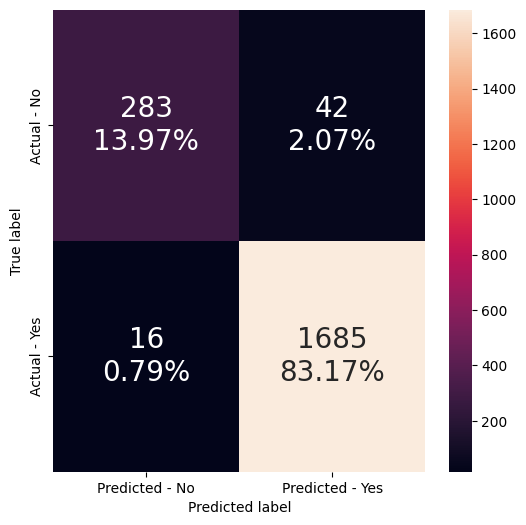

In [204]:
make_confusion_matrix(xgb,y_test)

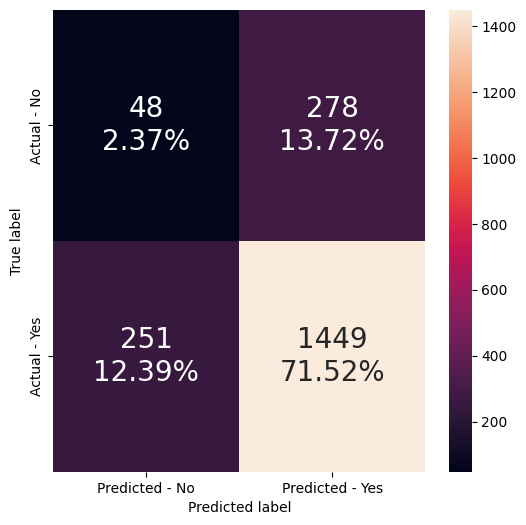

In [205]:
make_confusion_matrix(xgb,y_val)

In [206]:
# Predicting the target for train and validation set
pred_train_xgb = xgb.predict(X_train)
pred_test_xgb = xgb.predict(X_test)
pred_val_xgb = xgb.predict(X_val)

# Checking Precision score on undersampled train and validation set
ps_train_xgb= precision_score(y_train, pred_train_xgb)
ps_test_xgb = precision_score(y_test, pred_test_xgb)
ps_val_xgb = precision_score(y_val, pred_val_xgb)

print("XGB Train  ", ps_train_xgb)
print("XGB Test   ", ps_test_xgb)
print("XGB Val    ", ps_val_xgb)

XGB Train   1.0
XGB Test    0.9756803705848291
XGB Val     0.974477958236659


### **XGBoost Classifier with Oversampled Train Data**

In [207]:
xgb_over = XGBClassifier(random_state=1,eval_metric='logloss')
xgb_over.fit(X_train_over, y_train_over)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=1, ...)

In [208]:
#Using above defined function to get accuracy, recall and precision on train and test set
xgb_score_over=get_metrics_score(xgb_over)

Accuracy on training set :  1.0
Accuracy on test set :  0.9693978282329714
Recall on training set :  1.0
Recall on test set :  0.9870664315108759
Precision on training set :  1.0
Precision on test set :  0.9767306573589296


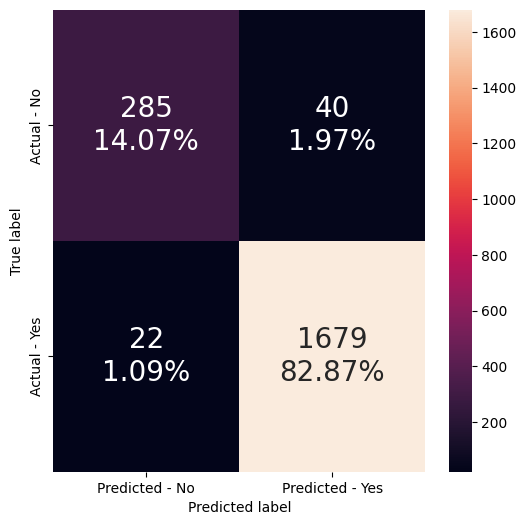

In [209]:
make_confusion_matrix(xgb_over,y_test)

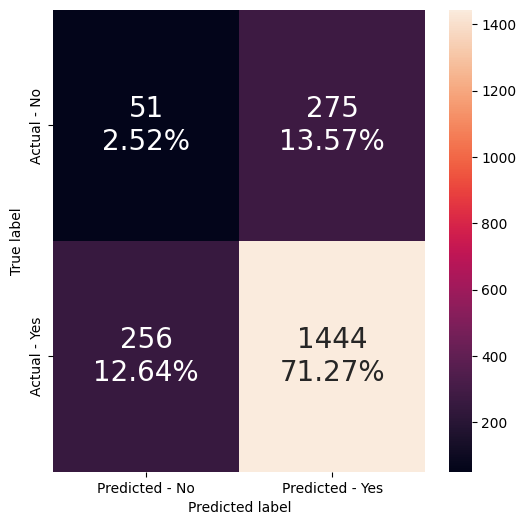

In [210]:
make_confusion_matrix(xgb_over,y_val)

In [211]:
# Predicting the target for train and validation set
pred_train_xgb_over = xgb_over.predict(X_train_over)
pred_test_xgb_over = xgb_over.predict(X_test)
pred_val_xgb_over = xgb_over.predict(X_val)

# Checking Precision score on undersampled train and validation set
ps_train_xgb_over= precision_score(y_train_over, pred_train_xgb_over)
ps_test_xgb_over = precision_score(y_test, pred_test_xgb_over)
ps_val_xgb_over = precision_score(y_val, pred_val_xgb_over)

print("XGB Train over ", ps_train_xgb_over)
print("XGB Test over  ", ps_test_xgb_over)
print("XGB Val over   ", ps_val_xgb_over)

XGB Train over  1.0
XGB Test over   0.9767306573589296
XGB Val over    0.9761904761904762


### **XGBoost Classifier with Undersampled Train Data**

In [212]:
xgb_un = XGBClassifier(random_state=1,eval_metric='logloss')
xgb_un.fit(X_train_un, y_train_un)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=1, ...)

In [213]:
#Using above defined function to get accuracy, recall and precision on train and test set
xgb_score_under=get_metrics_score(xgb_un)

Accuracy on training set :  0.9675720164609054
Accuracy on test set :  0.9491609081934848
Recall on training set :  0.9613649735242205
Recall on test set :  0.9500293944738389
Precision on training set :  1.0
Precision on test set :  0.988984088127295


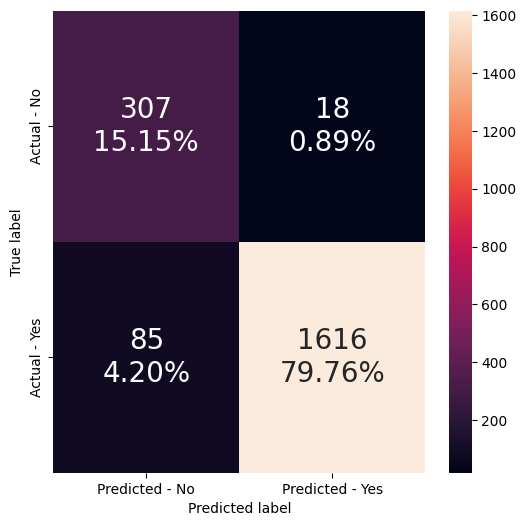

In [214]:
make_confusion_matrix(xgb_un,y_test)

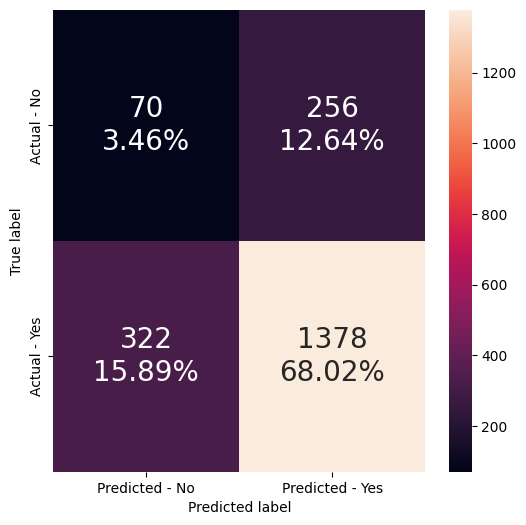

In [215]:
make_confusion_matrix(xgb_un,y_val)

In [216]:
# Predicting the target for train and validation set
pred_train_xgb_un = xgb_un.predict(X_train_un)
pred_test_xgb_un = xgb_un.predict(X_test)
pred_val_xgb_un = xgb_un.predict(X_val)

# Checking Precision score on undersampled train and validation set
ps_train_xgb_un= precision_score(y_train_un, pred_train_xgb_un)
ps_test_xgb_un = precision_score(y_test, pred_test_xgb_un)
ps_val_xgb_un = precision_score(y_val, pred_val_xgb_un)

print("XGB Train un ", ps_train_xgb_un)
print("XGB Test un  ", ps_test_xgb_un)
print("XGB Val un   ", ps_val_xgb_un)


XGB Train un  1.0
XGB Test un   0.988984088127295
XGB Val un    0.9879518072289156


### **XGBoost Classifier Summary**

XGB yields the highest Precision when the train data set is undersampled.

In [217]:
xgb_results = [[ps_train_xgb,ps_test_xgb,ps_val_xgb],
               [ps_train_xgb_over,ps_test_xgb_over,ps_val_xgb_over],
               [ps_train_xgb_un,ps_test_xgb_un,ps_val_xgb_un]]
xgb_df = pd.DataFrame(xgb_results,columns=['Train','Test','Val'],
                      index={'normal':'Row_1','Over':'Row_2','Under':'Row_3'})
xgb_df

Train      Test       Val
normal    1.0  0.975680  0.974478
Over      1.0  0.976731  0.976190
Under     1.0  0.988984  0.987952

# **Hyperparameter Tuning**

## **Compare Models Performance**

We already know that undersampling the Train data yields the highest Precision for all the models analyzed.

Next lets compare all models.

Earlier we had determined that XGBoost, GBC, Adaboost, and Bagging were superior to Decision Trees, Logistic Regresion and Random Forest.

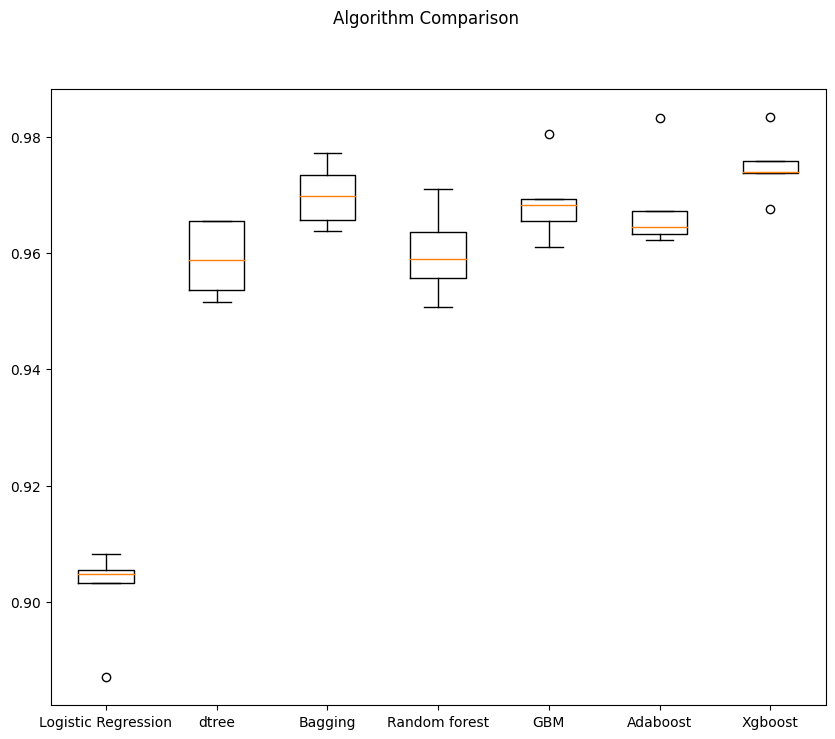

In [218]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10,8))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results)
ax.set_xticklabels(names)

plt.show()

So lets focus on those 4 and compare their scores when they were modelled using the Undersampled Train data which we already know it yielded the highest precision.

In [219]:
results_all_models_df =[[ps_train_abc_un,ps_test_abc_un,ps_val_abc_un],
                        [ps_train_gbc_un,ps_test_gbc_un,ps_val_gbc_un],
                        [ps_train_xgb_un,ps_test_xgb_un,ps_val_xgb_un],
                        [ps_train_bag_un,ps_test_bag_un,ps_val_bag_un],
                        [ps_train_rf_un,ps_test_rf_un,ps_val_rf_un]]
results_scores_all = pd.DataFrame(results_all_models_df,columns=['Train','Test','Val'],
                                  index={'AdaBoost':'Row_1','Gradient Boost':'Row_2',
                                         'XGBoost':'Row_3','Bagging':'Row_4','Random Forest':'Row_5'})

results_scores_all

Train      Test       Val
AdaBoost        0.951295  0.992453  0.985544
Gradient Boost  0.978351  0.987692  0.985967
XGBoost         1.000000  0.988984  0.987952
Bagging         1.000000  0.981669  0.983555
Random Forest   1.000000  0.984395  0.980488

The three models that yield the highest Precision are:
1. Gradient Boost 0.987692, 0.985967
2. Adaboost 0.992453, 0.985544
3. XGBoost 0.985872, 0.0984108

They use the undersampled Train data.

Next in performance is Bagging and then Random Forest. But both are slightly overfitted.



## **Gradient Boost Hyperparameter Tuning Using Randomized Search**

In [220]:
#Number of features
num_feat = X_train.shape[1]
print(num_feat)

30


In [221]:
GradientBoostingClassifier().get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [222]:
#define model
model_gbc = GradientBoostingClassifier(random_state=1)

scorer = metrics.make_scorer(metrics.precision_score)

# Parameter grid to pass in RandomizedSearchCV
param_grid_gbc={'learning_rate':[0.01,0.1,0.2,0.05],
            'max_depth':np.arange(1,5,1),
            'n_estimators':np.arange(50,150,50),
            'max_features':np.arange(1,num_feat),
            'subsample':[0.8,0.9,1],
            'min_samples_split':[0.1,1,10],
            'min_samples_leaf':[0.1,0.5,5],
            }

gbc1_tuned = RandomizedSearchCV(estimator=model_gbc,
                               param_distributions=param_grid_gbc, n_iter=50,
                               scoring=scorer, cv=5, random_state=1, n_jobs = -1)

In [223]:
#Fitting parameters in RandomizedSearchCV
gbc1_tuned.fit(X_train_un,y_train_un)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=1),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2, 0.05],
                                        'max_depth': array([1, 2, 3, 4]),
                                        'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                                        'min_samples_leaf': [0.1, 0.5, 5],
                                        'min_samples_split': [0.1, 1, 10],
                                        'n_estimators': array([ 50, 100]),
                                        'subsample': [0.8, 0.9, 1]},
                   random_state=1, scoring=make_scorer(precision_score))

In [224]:
print("Best parameters are {} with CV score={}:" .format(gbc1_tuned.best_params_,gbc1_tuned.best_score_))

Best parameters are {'subsample': 1, 'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 27, 'max_depth': 2, 'learning_rate': 0.1} with CV score=0.9487576809953419:


In [225]:
# building model with best parameters
gbc1_tuned = GradientBoostingClassifier(n_estimators=100,
                                        learning_rate=0.1,
                                        max_depth=2,
                                        max_features=27,
                                        subsample=1,
                                        min_samples_split=30,
                                        min_samples_leaf=5,)

# Fit the model on training data
gbc1_tuned.fit(X_train_un, y_train_un)

GradientBoostingClassifier(max_depth=2, max_features=27, min_samples_leaf=5,
                           min_samples_split=30, subsample=1)

**Model Performance on Training set**

Training performance:
   Accuracy    Recall  Precision        F1
0  0.953893  0.943648   0.963389  0.953416
*************************************


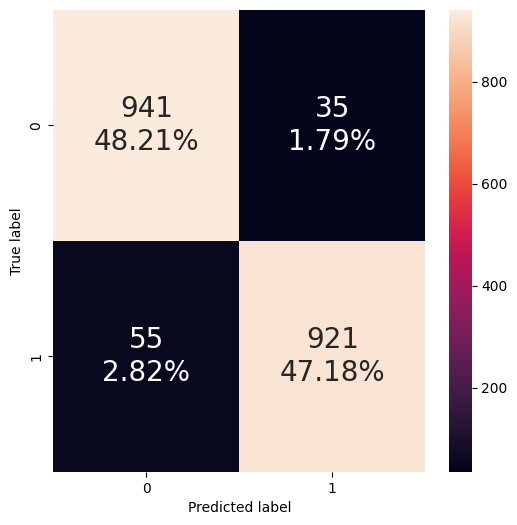

In [226]:
# Calculating different metrics on train set
GradientBoosting_random_train = model_performance_classification_sklearn(
    gbc1_tuned, X_train_un, y_train_un
)
print("Training performance:")
print(GradientBoosting_random_train)


print("*************************************")

# creating confusion matrix
confusion_matrix_sklearn(gbc1_tuned, X_train_un, y_train_un)

**Model Performance on testing set**

Testing performance:
   Accuracy    Recall  Precision        F1
0  0.929418  0.930629   0.984453  0.956785
*************************************


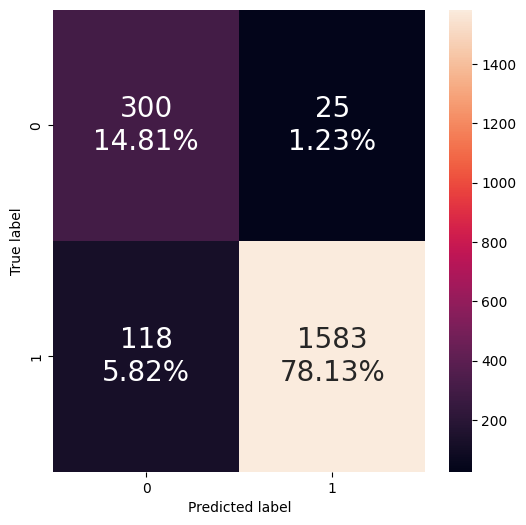

In [227]:
# Calculating different metrics on test set
GradientBoosting_random_test = model_performance_classification_sklearn(
    gbc1_tuned, X_test, y_test
)
print("Testing performance:")
print(GradientBoosting_random_test)


print("*************************************")

# creating confusion matrix
confusion_matrix_sklearn(gbc1_tuned, X_test, y_test)

**Model Performance on Validation set**

Validation performance:
   Accuracy    Recall  Precision        F1
0  0.931885  0.935294   0.982695  0.958409
*************************************


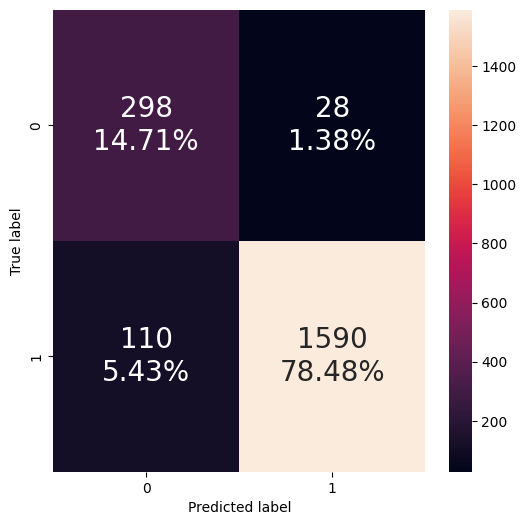

In [228]:
# Calculating different metrics on validation set
GradientBoosting_random_val = model_performance_classification_sklearn(
    gbc1_tuned, X_val, y_val
)
print("Validation performance:")
print(GradientBoosting_random_val)


print("*************************************")

# creating confusion matrix
confusion_matrix_sklearn(gbc1_tuned, X_val, y_val)

## **Adaboost Hyperparamter Tuning using Randomized Search**

In [229]:
AdaBoostClassifier().get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': 'deprecated',
 'estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

In [230]:
#define model
model_adb = AdaBoostClassifier(random_state=1)
# Parameter grid to pass in Randomized Search

param_grid_adb = {
    "n_estimators": np.arange(10, 110, 10),
    "learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
    "base_estimator": [
        DecisionTreeClassifier(max_depth=1, random_state=1),
        DecisionTreeClassifier(max_depth=2, random_state=1),
        DecisionTreeClassifier(max_depth=3, random_state=1),
    ],
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.precision_score)

In [231]:
#Calling RandomizedSearchCV
randomized_cv_adb = RandomizedSearchCV(estimator=model_adb,
                                   param_distributions=param_grid_adb, n_jobs = -1,
                                   n_iter=50, scoring=scorer, cv=5,
                                   random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv_adb.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv_adb.best_params_,randomized_cv_adb.best_score_))

Best parameters are {'n_estimators': 100, 'learning_rate': 0.1, 'base_estimator': DecisionTreeClassifier(max_depth=2, random_state=1)} with CV score=0.9521107629846522:


In [232]:
# building model with best parameters
adb_tuned1 = AdaBoostClassifier(
    n_estimators=100,
    learning_rate=0.1,
    random_state=1,
    base_estimator=DecisionTreeClassifier(max_depth=2, random_state=1),
)

# Fit the model on training data
adb_tuned1.fit(X_train_un, y_train_un)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         random_state=1),
                   learning_rate=0.1, n_estimators=100, random_state=1)

**AdaBoost Classifier Performance**

Training performance:
   Accuracy    Recall  Precision       F1
0  0.961578  0.953893   0.968783  0.96128
*************************************


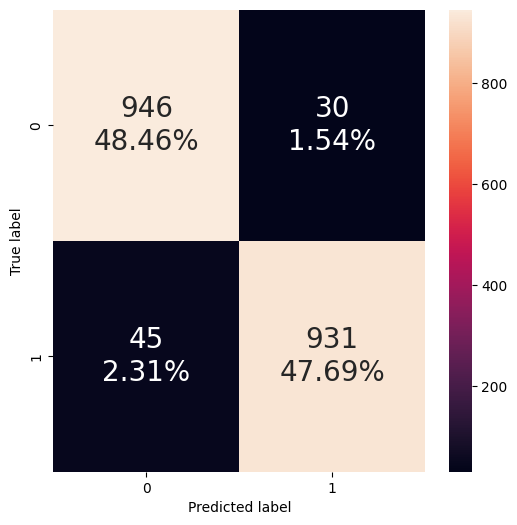

In [233]:
# Calculating different metrics on train set
Adaboost_random_train = model_performance_classification_sklearn(
    adb_tuned1, X_train_un, y_train_un
)
print("Training performance:")
print(Adaboost_random_train)


print("*************************************")

# creating confusion matrix
confusion_matrix_sklearn(adb_tuned1, X_train_un, y_train_un)

Testing performance:
   Accuracy    Recall  Precision        F1
0  0.942744  0.940623   0.990712  0.965018
*************************************


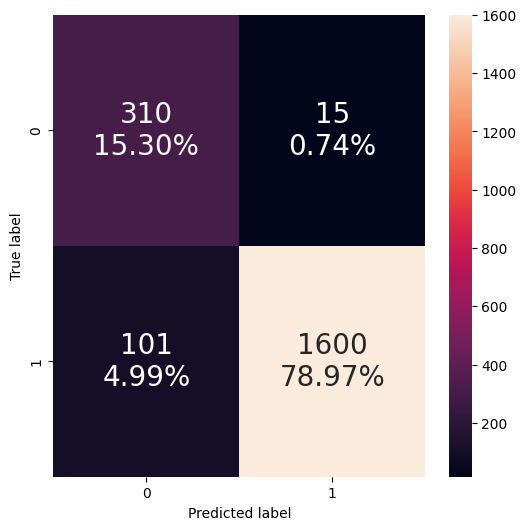

In [234]:
# Calculating different metrics on test set
Adaboost_random_test = model_performance_classification_sklearn(
    adb_tuned1, X_test, y_test
)
print("Testing performance:")
print(Adaboost_random_test)


print("*************************************")

# creating confusion matrix
confusion_matrix_sklearn(adb_tuned1, X_test, y_test)

Validation performance:
   Accuracy    Recall  Precision        F1
0  0.934847  0.936471   0.985149  0.960193
*************************************


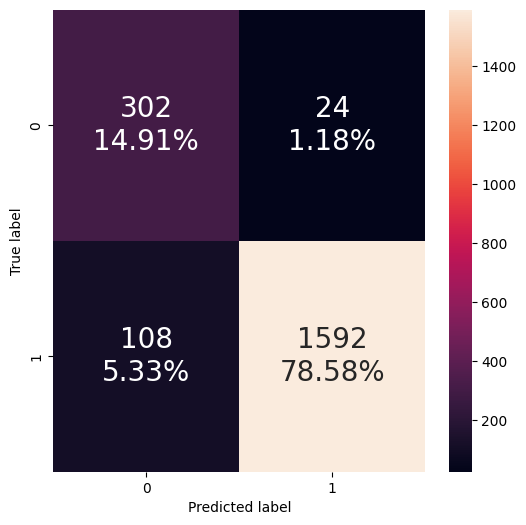

In [235]:
# Calculating different metrics on val set
Adaboost_random_val = model_performance_classification_sklearn(
    adb_tuned1, X_val, y_val
)
print("Validation performance:")
print(Adaboost_random_val)


print("*************************************")

# creating confusion matrix
confusion_matrix_sklearn(adb_tuned1, X_val, y_val)

## **XGBoost Hyperparamter Tuning using Randomized Search**

In [236]:
#defining model
model_xgb = XGBClassifier(random_state=1,eval_metric='logloss')

#Parameter grid to pass in RandomizedSearch
param_grid={'n_estimators':np.arange(50,150,50),
            'scale_pos_weight':[2,5,10],
            'learning_rate':[0.01,0.1,0.2,0.05],
            'gamma':[0,1,3,5],
            'subsample':[0.8,0.9,1],
            'max_depth':np.arange(1,5,1),
            'reg_lambda':[5,10]}


# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.precision_score)

#Calling RandomizedSearchCV
xgb_tuned1 = RandomizedSearchCV(estimator=model_xgb, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=1, n_jobs = -1)

#Fitting parameters in RandomizedSearchCV
xgb_tuned1.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(xgb_tuned1.best_params_,xgb_tuned1.best_score_))

Best parameters are {'subsample': 0.9, 'scale_pos_weight': 2, 'reg_lambda': 10, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.2, 'gamma': 1} with CV score=0.9337850500501819:


In [237]:
# building model with best parameters
xgb_tuned1 = XGBClassifier(
    random_state=1,
    n_estimators=100,
    scale_pos_weight=2,
    gamma=1,
    subsample=0.9,
    learning_rate=0.2,
    eval_metric="logloss",
    max_depth=4,
    reg_lambda=10,
)
# Fit the model on training data
xgb_tuned1.fit(X_train_un, y_train_un)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=1, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=1, ...)

Training performance:
   Accuracy    Recall  Precision        F1
0  0.989754  0.997951   0.981855  0.989837
*************************************


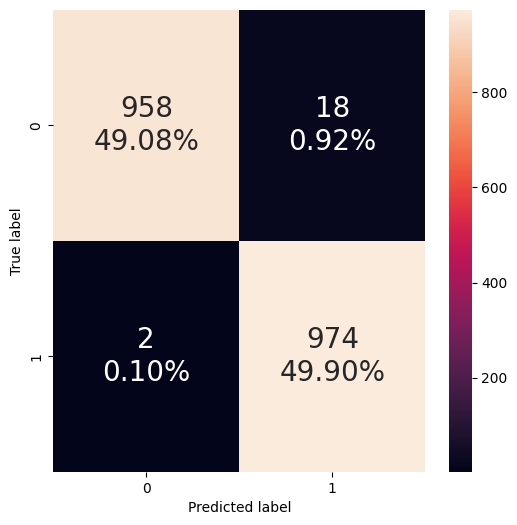

In [238]:
# Calculating different metrics on train set
xgboost_random_train = model_performance_classification_sklearn(
    xgb_tuned1, X_train_un, y_train_un
)
print("Training performance:")
print(xgboost_random_train)

print("*************************************")


# creating confusion matrix
confusion_matrix_sklearn(xgb_tuned1, X_train_un, y_train_un)

Testing performance:
   Accuracy   Recall  Precision        F1
0  0.956565  0.96649   0.981493  0.973934
*************************************


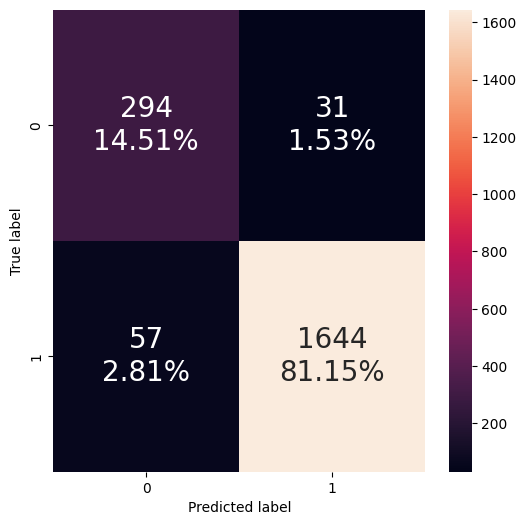

In [239]:
# Calculating different metrics on train set
xgboost_random_test = model_performance_classification_sklearn(
    xgb_tuned1, X_test, y_test
)
print("Testing performance:")
print(xgboost_random_test)

print("*************************************")


# creating confusion matrix
confusion_matrix_sklearn(xgb_tuned1, X_test, y_test)

Validation performance:
   Accuracy    Recall  Precision        F1
0  0.960513  0.969412   0.983294  0.976303
*************************************


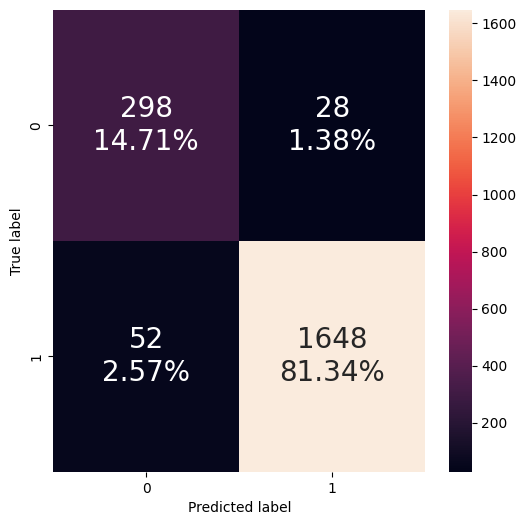

In [240]:
# Calculating different metrics on train set
xgboost_random_val = model_performance_classification_sklearn(
    xgb_tuned1, X_val, y_val
)
print("Validation performance:")
print(xgboost_random_val)

print("*************************************")


# creating confusion matrix
confusion_matrix_sklearn(xgb_tuned1, X_val, y_val)

## **Comparison of Hyperparameter Tuned Models**

In [241]:
# training performance comparison

models_train_comp_df = pd.concat(
    [

        Adaboost_random_train.T,
        GradientBoosting_random_train.T,
        xgboost_random_train.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "AdaBoost Tuned with Random search",
    "GradientBoosting Tuned with Random search",
    "Xgboost Tuned with Random Search",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


AdaBoost Tuned with Random search  \
Accuracy                            0.961578   
Recall                              0.953893   
Precision                           0.968783   
F1                                  0.961280   

           GradientBoosting Tuned with Random search  \
Accuracy                                    0.953893   
Recall                                      0.943648   
Precision                                   0.963389   
F1                                          0.953416   

           Xgboost Tuned with Random Search  
Accuracy                           0.989754  
Recall                             0.997951  
Precision                          0.981855  
F1                                 0.989837

In [242]:
# testing performance comparison

models_test_comp_df = pd.concat(
    [

        Adaboost_random_test.T,
        GradientBoosting_random_test.T,
        xgboost_random_test.T,
    ],
    axis=1,
)
models_test_comp_df.columns = [
    "AdaBoost Tuned with Random search",
    "GradientBoosting Tuned with Random search",
    "Xgboost Tuned with Random Search",
]
print("Testing performance comparison:")
models_test_comp_df

Testing performance comparison:


AdaBoost Tuned with Random search  \
Accuracy                            0.942744   
Recall                              0.940623   
Precision                           0.990712   
F1                                  0.965018   

           GradientBoosting Tuned with Random search  \
Accuracy                                    0.929418   
Recall                                      0.930629   
Precision                                   0.984453   
F1                                          0.956785   

           Xgboost Tuned with Random Search  
Accuracy                           0.956565  
Recall                             0.966490  
Precision                          0.981493  
F1                                 0.973934

In [243]:
# validation performance comparison

models_val_comp_df = pd.concat(
    [

        Adaboost_random_val.T,
        GradientBoosting_random_val.T,
        xgboost_random_val.T,
    ],
    axis=1,
)
models_val_comp_df.columns = [
    "AdaBoost Tuned with Random search",
    "GradientBoosting Tuned with Random search",
    "Xgboost Tuned with Random Search",
]
print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


AdaBoost Tuned with Random search  \
Accuracy                            0.934847   
Recall                              0.936471   
Precision                           0.985149   
F1                                  0.960193   

           GradientBoosting Tuned with Random search  \
Accuracy                                    0.931885   
Recall                                      0.935294   
Precision                                   0.982695   
F1                                          0.958409   

           Xgboost Tuned with Random Search  
Accuracy                           0.960513  
Recall                             0.969412  
Precision                          0.983294  
F1                                 0.976303

Comparing the three models we notice that on the Validation set, Adaboost has a precision of 0.985149 which is better than GradientBoosting 0.983344 and XGBoost 0.983294.

In the testing set, Adaboost also has the advantage in the Precision score.

In the training set, XGboost has the highest Precision and Adaboost the lowest.

The F1 score is highest for XGboost, with Adaboost being second. However, while F1 is important to minimize the false positives and false negatives, our objective is to minimize the false positives so we can properly target customers that churn.

We choose as our model Adaboost with tuned hyperparameters and undersampled train data.

# **Productionize the model**

In [244]:
# creating a list of numerical variables
numerical_features = [
    "Customer_Age",
    "Dependent_count",
    "Months_on_book",
    "Total_Relationship_Count",
    "Months_Inactive_12_mon",
    "Contacts_Count_12_mon",
    "Credit_Limit",
    "Total_Revolving_Bal",
    "Avg_Open_To_Buy",
    "Total_Trans_Amt",
    "Total_Trans_Ct",
    "Total_Ct_Chng_Q4_Q1",
    "Total_Amt_Chng_Q4_Q1",
    "Avg_Utilization_Ratio",
]

# creating a transformer for numerical variables, which will apply simple imputer on the numerical variables
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])


# creating a list of categorical variables
categorical_features = ["Gender", "Education_Level","Marital_Status","Income_Category","Card_Category"]

# creating a transformer for categorical variables, which will first apply simple imputer and
#then do one hot encoding for categorical variables
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)
# handle_unknown = "ignore", allows model to handle any unknown category in the test data

# combining categorical transformer and numerical transformer using a column transformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="passthrough",
)
# remainder = "passthrough" has been used, it will allow variables that are present in original data
# but not in "numerical_columns" and "categorical_columns" to pass through the column transformer without any changes


In [245]:
# Separating target variable and other variables
X = bc_df.drop(columns="Attrition_Flag")
Y = bc_df["Attrition_Flag"]

In [246]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.30, random_state=1, stratify=Y
)

# fit random under sampler on the train data
rus = RandomUnderSampler(random_state=1, sampling_strategy = 1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

print(X_train_un.shape, X_test.shape)


(2278, 19) (3039, 19)


Best parameters are {'n_estimators': 100, 'learning_rate': 0.1, 'base_estimator': DecisionTreeClassifier(max_depth=2, random_state=1)} with CV score=0.9521107629846522:

adb_tuned1 = AdaBoostClassifier(
    n_estimators=100,
    learning_rate=0.1,
    random_state=1,
    base_estimator=DecisionTreeClassifier(max_depth=2, random_state=1),
)


In [247]:
# Creating new pipeline with best parameters
model = Pipeline(
    steps=[
        ("pre", preprocessor),
        (
            "ABC",
            AdaBoostClassifier(
                random_state=1,
                n_estimators=100,
                learning_rate=0.1,
                base_estimator= DecisionTreeClassifier(max_depth=2,random_state=1),
            ),
        ),
    ]
)
# Fit the model on training data
model.fit(X_train_un, y_train_un)

Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Customer_Age',
                                                   'Dependent_count',
                                                   'Months_on_book',
                                                   'Total_Relationship_Count',
                                                   'Months_Inactive_12_mon',
                                                   'Contacts_Count_12_mon',
                                                   'Credit_Limit',
                                                   'Total_Revolving_Bal',
                                                   'Avg_Open_To_Buy',
                                                   'Total_Trans_Amt',
                                                   '...
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Education_Level',
                                                   'Marital_Status',
                                                   'Income_Category',
                                                   'Card_Category'])])),
                ('ABC',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                                          random_state=1),
                                    learning_rate=0.1, n_estimators=100,
                                    random_state=1))])

In [248]:
# transforming and predicting on test data
model.predict(X_test)

array(['Existing Customer', 'Existing Customer', 'Existing Customer', ...,
       'Existing Customer', 'Existing Customer', 'Attrited Customer'],
      dtype=object)

# **Insights and Recommendations**

- This model will help predict which customers will cancel the credit card service.
- Obtaining new clients is not the objective of this model.
- The model aims to reduce the number of False Positives, that is, reducing the number of customers that were misclassified as "Existing Customers".
- We recommend that a customer retention plan is implemented that is focuses on incentives for customers that use the credit card often.
- Create alliances with stores that can offer special promotions for customers.  This way the credit card Average Utilization Ratio, the Total Transaction Count, Total Transaction Amount increase. From our analysis, customers that had a utilization ratio of 20% or less, attrited the most.
- Create special events that require having an active credit card.  Customize these events to attract the most educated custoemrs. Our analysis shows that the attrition is highest in the group of customers that are the most educated (Doctorate and Post-Graduate actually attrited the most within their groups.    
- Create programs or activities that are tailored to women and that require having an active credit card. Our analysis shows that women attrite at a higher rate than men (3% higher). This is important because most of the customers are women.
- Create a plan for customers to be able to increase their expenses during holidays in Q4 because our analysis shows that customers that spent less in Q4 than Q1 tend to attrite. This probably means that customers Christmas and end of the year purchases couldn't be done with the credit card.
- Create a program for customers that make \$40K or less. Such programs could provide some benefits to this group, like reduce price of movie tickets, or sports events. Our analysis shows that the \$40K or less income group attrite the most.
- It is important to minimize the complaints or doubts of customers so customers do not contact the bank. Our reserach shows that when customers actually had to contact the bank the most, they attrited more.